### Guidance
This script will
- constrain MCM and GEOS-Chem mechanism
- constrain the customized GEOS-Chem mechanism 

Version updates:
- We update a function to make the plotting process easier.

In [1]:
# This entire file is exempt from PEP 8 checks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import os
import matplotlib.ticker as ticker
from scipy.stats import linregress
import seaborn as sns
from collections import OrderedDict

from pathlib import Path

# Changing the CWD
os.chdir('/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_helper')
from data_processing import *
from VOCR_reader_cases import *
from Plotting_helper import *
from ConstantVal import *
from sklearn.cluster import KMeans

from data_processing import *

import matplotlib.colors as mcolors
from ltsfit.lts_linefit import lts_linefit
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function to classify each row
def group_above_threshold(df, threshold, group_by_column):
    """
    Groups and aggregates DataFrame entries above a specified threshold.

    Parameters:
    df (pd.DataFrame): DataFrame to be processed.
    threshold (float): Threshold above which the DataFrame will be grouped.
    group_by_column (str): Column name to use for grouping.
    aggregation (str): Aggregation function (e.g., 'mean', 'sum').

    Returns:
    pd.DataFrame: Processed DataFrame with entries above the threshold grouped.
    """
    # Split the DataFrame
    df_below_or_equal_threshold = df[df.index <= threshold]
    df_above_threshold = df[df.index > threshold]
    
    # Group and aggregate the portion of the DataFrame with index > threshold
    data_above_threshold = df_above_threshold.mean()
    df_above_threshold   = (pd.DataFrame(data_above_threshold)).transpose()

    # Rename the index
    df_above_threshold = df_above_threshold.rename(index={0: f'> {threshold} hour'})
    # Concatenate the ungrouped and grouped parts
    final_df = pd.concat([df_below_or_equal_threshold, df_above_threshold])

    return final_df


def reorder_legend(ax, desired_order, label_mapping, fontsize, legend_title=None, title_fontsize=None, legend_loc='upper right', markerscale=1):
    """
    Reorders the legend of a plot based on a specified order and allows adjusting the marker scale in the legend.

    Parameters:
    ax (matplotlib.axes.Axes): The axes object of the plot.
    desired_order (list): The desired order of legend labels.
    label_mapping (dict): A dictionary mapping original labels to desired labels.
    fontsize (int): Font size for the legend labels.
    legend_title (str, optional): Title for the legend.
    title_fontsize (int, optional): Font size for the legend title.
    legend_loc (str, optional): Location for the legend.
    markerscale (float, optional): The relative size of legend markers compared with the originally drawn ones. Default is 1.
    """
    # Use the dictionary to get the corresponding labels, defaulting to the key itself
    desired_order_labels = [label_mapping.get(key, key) for key in desired_order]

    # Capture the existing handles and labels from the current legend
    handles, labels = ax.get_legend_handles_labels()

    # Create a dictionary from labels to handles
    label_handle_dict = dict(zip(labels, handles))

    # Reorder the handles based on the desired order of labels
    handles_ordered = [label_handle_dict[label] for label in desired_order_labels if label in label_handle_dict]

    # Only include the labels that are actually present in the labels list
    labels_ordered = [label for label in desired_order_labels if label in label_handle_dict]

    # Create a new legend with the ordered handles and labels
    ax.legend(handles_ordered, labels_ordered, fontsize=fontsize, title=legend_title, title_fontsize=title_fontsize, loc=legend_loc, markerscale=markerscale)

    
def photolysis_retriver(all_data, var_compound, var_jvalue, aggregation):

    # Drop rows where either the compound or J-value is missing
    temp_obs = all_data.dropna(subset=[var_compound, var_jvalue])
    '''
    # test
    test_obs = temp_obs[temp_obs['time_bin']==150.0]
    total_rows = len(temp_obs)
    total_columns = len(temp_obs.columns)

    pd.set_option('display.max_rows', total_rows)
    pd.set_option('display.max_columns', total_columns)

    print(temp_obs[['Flight_ID','Plume_Age', var_compound, var_jvalue, 'time_bin']])

    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    '''
    # Group by time bins and calculate statistical aggregations
    binned_obs_stat = temp_obs.groupby('time_bin').agg(['mean', 'std', 'median', iqr])
    
    # Calculate the photolysis rate
    data_obs = binned_obs_stat[var_compound, aggregation].mul(binned_obs_stat[var_jvalue, aggregation].values, axis=0)

    return data_obs, binned_obs_stat[var_jvalue, aggregation]

In [3]:
def bin_df(df_compound_mod, interval_X):
    """
    Bins a DataFrame based on a specified time interval and computes statistical measures for each bin.

    This function takes a DataFrame where the index represents time and groups the data into bins of a specified interval. 
    It computes the median, interquartile range (IQR), mean, and standard deviation for each bin.

    Parameters:
    df_compound_mod (DataFrame): A DataFrame with a time-based index.
    interval_X (int): The time interval for binning data, specified in the same units as the DataFrame index.

    Returns:
    DataFrame: A new DataFrame where each row represents a time bin, and columns include the median, IQR, mean, 
               and standard deviation of the original DataFrame's columns for that bin.
    """

    # Create bin edges for every X minutes, doulbe check if we want it to start with 0 or not...
    bin_edges = np.arange(0, df_compound_mod.index.max() + interval_X, interval_X)

    # Use the `cut` function to bin the data
    df_compound_mod['time_bin'] = pd.cut(df_compound_mod.index, bins=bin_edges, labels=bin_edges[:-1] + interval_X, right=False)
    
    # Group by the time bin and compute median, IQR, mean, and standard deviation for each bin
    binned_mod_stats = df_compound_mod.groupby('time_bin').agg(['median', iqr, 'mean', 'std'])

    # Drop rows where all elements are NaN
    binned_mod_stats = binned_mod_stats.dropna(how='all')    
    
    # Convert the index to numeric (if it's not already numeric)
    numeric_index = pd.to_numeric(binned_mod_stats.index, errors='coerce')

    # Check if the conversion was successful
    if numeric_index.isnull().any():
        print("Warning: Some index values could not be converted to numeric.")

    # Round the numeric index by converting to a Series first
    rounded_index = pd.Series(numeric_index).round(2)

    # Assign the rounded index back to the DataFrame
    binned_mod_stats.index = rounded_index

    # Return the binned statistics
    return binned_mod_stats


## Data processing for smk concentration
This script reads all observed flights and put them in one dataset.
- Evaluting O3 and OH turnover rate
- Evaluting OH concentrations

In [4]:
# Dictionary to store OH exposure data for each flight
# Observation
nemr_ox_per_flight_obs           = {}
nemr_o3_per_flight_obs           = {}
nemr_o3_nox_per_flight_obs       = {}
co_per_flight_obs                = {}
no_per_flight_obs                = {}
no2_per_flight_obs               = {}
nox_per_flight_obs               = {}
o3_per_flight_obs                = {}
ox_per_flight_obs                = {}

pan_per_flight_obs               = {}
ppan_per_flight_obs              = {}
pmco3_per_flight_obs             = {}
lpan_per_flight_obs              = {}
lmco3_per_flight_obs             = {}

ch2o_per_flight_obs              = {}
ch2o_no2_per_flight_obs          = {}

calOH_stat_per_flight_obs        = {}
calOH_vocs_per_flight_obs        = {}
outputOH_per_flight_obs          = {}
cal_chem_age_stat_per_flight_obs = {}
cal_chem_age_vocs_per_flight_obs = {}
output_chem_age_per_flight_obs   = {}

vocr_per_flight_obs              = {}
noxr_per_flight_obs              = {}
OHRvoc_OHRnox_per_flight_obs     = {}
OHRnox_OHRvoc_per_flight_obs     = {}

Ln_per_flight_obs                = {}
Q_per_flight_obs                 = {}

hno2_per_flight_obs              = {}
nemr_hno2_per_flight_obs         = {}

ald2_per_flight_obs              = {}
glyx_per_flight_obs              = {}
mgly_per_flight_obs              = {}
biacet_per_flight_obs            = {}

propanal_per_flight_obs          = {}
butanal_per_flight_obs           = {}

acet_per_flight_obs              = {}
mek_per_flight_obs               = {}
acr_per_flight_obs               = {}
macr_per_flight_obs              = {}
mvk_per_flight_obs               = {}
glyc_per_flight_obs              = {}
hac_per_flight_obs               = {}
furfural_per_flight_obs          = {}

met_per_flight_obs               = {}

sesq_per_flight_obs              = {}
dmf_per_flight_obs               = {}

# CH2O, ALD2, MA
ch2o_per_flight_dil_obs          = {}
ald2_per_flight_dil_obs          = {}
ma_per_flight_dil_obs            = {}
# furanoids (excluding M3F and DMF), acrolein, 1,3-butdiene
furanoids_excl_per_flight_dil_obs= {}
methylfuran_per_flight_dil_obs   = {}

acr_per_flight_dil_obs           = {}
butd_per_flight_dil_obs          = {}


# Other primary VOCs
# This includes isoprene, monoterpenes, xylenes, 2-butenal, and cresol
# creosol, 2,5-dimethylfuran, guaiacol, syringol, and sesquiterpene
isop_per_flight_dil_obs          = {}
mtpa_per_flight_dil_obs          = {}
xyle_per_flight_dil_obs          = {}
butenal_per_flight_dil_obs       = {}
cresol_per_flight_dil_obs        = {}
dmf_per_flight_dil_obs           = {}
guaiacol_per_flight_dil_obs      = {}
syringol_per_flight_dil_obs      = {}
sesq_per_flight_dil_obs          = {}

# Other secondary VOCs
rcho_per_flight_dil_obs          = {}
glyx_per_flight_dil_obs          = {}
hcooh_per_flight_dil_obs         = {}
acta_per_flight_dil_obs          = {}
macr_mvk_per_flight_dil_obs      = {}
mek_per_flight_dil_obs           = {}
glyc_per_flight_dil_obs          = {}
mgly_per_flight_dil_obs          = {}
hac_per_flight_dil_obs           = {}
phen_per_flight_dil_obs          = {}
bald_per_flight_dil_obs          = {}
furanone_per_flight_dil_obs      = {}
acr_per_flight_dil_obs           = {}
ma_per_flight_dil_obs            = {}
butanedione_per_flight_dil_obs   = {}
butanedione_per_flight_obs       = {}
TM123B_per_flight_dil_obs        = {}
TM135B_per_flight_dil_obs        = {}
C9arom_per_flight_dil_obs        = {}

o3_per_flight_dil_obs            = {}
pan_per_flight_dil_obs           = {}

ch2o_co_per_flight_obs           = {}
vocr_co_per_flight_obs           = {}
noxr_co_per_flight_obs           = {}
no_co_per_flight_obs             = {}
no2_co_per_flight_obs            = {}
nox_co_per_flight_obs            = {}
pan_co_per_flight_obs            = {}
hno2_co_per_flight_obs           = {}
noz_co_per_flight_obs            = {}

furan_co_per_flight_obs          = {}
mefuran_co_per_flight_obs        = {} 
dmf_co_per_flight_obs            = {}
furfural_co_per_flight_obs       = {}
mefurfural_co_per_flight_obs     = {}
furanone_co_per_flight_obs       = {}
butd_co_per_flight_obs           = {}
acr_co_per_flight_obs            = {}

ho2_per_flight_obs            = {}
ro2_per_flight_obs            = {}

pox_per_flight_obs               = {}
po3_per_flight_obs               = {}

lox_per_flight_obs               = {}
lo3_per_flight_obs               = {}
# Other photochemical indicators 
lrox_lnox_per_flight_obs         = {}
ln_q_per_flight_obs              = {}
h2o2_hno3_per_flight_obs         = {}

# Nitrate
no_per_flight_obs                = {}
no2_per_flight_obs               = {}
hno2_per_flight_obs              = {}
pno3_per_flight_obs              = {}
hno3_per_flight_obs              = {}
hno4_per_flight_obs              = {}
ppn_per_flight_obs               = {}
pns_per_flight_obs               = {}
ans_per_flight_obs               = {}

no_per_flight_dil_obs            = {}
no2_per_flight_dil_obs            = {}
hno2_per_flight_dil_obs            = {}
pno3_per_flight_dil_obs           = {}
hno3_per_flight_dil_obs           = {}
hno4_per_flight_dil_obs           = {}
ppn_per_flight_dil_obs            = {}
pns_per_flight_dil_obs            = {}
ans_per_flight_dil_obs            = {}
pns_excl_per_flight_dil_obs   = {}
pan_per_flight_dil_obs            = {}

nemr_no_per_flight_obs            = {}
nemr_no2_per_flight_obs           = {}
nemr_hno2_per_flight_obs          = {}
nemr_pno3_per_flight_obs          = {}
nemr_hno3_per_flight_obs          = {}
nemr_hno4_per_flight_obs          = {}
nemr_ppn_per_flight_obs           = {}
nemr_pns_per_flight_obs           = {}
nemr_ans_per_flight_obs           = {}
nemr_pns_excl_per_flight_obs      = {}
nemr_pan_per_flight_obs           = {}

# Model
nemr_ox_per_flight_mod           = {}
nemr_o3_per_flight_mod           = {}
nemr_o3_nox_per_flight_mod       = {}
co_per_flight_mod                = {}
no_per_flight_mod                = {}
no2_per_flight_mod               = {}
nox_per_flight_mod               = {}
o3_per_flight_mod                = {}
ox_per_flight_mod                = {}

pan_per_flight_mod               = {}

ppan_per_flight_mod              = {}
pmco3_per_flight_mod             = {}
lpan_per_flight_mod              = {}
lmco3_per_flight_mod             = {}

ch2o_per_flight_mod              = {}
ch2o_no2_per_flight_mod          = {}

calOH_stat_per_flight_mod        = {}
calOH_vocs_per_flight_mod        = {}
outputOH_per_flight_mod          = {}

cal_chem_age_stat_per_flight_mod = {}
cal_chem_age_vocs_per_flight_mod = {}
output_chem_age_per_flight_mod   = {}

vocr_per_flight_mod              = {}
noxr_per_flight_mod              = {}
OHRvoc_OHRnox_per_flight_mod     = {}
OHRnox_OHRvoc_per_flight_mod     = {}

Ln_per_flight_mod                = {}
Q_per_flight_mod                 = {}

hno2_per_flight_mod              = {}
nemr_hno2_per_flight_mod         = {} 

ald2_per_flight_mod              = {}
glyx_per_flight_mod              = {}
mgly_per_flight_mod              = {}
biacet_per_flight_mod            = {}

propanal_per_flight_mod          = {}
butanal_per_flight_mod           = {}

acet_per_flight_mod              = {}
mek_per_flight_mod               = {}
acr_per_flight_mod               = {}
macr_per_flight_mod              = {}
mvk_per_flight_mod               = {}
glyc_per_flight_mod              = {}
hac_per_flight_mod               = {}
furfural_per_flight_mod          = {}

sesq_per_flight_mod              = {}
dmf_per_flight_mod               = {}

# model evualtion VOCs
ch2o_per_flight_dil_mod          = {}
ald2_per_flight_dil_mod          = {}
ma_per_flight_dil_mod            = {}
# furanoids (excluding DMF and M3F), acrolein, 1,3-butdien
furanoids_excl_per_flight_dil_mod = {}
methylfuran_per_flight_dil_mod    = {}

acr_per_flight_dil_mod           = {}
butd_per_flight_dil_mod          = {}

# Other primary VOCs
# This includes isoprene, monoterpenes, xylenes, 2-butenal, and cresol
# creosol, 2,5-dimethylfuran, guaiacol, syringol, and sesquiterpene
isop_per_flight_dil_mod          = {}
mtpa_per_flight_dil_mod          = {}
xyle_per_flight_dil_mod          = {}
butenal_per_flight_dil_mod       = {}
cresol_per_flight_dil_mod        = {}
dmf_per_flight_dil_mod           = {}
guaiacol_per_flight_dil_mod       = {}
syringol_per_flight_dil_mod      = {}
sesq_per_flight_dil_mod          = {}

# Other secondary VOCs
rcho_per_flight_dil_mod          = {}
glyx_per_flight_dil_mod          = {}
hcooh_per_flight_dil_mod         = {}
acta_per_flight_dil_mod          = {}
macr_mvk_per_flight_dil_mod      = {}
mek_per_flight_dil_mod           = {}
glyc_per_flight_dil_mod          = {}
mgly_per_flight_dil_mod          = {}
hac_per_flight_dil_mod           = {}
phen_per_flight_dil_mod          = {}
bald_per_flight_dil_mod          = {}
furanone_per_flight_dil_mod      = {}
acr_per_flight_dil_mod           = {}
ma_per_flight_dil_mod            = {}
butanedione_per_flight_dil_mod   = {}
butanedione_per_flight_mod       = {}

TM123B_per_flight_dil_mod        = {}
TM135B_per_flight_dil_mod        = {}
C9arom_per_flight_dil_mod        = {}

o3_per_flight_dil_mod            = {}
pan_per_flight_dil_mod           = {}

ch2o_co_per_flight_mod           = {}
vocr_co_per_flight_mod           = {}
noxr_co_per_flight_mod           = {}
no_co_per_flight_mod             = {}
no2_co_per_flight_mod            = {}
nox_co_per_flight_mod            = {}
pan_co_per_flight_mod            = {}
hno2_co_per_flight_mod           = {}
noz_co_per_flight_mod            = {}

furan_co_per_flight_mod          = {}
mefuran_co_per_flight_mod        = {} 
dmf_co_per_flight_mod            = {}
furfural_co_per_flight_mod       = {}
mefurfural_co_per_flight_mod     = {}
furanone_co_per_flight_mod       = {}
butd_co_per_flight_mod           = {}
acr_co_per_flight_mod            = {}

ho2_per_flight_mod               = {}
ro2_per_flight_mod               = {}
pox_per_flight_mod               = {}
po3_per_flight_mod               = {}
lox_per_flight_mod               = {}
lo3_per_flight_mod               = {}
# Other photochemical indicators 
lrox_lnox_per_flight_mod         = {}
ln_q_per_flight_mod              = {}
h2o2_hno3_per_flight_mod         = {}

# Nitrates

no_per_flight_mod                = {}
no2_per_flight_mod               = {}
hno2_per_flight_mod              = {}
pno3_per_flight_mod              = {}
hno3_per_flight_mod              = {}
hno4_per_flight_mod              = {}
ppn_per_flight_mod               = {}
pns_per_flight_mod               = {}
ans_per_flight_mod               = {}


no_per_flight_dil_mod            = {}
no2_per_flight_dil_mod           = {}
hno2_per_flight_dil_mod          = {}
pno3_per_flight_dil_mod          = {}
hno3_per_flight_dil_mod          = {}
hno4_per_flight_dil_mod          = {}
ppn_per_flight_dil_mod           = {}
pns_per_flight_dil_mod           = {}
ans_per_flight_dil_mod           = {}
pns_excl_per_flight_dil_mod      = {}

pan_per_flight_dil_mod           = {}

nemr_no_per_flight_mod            = {}
nemr_no2_per_flight_mod           = {}
nemr_hno2_per_flight_mod          = {}
nemr_pno3_per_flight_mod          = {}
nemr_hno3_per_flight_mod          = {}
nemr_hno4_per_flight_mod          = {}
nemr_ppn_per_flight_mod           = {}
nemr_pns_per_flight_mod           = {}
nemr_ans_per_flight_mod           = {}
nemr_pns_excl_per_flight_mod      = {}
nemr_pan_per_flight_mod           = {}

# Plotting for the figure
linewidth = 3
error_infor = False
fontsize_flight = 20
fontsize_tick   = 20
fontsize_label  = 12
fontsize_comp   = 18

# Colors for model
#colors = ['green', 'purple', 'orange', \
#         'red', 'blue']
colors = [
    "darkred",  
    "royalblue",  
    "darkgreen",  
    "darkorange", 
    "tab:brown",
    "tab:pink", 
    "darkgray", 
    "gold",      # yellow
    "indigo",  # purple
    "black", 
    "lawngreen", 
]
# VOCs used to calculated OH concentration
voc_names = ['Furan', 'Furfural', 'Furanone', 'Butadiene', 
             'Phenol', 'Tolualdehyde', 'Guaiacol', 
             'Isoprene', 'Ethanol', 'Styrene']

#'Isoprene', 'Ethanol', 'Styrene'# NA
voc_names = ['Furan', 'Furfural', 'Furanone',
             'Butadiene', 'Guaiacol',
             'Methylfuran', '2,5-Dimethylfuran', 'Methylfurfural',
             'Monoterpenes', 'Butenal', 'Xylenes', 
             'Phenol', 'Tolualdehyde', 
             'Bezene', 'Toluene']


# Last decision. Some are filtered out due to other path and secondary productions.
voc_names = ['Furan', 'Furfural', 'Xylenes',
             'Furanone', 'Butadiene',
             'Butenal']

# Testing
voc_names = ['Furan', 'Furfural','Furanone']

# Setting of if having chem age and model results
chem_age = 0

# Setting for smk or bkg
get_smk, get_smk_dil, get_smk_conorm = True, False, False
#get_smk, get_smk_dil, get_smk_conorm = False, True, False
#get_smk, get_smk_dil, get_smk_conorm = False, False, True

if get_smk:         postfix = 'smk'
if get_smk_dil:     postfix = 'smk_dil'
if get_smk_conorm:  postfix = 'smk_conorm'


# Read compounds and each flight dataframe
Flight_IDs   = ['RF03', 'RF07', 'RF09']
Flight_IDs   = ['FN19', 'P-3B']

Flight_IDs = ['RF01', 'RF02', 'RF03', 'RF04', 'RF05', 
              'RF06', 'RF07', 'RF09', 'RF10',
              'RF11', 'RF13', 'FN19', 'P-3B']
Flight_IDs = ['FN19', 'P-3B', 'RF01', 'RF02', 'RF03', 'RF04', 'RF05', 
              'RF06', 'RF07', 'RF09', 'RF10',
              'RF13']
Lagrangian_flights  = ['RF03', 'RF07', 'RF09', 'FN19', 'P-3B']

desired_order_flights  = ['P-3B', 'RF03', 'RF07', 'RF09', 'FN19', 'Other WE-CAN flights']

#### Step 1: Save out all flights data.
- Save out key parameters such as plume_Age, OH_Exposure, VOCR, O3, NO2, OHRvoc: OHRnox, and OH turnover rate.

- The post-group is also processed, including VOCR_NOxR_group, VOCR_group, and K-means Cluster

In [5]:
def calculate_OH_avg(time, A, B, k_OH_A, k_OH_B, ER_a_over_b):
    # Calculate the logarithm of the VOC/CO ratio for each point in the series
    ln_ratio = np.log(A / B)
    # Add the initial lab ratio log value at the beginning of the ln_ratio array
    ln_ratio = np.insert(ln_ratio, 0, np.log(ER_a_over_b))
    # Add an initial time point at time 0
    time = np.insert(time, 0, 0)  # Insert time zero at the beginning
    # Calculate the difference in logarithmic ratios between consecutive points
    diff_ln_ratio = np.diff(ln_ratio)
    # Calculate the delta time (time difference between consecutive measurements)
    delta_t = np.diff(time)
    # Calculate [OH]cal using the given formula
    OH_concentration = (1 / (delta_t * (k_OH_A + k_OH_B))) * (-diff_ln_ratio)
    print()
    return OH_concentration

In [6]:
def calculate_OH_avg(time, A, B, k_OH_A, k_OH_B, ER_a_over_b):
    # Calculate the logarithm of the VOC/CO ratio for each point in the series
    ln_ratio = np.log(A / B)
    
    # Initialize the modified ln_ratio array with the initial lab ratio log value
    modified_ln_ratio = np.insert(ln_ratio, 0, np.log(ER_a_over_b))
    
    # Add an initial time point at time 0
    time = np.insert(time, 0, 0)  # Insert time zero at the beginning
    
    # Calculate the difference in logarithmic ratios between consecutive points
    diff_ln_ratio = np.diff(modified_ln_ratio)
    
    # Calculate the delta time (time difference between consecutive measurements)
    delta_t = np.diff(time)
    
    # Calculate [OH]cal using the given formula
    OH_concentration = (1 / (delta_t * (k_OH_A + k_OH_B))) * (-diff_ln_ratio)
    
    # Check for non-physical negative values in OH concentration and adjust
    for i in range(1, len(OH_concentration)):
        if OH_concentration[i] < 0:
            # Check previous values until the initial condition
            for j in range(i, 0, -1):
                diff_ln_ratio[j] = modified_ln_ratio[j] - modified_ln_ratio[j - 1]
                OH_concentration[j] = (1 / (delta_t[j - 1] * (k_OH_A + k_OH_B))) * (-diff_ln_ratio[j])
                if OH_concentration[j] >= 0:
                    break
            else:
                # If all previous steps still negative, keep the initial negative value
                OH_concentration[i] = (1 / (delta_t[i] * (k_OH_A + k_OH_B))) * (-diff_ln_ratio[i])
    return OH_concentration

In [7]:
for col, Flight_ID in enumerate(Flight_IDs):
    # Auto change for each flight ID
    if 'RF' in Flight_ID:     file_prefix = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/WE-CAN/Dataprocess/analysis_bycompound/'
    if Flight_ID in ['FN19']: file_prefix = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/FIREX-AQ/Dataprocess/analysis_bycompound/'
    if Flight_ID in ['P-3B']: file_prefix = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/P-3B/Dataprocess/analysis_bycompound/'
    file_prefix_PL  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/PL_budget/output/'

    # -------------------------------
    # Read observation and model data
    # -------------------------------
    # ! Initial CO
    # Read CO smk data
    data_CO_smk_init = pd.read_csv(f'{file_prefix}CO/{Flight_ID}_obs_smk.csv', index_col=0)['Observation'].iloc[0]
    # !! Observation
    df_obs_nemr_o3      = pd.read_csv(f'{file_prefix}O3/{Flight_ID}_obs_smk_dil.csv', index_col=0) / data_CO_smk_init
    df_obs_nemr_ox      = (pd.read_csv(f'{file_prefix}O3/{Flight_ID}_obs_smk_dil.csv', index_col=0)+pd.read_csv(f'{file_prefix}NO2/{Flight_ID}_obs_smk_dil.csv', index_col=0)) / data_CO_smk_init
    df_obs_co           = pd.read_csv(f'{file_prefix}CO/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_no           = pd.read_csv(f'{file_prefix}NO/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_no2          = pd.read_csv(f'{file_prefix}NO2/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_nox          = pd.read_csv(f'{file_prefix}NOx/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_o3           = pd.read_csv(f'{file_prefix}O3/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_ox           = df_obs_o3 + df_obs_no2
    
    df_obs_pan          = pd.read_csv(f'{file_prefix}PAN/{Flight_ID}_obs_{postfix}.csv', index_col=0)

    df_obs_ch2o         = pd.read_csv(f'{file_prefix}Formaldehyde/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_ch2o_no2     = df_obs_ch2o.div(df_obs_no2)
    
    df_obs_vocr         = VOCR_reader_cases(Flight_ID=Flight_ID, get_smk_dil=(postfix == 'smk_dil'), get_smk_conc=(postfix == 'smk'))    

    df_obs_OHRnox       = (df_obs_no*9.7605E-12 + df_obs_no2*9.8258E-12)*2.46e10
    # Workaround, need to be updated after
    df_obs_vocr.index   = df_obs_OHRnox.index

    df_obs_OHRvoc_OHRnox= df_obs_vocr.div(df_obs_OHRnox)
    df_obs_OHRnox_OHRvoc= df_obs_OHRnox.div(df_obs_vocr)
    
    df_obs_nemr_hno2    = pd.read_csv(f'{file_prefix}HONO/{Flight_ID}_obs_smk_dil.csv', index_col=0) / data_CO_smk_init
    df_obs_hno2         = pd.read_csv(f'{file_prefix}HONO/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_ald2         = pd.read_csv(f'{file_prefix}Acetaldehyde/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_glyx         = pd.read_csv(f'{file_prefix}Glyoxal/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_mgly         = pd.read_csv(f'{file_prefix}Methylglyoxal/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_biacet       = pd.read_csv(f'{file_prefix}Butanedione/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    # Propanal, important, TBD, for photolysis
    df_obs_propanal     = df_obs_co*0.81/1000
    # Butanal, important, TBD, for photolysis  
    df_obs_butanal      = df_obs_co*0.20/1000
    
    df_obs_acet         = pd.read_csv(f'{file_prefix}Acetone/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_mek          = pd.read_csv(f'{file_prefix}MEK/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_acr          = pd.read_csv(f'{file_prefix}Acrolein/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_macr         = pd.read_csv(f'{file_prefix}Methacrolein/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_mvk          = pd.read_csv(f'{file_prefix}Methacrolein/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_glyc         = pd.read_csv(f'{file_prefix}Glycoaldehyde/{Flight_ID}_obs_{postfix}.csv', index_col=0) # important
    df_obs_hac          = pd.read_csv(f'{file_prefix}Hydroxyacetone/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_furfural     = pd.read_csv(f'{file_prefix}Furfural/{Flight_ID}_obs_{postfix}.csv', index_col=0) # important

    df_obs_sesq         = pd.read_csv(f'{file_prefix}Sesquiterpenes/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_dmf          = pd.read_csv(f'{file_prefix}Dimethylfuran/{Flight_ID}_obs_{postfix}.csv', index_col=0)

    df_obs_ch2o_dil     = pd.read_csv(f'{file_prefix}Formaldehyde/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_ald2_dil     = pd.read_csv(f'{file_prefix}Acetaldehyde/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_ma_dil       = pd.read_csv(f'{file_prefix}Maleic_anhydride/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_furanoids_excl_dil= pd.read_csv(f'{file_prefix}Furan/{Flight_ID}_obs_smk_dil.csv', index_col=0) + \
                                pd.read_csv(f'{file_prefix}Methylfuran/{Flight_ID}_obs_smk_dil.csv', index_col=0) + \
                                pd.read_csv(f'{file_prefix}Furfural/{Flight_ID}_obs_smk_dil.csv', index_col=0) + \
                                pd.read_csv(f'{file_prefix}Methylfurfural/{Flight_ID}_obs_smk_dil.csv', index_col=0) + \
                                pd.read_csv(f'{file_prefix}Furanone/{Flight_ID}_obs_smk_dil.csv', index_col=0)

    df_obs_methylfuran_dil   = pd.read_csv(f'{file_prefix}Methylfuran/{Flight_ID}_obs_smk_dil.csv', index_col=0)

    df_obs_acr_dil      = pd.read_csv(f'{file_prefix}Acrolein/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_butd_dil     = pd.read_csv(f'{file_prefix}Butadiene/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_o3_dil       = pd.read_csv(f'{file_prefix}O3/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_pan_dil       = pd.read_csv(f'{file_prefix}PAN/{Flight_ID}_obs_smk_dil.csv', index_col=0)

    # other primary vocs
    df_obs_isop_dil     = pd.read_csv(f'{file_prefix}Isoprene/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_mtpa_dil     = pd.read_csv(f'{file_prefix}Monoterpenes/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_xyle_dil     = pd.read_csv(f'{file_prefix}Xylenes/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_butenal_dil  = pd.read_csv(f'{file_prefix}Butenal/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_cresol_dil   = pd.read_csv(f'{file_prefix}Cresol/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_dmf_dil      = pd.read_csv(f'{file_prefix}Dimethylfuran/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_guaiacol_dil = pd.read_csv(f'{file_prefix}Guaiacol/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_syringol_dil = pd.read_csv(f'{file_prefix}Syringol/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_sesq_dil     = pd.read_csv(f'{file_prefix}Sesquiterpenes/{Flight_ID}_obs_smk_dil.csv', index_col=0)

    # other secondary vocs
    df_obs_rcho_dil     = pd.read_csv(f'{file_prefix}Lumped_C>=3_aldehydes/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_glyx_dil     = pd.read_csv(f'{file_prefix}Glyoxal/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_hcooh_dil    = pd.read_csv(f'{file_prefix}Formic_acid/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_acta_dil     = pd.read_csv(f'{file_prefix}Acetic_acid/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_macr_mvk_dil = pd.read_csv(f'{file_prefix}Methacrolein/{Flight_ID}_obs_smk_dil.csv', index_col=0) + \
                            pd.read_csv(f'{file_prefix}MVK/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_mek_dil      = pd.read_csv(f'{file_prefix}MEK/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_glyc_dil     = pd.read_csv(f'{file_prefix}Glycoaldehyde/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_mgly_dil     = pd.read_csv(f'{file_prefix}Methylglyoxal/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_hac_dil      = pd.read_csv(f'{file_prefix}Hydroxyacetone/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_phen_dil     = pd.read_csv(f'{file_prefix}Phenol/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_bald_dil     = pd.read_csv(f'{file_prefix}Benzaldehyde/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_furanone_dil = pd.read_csv(f'{file_prefix}Furanone/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_acr_dil      = pd.read_csv(f'{file_prefix}Acrolein/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_ma_dil       = pd.read_csv(f'{file_prefix}Maleic_anhydride/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_butanedione_dil= pd.read_csv(f'{file_prefix}Butanedione/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    
    df_obs_TM123B_dil= pd.read_csv(f'{file_prefix}Trimethyl123benzene/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_TM135B_dil= pd.read_csv(f'{file_prefix}Trimethyl135benzene/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_C9arom_dil= df_obs_TM123B_dil + df_obs_TM135B_dil
    
    # L(ROx)/L(NOx_broad)
    df_obs_lrox_lnox_broad               = df_obs_co.copy()
    df_obs_lrox_lnox_broad['Observation']= [np.nan]*len(df_obs_co)
    # Ln/Q
    df_obs_ln_q                          = df_obs_co.copy()
    df_obs_ln_q['Observation']           = [np.nan]*len(df_obs_co)

    # H2O2: HNO3
    df_obs_h2o2_hno3                     = df_obs_co.copy()
    df_obs_h2o2_hno3['Observation']      = [np.nan]*len(df_obs_co)
    
    df_obs_ch2o_co                       = df_obs_ch2o.div(df_obs_co)
    df_obs_vocr_co                       = df_obs_vocr.div(df_obs_co)
    df_obs_noxr_co                       = df_obs_OHRnox.div(df_obs_co)
    df_obs_no_co                         = df_obs_no.div(df_obs_co)
    df_obs_no2_co                        = df_obs_no2.div(df_obs_co)
    df_obs_nox_co                        = df_obs_nox.div(df_obs_co)
    df_obs_pan_co                        = df_obs_pan.div(df_obs_co)
    df_obs_hno2_co                       = df_obs_hno2.div(df_obs_co)
    df_obs_noz_co                        = df_obs_pan_co + df_obs_hno2_co


    df_obs_furan                         = pd.read_csv(f'{file_prefix}Furan/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_mefuran                       = pd.read_csv(f'{file_prefix}Methylfuran/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_dmf                           = pd.read_csv(f'{file_prefix}Dimethylfuran/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_furfural                      = pd.read_csv(f'{file_prefix}Furfural/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_mefurfural                    = pd.read_csv(f'{file_prefix}Methylfurfural/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_furanone                      = pd.read_csv(f'{file_prefix}Furanone/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_butd                          = pd.read_csv(f'{file_prefix}Butadiene/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_acr                           = pd.read_csv(f'{file_prefix}Acrolein/{Flight_ID}_obs_{postfix}.csv', index_col=0)

    df_obs_furan_co                      = df_obs_furan.div(df_obs_co)
    df_obs_mefuran_co                    = df_obs_mefuran.div(df_obs_co)
    df_obs_dmf_co                        = df_obs_dmf.div(df_obs_co)
    df_obs_furfural_co                   = df_obs_furfural.div(df_obs_co)
    df_obs_mefurfural_co                 = df_obs_mefurfural.div(df_obs_co)
    df_obs_furanone_co                   = df_obs_furanone.div(df_obs_co)
    df_obs_butd_co                       = df_obs_butd.div(df_obs_co)
    df_obs_acr_co                        = df_obs_acr.div(df_obs_co)

    # Radicals
    df_obs_ho2                           = df_obs_co.copy()
    df_obs_ho2['Observation']            = [np.nan]*len(df_obs_co)
    df_obs_ro2                           = df_obs_co.copy()
    df_obs_ro2['Observation']            = [np.nan]*len(df_obs_co)

    # Produciton
    df_obs_po3                           = df_obs_co.copy()
    df_obs_po3['Observation']            = [np.nan]*len(df_obs_co)
    df_obs_pox                           = df_obs_co.copy()
    df_obs_pox['Observation']            = [np.nan]*len(df_obs_co)
    df_obs_lo3                           = df_obs_co.copy()
    df_obs_lo3['Observation']            = [np.nan]*len(df_obs_co)
    df_obs_lox                           = df_obs_co.copy()
    df_obs_lox['Observation']            = [np.nan]*len(df_obs_co)

    # Nitrate
    #df_obs_pno3                          = pd.read_csv(f'{file_prefix}pNO3/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_hno3                          = pd.read_csv(f'{file_prefix}HNO3/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_hno4                           = df_obs_co.copy()
    df_obs_hno4['Observation']            = [np.nan]*len(df_obs_co)
    df_obs_ppn                           = df_obs_co.copy()
    df_obs_ppn['Observation']            = [np.nan]*len(df_obs_co)
    df_obs_pns                           = df_obs_co.copy()
    df_obs_pns['Observation']            = [np.nan]*len(df_obs_co)
    df_obs_ans                           = df_obs_co.copy()
    df_obs_ans['Observation']            = [np.nan]*len(df_obs_co)

    df_obs_no_dil                       = pd.read_csv(f'{file_prefix}NO/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_no2_dil                      = pd.read_csv(f'{file_prefix}NO2/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_hno2_dil                     = pd.read_csv(f'{file_prefix}HONO/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    #df_obs_pno3_dil                    = pd.read_csv(f'{file_prefix}pNO3/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_hno3_dil                     = pd.read_csv(f'{file_prefix}HNO3/{Flight_ID}_obs_smk_dil.csv', index_col=0)
    df_obs_hno4_dil                     = df_obs_co.copy()
    df_obs_hno4_dil['Observation']      = [np.nan]*len(df_obs_co)
    df_obs_ppn_dil                      = df_obs_co.copy()
    df_obs_ppn_dil['Observation']       = [np.nan]*len(df_obs_co)
    df_obs_pns_dil                      = df_obs_co.copy()
    df_obs_pns_dil['Observation']       = [np.nan]*len(df_obs_co)
    df_obs_ans_dil                      = df_obs_co.copy()
    df_obs_ans_dil['Observation']       = [np.nan]*len(df_obs_co)
    df_obs_pns_excl_dil                 = df_obs_co.copy()
    df_obs_pns_excl_dil['Observation']  = [np.nan]*len(df_obs_co)
    df_obs_pan_dil                      = df_obs_co.copy()
    df_obs_pan_dil['Observation']       = [np.nan]*len(df_obs_co)

    df_obs_nemr_no                      = pd.read_csv(f'{file_prefix}NO/{Flight_ID}_obs_smk_dil.csv', index_col=0) / data_CO_smk_init
    df_obs_nemr_no2                     = pd.read_csv(f'{file_prefix}NO2/{Flight_ID}_obs_smk_dil.csv', index_col=0) / data_CO_smk_init
    df_obs_nemr_o3_nox                  = df_obs_nemr_o3.div(df_obs_nemr_no + df_obs_nemr_no2)
    df_obs_nemr_hno2                    = pd.read_csv(f'{file_prefix}HONO/{Flight_ID}_obs_smk_dil.csv', index_col=0) / data_CO_smk_init
    #df_obs_nemr_pno3                   = pd.read_csv(f'{file_prefix}O3/{Flight_ID}_obs_smk_dil.csv', index_col=0) / data_CO_smk_init
    df_obs_nemr_hno3                    = pd.read_csv(f'{file_prefix}HNO3/{Flight_ID}_obs_smk_dil.csv', index_col=0) / data_CO_smk_init
    df_obs_nemr_hno4                    = df_obs_co.copy()
    df_obs_nemr_hno4['Observation']     = [np.nan]*len(df_obs_co)
    df_obs_nemr_ppn                     = df_obs_co.copy()
    df_obs_nemr_ppn['Observation']      = [np.nan]*len(df_obs_co)
    df_obs_nemr_pns                     = df_obs_co.copy()
    df_obs_nemr_pns['Observation']      = [np.nan]*len(df_obs_co)
    df_obs_nemr_ans                     = df_obs_co.copy()
    df_obs_nemr_ans['Observation']      = [np.nan]*len(df_obs_co)
    df_obs_nemr_pns_excl                = df_obs_co.copy()
    df_obs_nemr_pns_excl['Observation'] = [np.nan]*len(df_obs_co)
    df_obs_nemr_pan                     = pd.read_csv(f'{file_prefix}PAN/{Flight_ID}_obs_smk_dil.csv', index_col=0) / data_CO_smk_init


    
    #df_obs_ppan                           = df_obs_co.copy()
    #df_obs_ppan['Observation']            = [np.nan]*len(df_obs_co)
    #df_obs_pmco3                          = df_obs_co.copy()
    #df_obs_pmco3['Observation']           = [np.nan]*len(df_obs_co)
    #df_obs_lpan                          = df_obs_co.copy()
    #df_obs_lpan['Observation']           = [np.nan]*len(df_obs_co)
    #df_obs_lmco3                          = df_obs_co.copy()
    #df_obs_lmco3['Observation']           = [np.nan]*len(df_obs_co)
    
    if 'RF' in Flight_ID: 
        file_prefix_met = f'/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/WE-CAN/Model_inputs_prepared/output_data/{Flight_ID}_met_data.csv'
        df_obs_met = pd.read_csv(file_prefix_met, index_col=0)
    else:
        df_obs_met = pd.DataFrame(index=df_obs_co.index)
        dummy_columns = ['PRESSURE', 'TEMPERATURE', 'RHUM', 'SZA', 'JNO2_NO_O3P', 'JHNO2_OH_NO',
                           'JH2O2_2OH', 'JHNO3_OH_NO2', 'JO3_O2_O1D', 'JCH2O_H_HCO', 'JCH2O_H2_CO',
                           'JNO3_NO_O2', 'JNO3_NO2_O3P', 'JN2O5_NO3_NO2',
                           'JHNO4_HO2_NO2_UV_VISonly', 'JCH3CHO_CH3_HCO', 'JPropanal_C2H5_HCO',
                           'JCH3OOH_CH3O_OH', 'JMeONO2_CH3O_NO2', 'JEthONO2_CH3CH2O_NO2',
                           'JCH3COOONO2_CH3COOO_NO2', 'JCH3COOONO2_CH3COO_NO3', 'JMAC_Products',
                           'JMVK_Products', 'JAcetone_CH3CO_CH3', 'JMEK_CH3CO_CH2CH3',
                           'JHydroxyacetone_CH3COO_CH3', 'JHydroxyacetone_CH3CO_CH3O',
                           'JCHOCHO_HCO_HCO', 'JCHOCHO_H2_2CO', 'JCHOCHO_CH2O_CO',
                           'JCH3COCHO_CH3CO_HCO', 'J23Butanedione_Products', 'JCl2_Cl_Cl',
                           'JClO_Cl_O3P', 'JClNO2_Cl_NO2', 'JClONO_Cl_NO2', 'JClONO2_Cl_NO3',
                           'JClONO2_ClO_NO2', 'JBr2_Br_Br', 'JBrO_Br_O', 'JHOBr_OH_Br',
                           'JBrNO_Br_NO', 'JBrONO_Br_NO2', 'JBrONO_BrO_NO', 'JBrNO2_Br_NO2',
                           'JBrONO2_BrO_NO2', 'JBrONO2_Br_NO3', 'JBrCl_Br_Cl', 'JCHBr3_Products']
        for column in dummy_columns: df_obs_met[column] = [np.nan]*len(df_obs_co)
    # !! Model
    # Read model data if only focusing on observations, Lagrangian flights, and the model simulation exists
    if (Path(f'{file_prefix}CO/{Flight_ID}_mod_{postfix}.csv').is_file()) and Flight_ID in Lagrangian_flights:
        df_mod_nemr_o3 = pd.read_csv(f'{file_prefix}O3/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
        df_mod_nemr_ox = (pd.read_csv(f'{file_prefix}O3/{Flight_ID}_mod_smk_dil.csv', index_col=0) +  pd.read_csv(f'{file_prefix}NO2/{Flight_ID}_mod_smk_dil.csv', index_col=0))/ data_CO_smk_init
        df_mod_co      = pd.read_csv(f'{file_prefix}CO/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_no      = pd.read_csv(f'{file_prefix}NO/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_no2     = pd.read_csv(f'{file_prefix}NO2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_nox     = pd.read_csv(f'{file_prefix}NOx/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_o3      = pd.read_csv(f'{file_prefix}O3/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_ox      = df_mod_o3 + df_mod_no2
        
        df_mod_pan     = pd.read_csv(f'{file_prefix}PAN/{Flight_ID}_mod_{postfix}.csv', index_col=0)

        df_mod_ch2o    = pd.read_csv(f'{file_prefix}Formaldehyde/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_ch2o_no2= df_mod_ch2o.div(df_mod_no2)
        
        df_mod_vocr    = pd.read_csv(f'{file_prefix}TVOCR/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        if len(df_mod_vocr) == len(df_mod_co): 
            df_mod_vocr.index = df_mod_co.index
        else:
            print('smt is wrong...')
        df_mod_OHRnox  = (df_mod_no*9.7605E-12 + df_mod_no2*9.8258E-12)*2.46e10
        df_mod_OHRvoc_OHRnox = df_mod_vocr.div(df_mod_OHRnox) 
        df_mod_OHRnox_OHRvoc = df_mod_OHRnox.div(df_mod_vocr)

        df_mod_nemr_hno2= pd.read_csv(f'{file_prefix}HONO/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
        df_mod_hno2     = pd.read_csv(f'{file_prefix}HONO/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_ald2     = pd.read_csv(f'{file_prefix}Acetaldehyde/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_glyx     = pd.read_csv(f'{file_prefix}Glyoxal/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_mgly     = pd.read_csv(f'{file_prefix}Methylglyoxal/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_biacet   = pd.read_csv(f'{file_prefix}Butanedione/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        # Propanal, important, TBD
        df_mod_propanal = df_mod_co*0.81/1000
        # Butanal, important, TBD    
        df_mod_butanal  = df_mod_co*0.20/1000

        df_mod_acet     = pd.read_csv(f'{file_prefix}Acetone/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_mek      = pd.read_csv(f'{file_prefix}MEK/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_acr      = pd.read_csv(f'{file_prefix}Acrolein/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_macr     = pd.read_csv(f'{file_prefix}Methacrolein/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_mvk      = pd.read_csv(f'{file_prefix}Methacrolein/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_glyc     = pd.read_csv(f'{file_prefix}Glycoaldehyde/{Flight_ID}_mod_{postfix}.csv', index_col=0) # important
        df_mod_hac      = pd.read_csv(f'{file_prefix}Hydroxyacetone/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_furfural = pd.read_csv(f'{file_prefix}Furfural/{Flight_ID}_mod_{postfix}.csv', index_col=0) # important
    
        df_mod_sesq     = pd.read_csv(f'{file_prefix}Sesquiterpenes/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_dmf      = pd.read_csv(f'{file_prefix}Dimethylfuran/{Flight_ID}_mod_{postfix}.csv', index_col=0)
            
        df_mod_ch2o_dil     = pd.read_csv(f'{file_prefix}Formaldehyde/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_ald2_dil     = pd.read_csv(f'{file_prefix}Acetaldehyde/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_ma_dil       = pd.read_csv(f'{file_prefix}Maleic_anhydride/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_furanoids_excl_dil= pd.read_csv(f'{file_prefix}Furan/{Flight_ID}_mod_smk_dil.csv', index_col=0) + \
                                    pd.read_csv(f'{file_prefix}Methylfuran/{Flight_ID}_mod_smk_dil.csv', index_col=0) + \
                                    pd.read_csv(f'{file_prefix}Furfural/{Flight_ID}_mod_smk_dil.csv', index_col=0) + \
                                    pd.read_csv(f'{file_prefix}Methylfurfural/{Flight_ID}_mod_smk_dil.csv', index_col=0) + \
                                    pd.read_csv(f'{file_prefix}Furanone/{Flight_ID}_mod_smk_dil.csv', index_col=0)

        df_mod_methylfuran_dil   = pd.read_csv(f'{file_prefix}Methylfuran/{Flight_ID}_mod_smk_dil.csv', index_col=0)

        df_mod_acr_dil      = pd.read_csv(f'{file_prefix}Acrolein/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_butd_dil     = pd.read_csv(f'{file_prefix}Butadiene/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_o3_dil       = pd.read_csv(f'{file_prefix}O3/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_pan_dil      = pd.read_csv(f'{file_prefix}O3/{Flight_ID}_mod_smk_dil.csv', index_col=0)

        # other primary VOCs
        df_mod_isop_dil     = pd.read_csv(f'{file_prefix}Isoprene/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_mtpa_dil     = pd.read_csv(f'{file_prefix}Monoterpenes/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_xyle_dil     = pd.read_csv(f'{file_prefix}Xylenes/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_butenal_dil  = pd.read_csv(f'{file_prefix}Butenal/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_cresol_dil   = pd.read_csv(f'{file_prefix}Cresol/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_dmf_dil      = pd.read_csv(f'{file_prefix}Dimethylfuran/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_guaiacol_dil  = pd.read_csv(f'{file_prefix}Guaiacol/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_syringol_dil = pd.read_csv(f'{file_prefix}Syringol/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_sesq_dil     = pd.read_csv(f'{file_prefix}Sesquiterpenes/{Flight_ID}_mod_smk_dil.csv', index_col=0)
    
        # other secondary vocs
        df_mod_rcho_dil     = pd.read_csv(f'{file_prefix}Lumped_C>=3_aldehydes/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_glyx_dil     = pd.read_csv(f'{file_prefix}Glyoxal/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_hcooh_dil    = pd.read_csv(f'{file_prefix}Formic_acid/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_acta_dil     = pd.read_csv(f'{file_prefix}Acetic_acid/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_macr_mvk_dil = pd.read_csv(f'{file_prefix}Methacrolein/{Flight_ID}_mod_smk_dil.csv', index_col=0) + \
                                pd.read_csv(f'{file_prefix}MVK/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_mek_dil      = pd.read_csv(f'{file_prefix}MEK/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_glyc_dil     = pd.read_csv(f'{file_prefix}Glycoaldehyde/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_mgly_dil     = pd.read_csv(f'{file_prefix}Methylglyoxal/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_hac_dil      = pd.read_csv(f'{file_prefix}Hydroxyacetone/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_phen_dil     = pd.read_csv(f'{file_prefix}Phenol/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_bald_dil     = pd.read_csv(f'{file_prefix}Benzaldehyde/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_furanone_dil = pd.read_csv(f'{file_prefix}Furanone/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_acr_dil      = pd.read_csv(f'{file_prefix}Acrolein/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_ma_dil       = pd.read_csv(f'{file_prefix}Maleic_anhydride/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_butanedione_dil= pd.read_csv(f'{file_prefix}Butanedione/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        
        df_mod_TM123B_dil= pd.read_csv(f'{file_prefix}Trimethyl123benzene/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_TM135B_dil= pd.read_csv(f'{file_prefix}Trimethyl135benzene/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_C9arom_dil= df_mod_TM123B_dil + df_mod_TM135B_dil
        # L(ROx)/L(NOx_broad)
        df_mod_nox_broad_loss        = pd.read_csv(f'{file_prefix_PL}NOx_broad/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)
        df_mod_rox_loss              = pd.read_csv(f'{file_prefix_PL}ROx/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)   
        df_mod_lrox_lnox_broad_dummy = df_mod_rox_loss.div(df_mod_nox_broad_loss)
    
        # Ln/Q
        df_mod_ln                    = (pd.read_csv(f'{file_prefix_PL}HNO3/{Flight_ID}_Production_rates_evolution.csv', index_col=0) + \
                                        pd.read_csv(f'{file_prefix_PL}HNO4/{Flight_ID}_Production_rates_evolution.csv', index_col=0) + \
                                        pd.read_csv(f'{file_prefix_PL}PNs/{Flight_ID}_Production_rates_evolution.csv', index_col=0) + \
                                        pd.read_csv(f'{file_prefix_PL}ANs/{Flight_ID}_Production_rates_evolution.csv', index_col=0))*(-1)
        df_mod_rox_loss              = pd.read_csv(f'{file_prefix_PL}ROx/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)   
        df_mod_q                     = df_mod_ln + df_mod_rox_loss
        df_mod_ln_q_dummy            = df_mod_ln.div(df_mod_q)

        # H2O2/HNO3
        df_mod_h2o2                  = pd.read_csv(f'{file_prefix}H2O2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_hno3                  = pd.read_csv(f'{file_prefix}HNO3/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_hno3.index            = df_mod_h2o2.index
        df_mod_h2o2_hno3_dummy       = df_mod_h2o2.div(df_mod_hno3)

        # Standardize the model simulations of produciton/rate related
        df_mod_ln_q                  = interp(df_mod_ln_q_dummy, df_mod_co.index.values)
        df_mod_lrox_lnox_broad       = interp(df_mod_lrox_lnox_broad_dummy, df_mod_co.index.values)
        df_mod_h2o2_hno3             = interp(df_mod_h2o2_hno3_dummy, df_mod_co.index.values)
        
        df_mod_ch2o_co               = df_mod_ch2o.div(df_mod_co)
        df_mod_vocr_co               = df_mod_vocr.div(df_mod_co)
        df_mod_noxr_co               = df_mod_OHRnox.div(df_mod_co)
        df_mod_no_co                 = df_mod_no.div(df_mod_co)
        df_mod_no2_co                = df_mod_no2.div(df_mod_co)
        df_mod_nox_co                = df_mod_nox.div(df_mod_co)
        df_mod_pan_co                = df_mod_pan.div(df_mod_co)
        df_mod_hno2_co               = df_mod_hno2.div(df_mod_co)
        df_mod_noz_co                = df_mod_pan_co + df_mod_hno2_co

        df_mod_furan                         = pd.read_csv(f'{file_prefix}Furan/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_mefuran                       = pd.read_csv(f'{file_prefix}Methylfuran/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_dmf                           = pd.read_csv(f'{file_prefix}Dimethylfuran/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_furfural                      = pd.read_csv(f'{file_prefix}Furfural/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_mefurfural                    = pd.read_csv(f'{file_prefix}Methylfurfural/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_furanone                      = pd.read_csv(f'{file_prefix}Furanone/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_butd                          = pd.read_csv(f'{file_prefix}Butadiene/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_acr                           = pd.read_csv(f'{file_prefix}Acrolein/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    
        df_mod_furan_co                      = df_mod_furan.div(df_mod_co)
        df_mod_mefuran_co                    = df_mod_mefuran.div(df_mod_co)
        df_mod_dmf_co                        = df_mod_dmf.div(df_mod_co)
        df_mod_furfural_co                   = df_mod_furfural.div(df_mod_co)
        df_mod_mefurfural_co                 = df_mod_mefurfural.div(df_mod_co)
        df_mod_furanone_co                   = df_mod_furanone.div(df_mod_co)
        df_mod_butd_co                       = df_mod_butd.div(df_mod_co)
        df_mod_acr_co                        = df_mod_acr.div(df_mod_co)
    
        df_mod_ho2_dummy                     = pd.read_csv(f'{file_prefix}HO2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_ro2_dummy                     = pd.read_csv(f'{file_prefix}TRO2/{Flight_ID}_mod_{postfix}.csv', index_col=0)   

        df_mod_po3_dummy                     = pd.read_csv(f'{file_prefix_PL}O3/{Flight_ID}_Production_rates_evolution.csv', index_col=0)        
        df_mod_pox_dummy                     = pd.read_csv(f'{file_prefix_PL}Ox/{Flight_ID}_Production_rates_evolution.csv', index_col=0)
        df_mod_lo3_dummy                     = pd.read_csv(f'{file_prefix_PL}O3/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)        
        df_mod_lox_dummy                     = pd.read_csv(f'{file_prefix_PL}Ox/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)
        #df_mod_ppan                 = pd.read_csv(f'{file_prefix_PL}PAN/{Flight_ID}_Production_rates_full_MCMBBVOC.csv', index_col=0)
        #df_mod_pmco3                = pd.read_csv(f'{file_prefix_PL}CH3CO3/{Flight_ID}_Production_rates_full_MCMBBVOC.csv', index_col=0)
        #df_mod_lpan                 = pd.read_csv(f'{file_prefix_PL}PAN/{Flight_ID}_Loss_rates_full_MCMBBVOC.csv', index_col=0)
        #df_mod_lmco3                = pd.read_csv(f'{file_prefix_PL}CH3CO3/{Flight_ID}_Loss_rates_full_MCMBBVOC.csv', index_col=0)

        # Regrid production/loss rate to concentration index
        # Observation indices to which the model data needs to be regridded
        conc_index = df_mod_co.index
        # Interpolating model values at the observation indices
        df_mod_ho2= interp(df_mod_ho2_dummy, conc_index)
        df_mod_ro2= interp(df_mod_ro2_dummy, conc_index)
        df_mod_po3= interp(df_mod_po3_dummy, conc_index)
        df_mod_pox= interp(df_mod_pox_dummy, conc_index)
        df_mod_lo3= interp(df_mod_lo3_dummy, conc_index)
        df_mod_lox= interp(df_mod_lox_dummy, conc_index)

        # Nitrate
        #df_mod_pno3                          = pd.read_csv(f'{file_prefix}pNO3/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_hno3                         = pd.read_csv(f'{file_prefix}HNO3/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_hno4                         = pd.read_csv(f'{file_prefix}HNO4/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_ppn                          = pd.read_csv(f'{file_prefix}PPN/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_pns                          = pd.read_csv(f'{file_prefix}TPNs/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_ans                          = pd.read_csv(f'{file_prefix}TANs/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        
        df_mod_no_dil                       = pd.read_csv(f'{file_prefix}NO/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_no2_dil                      = pd.read_csv(f'{file_prefix}NO2/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_hno2_dil                     = pd.read_csv(f'{file_prefix}HONO/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        #df_mod_pno3_dil                     = pd.read_csv(f'{file_prefix}pNO3/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_hno3_dil                     = pd.read_csv(f'{file_prefix}HNO3/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_hno4_dil                     = pd.read_csv(f'{file_prefix}HNO4/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_ppn_dil                      = pd.read_csv(f'{file_prefix}PPN/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_pns_dil                      = pd.read_csv(f'{file_prefix}TPNs/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_ans_dil                      = pd.read_csv(f'{file_prefix}TANs/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_pan_dil                      = pd.read_csv(f'{file_prefix}PAN/{Flight_ID}_mod_smk_dil.csv', index_col=0)
        df_mod_no_dil.index = df_mod_o3_dil.index
        df_mod_no2_dil.index = df_mod_o3_dil.index
        df_mod_hno2_dil.index = df_mod_o3_dil.index
        df_mod_hno3_dil.index = df_mod_o3_dil.index
        df_mod_hno4_dil.index = df_mod_o3_dil.index
        df_mod_ppn_dil.index = df_mod_o3_dil.index
        df_mod_pns_dil.index = df_mod_o3_dil.index
        df_mod_ans_dil.index = df_mod_o3_dil.index
        df_mod_pan_dil.index = df_mod_o3_dil.index
        df_mod_pns_excl_dil  = df_mod_pns_dil - df_mod_pan_dil - df_mod_ppn_dil


        

        df_mod_nemr_no                      = pd.read_csv(f'{file_prefix}NO/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
        df_mod_nemr_no2                     = pd.read_csv(f'{file_prefix}NO2/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
        df_mod_nemr_hno2                    = pd.read_csv(f'{file_prefix}HONO/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
        #df_mod_nemr_pno3                   = pd.read_csv(f'{file_prefix}O3/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
        df_mod_nemr_hno3                    = pd.read_csv(f'{file_prefix}HNO3/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
        df_mod_nemr_hno4                    = pd.read_csv(f'{file_prefix}HNO4/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
        df_mod_nemr_ppn                     = pd.read_csv(f'{file_prefix}PPN/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
        df_mod_nemr_pns                     = pd.read_csv(f'{file_prefix}TPNs/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
        df_mod_nemr_ans                     = pd.read_csv(f'{file_prefix}TANs/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
        df_mod_nemr_pan                     = pd.read_csv(f'{file_prefix}PAN/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
        df_mod_nemr_no.index   = df_mod_nemr_o3.index
        df_mod_nemr_no2.index  = df_mod_nemr_o3.index
        df_mod_nemr_hno2.index = df_mod_nemr_o3.index
        df_mod_nemr_hno3.index = df_mod_nemr_o3.index
        df_mod_nemr_hno4.index = df_mod_nemr_o3.index
        df_mod_nemr_ppn.index  = df_mod_nemr_o3.index
        df_mod_nemr_pns.index  = df_mod_nemr_o3.index
        df_mod_nemr_ans.index  = df_mod_nemr_o3.index
        df_mod_nemr_pan.index  = df_mod_nemr_o3.index
        df_mod_nemr_pns_excl   = df_mod_nemr_pns-df_mod_nemr_pan-df_mod_nemr_ppn

        df_mod_nemr_o3_nox     = df_mod_nemr_o3.div(df_mod_nemr_no + df_mod_nemr_no2)


    # ---------------------------------------------------
    # Calulated OH values and chemical ages
    # for both model and observations
    # ---------------------------------------------------
    # Initialize an empty DataFrame to store OH values
    Cal_OH_df_obs = pd.DataFrame()
    Cal_OH_df_mod = pd.DataFrame()
    # Get the OH data
    for voc_name in voc_names:
        # Differnt VOC sets
        file_obs_voc, file_mod_voc  = f'{file_prefix}{voc_name.replace(" ", "_")}/{Flight_ID}_obs_{postfix}.csv', f'{file_prefix}{voc_name.replace(" ", "_")}/{Flight_ID}_mod_{postfix}.csv'
        file_obs_co, file_mod_co    = f'{file_prefix}CO/{Flight_ID}_obs_{postfix}.csv', f'{file_prefix}CO/{Flight_ID}_mod_{postfix}.csv'
        file_obs_benz, file_mod_benz= f'{file_prefix}Benzene/{Flight_ID}_obs_{postfix}.csv', f'{file_prefix}Benzene/{Flight_ID}_mod_{postfix}.csv'
        # Read in data when observation values exist
        if Path(file_obs_voc).is_file():            
            df_obs_voc            = pd.read_csv(file_obs_voc, index_col=0)
            df_obs_co             = pd.read_csv(file_obs_co, index_col=0)
            df_obs_benz           = pd.read_csv(file_obs_benz, index_col=0)
            df_obs_voc.index.name = 'Avg_physical_age_min'
            df_obs_co.index.name  = 'Avg_physical_age_min'
            df_obs_benz.index.name= 'Avg_physical_age_min'
            # Further play with observations for selected cases
            if (Flight_ID in Lagrangian_flights):    
                df_mod_voc            = pd.read_csv(file_mod_voc, index_col=0)
                df_mod_co             = pd.read_csv(file_mod_co, index_col=0)
                df_mod_benz           = pd.read_csv(file_mod_benz, index_col=0)
                df_mod_voc.index.name = 'Avg_physical_age_min'                
                df_mod_co.index.name  = 'Avg_physical_age_min'                
                df_mod_benz.index.name= 'Avg_physical_age_min'                
        else:
            # Observation
            df_dummy = pd.read_csv(file_prefix + 'O3' + '/'+ Flight_ID + '_obs_' + postfix +'.csv', index_col=0)
            df_obs_voc = pd.DataFrame(0, index=df_dummy.index, columns = ['Observation'])
            df_obs_co  = pd.DataFrame(0, index=df_dummy.index, columns = ['Observation'])
            df_obs_benz= pd.DataFrame(0, index=df_dummy.index, columns = ['Observation'])
            # Model
            dummy_columns =  ['GEOS-Chem (base)', 'GEOS-Chem + FUR', 'MCM + FUR', 'MCM + GEOS-Chem VOCs']
            df_mod_voc = pd.DataFrame(index=df_obs_voc.index)
            df_mod_co  = pd.DataFrame(index=df_obs_voc.index)
            df_mod_benz= pd.DataFrame(index=df_obs_voc.index)
            for column in dummy_columns:
                df_mod_voc[column] = df_obs_voc['Observation']
                df_mod_co[column]  = df_obs_voc['Observation']    
                df_mod_benz[column]= df_obs_voc['Observation']    

        # Select A and B here
        # Calculate OH level
        time_obs                    = df_obs_voc.index.values
        # CO as B
        k_OH_A, k_OH_B, ER_a_over_b = k_OH_dic[voc_name], k_OH_dic['CO'], ER_dic[voc_name]/ER_dic['CO']
        A_obs, B_obs                = df_obs_voc.values.T[0], df_obs_co.values.T[0]
        '''
        # Benzene as B
        k_OH_A, k_OH_B, ER_a_over_b = k_OH_dic[voc_name], k_OH_dic['Benzene'], ER_dic[voc_name]/ER_dic['Benzene']
        A_obs, B_obs                = df_obs_voc.values.T[0], df_obs_benz.values.T[0]
        '''
        Cal_OH_obs                  = calculate_OH_avg(time_obs*60, A_obs, B_obs, k_OH_A, k_OH_B, ER_a_over_b)
        # Making the first data point None (np.nan), make Lu happy...
        Cal_OH_obs[0] = np.nan        
        Cal_OH_df_obs[voc_name]     = Cal_OH_obs 
        Cal_OH_df_obs.index         = df_obs_voc.index
        
        if (Flight_ID in Lagrangian_flights): 
            time_mod                = df_mod_voc.index.values
            A_mod, B_mod            = df_mod_voc['MCM + FUR'].values, df_mod_co['MCM + FUR'].values
            Cal_OH_mod              = calculate_OH_avg(time_mod*60, A_mod, B_mod, k_OH_A, k_OH_B, ER_a_over_b)
            Cal_OH_df_mod[voc_name] = Cal_OH_mod
            Cal_OH_df_mod.index     = df_mod_voc.index

    # Replace np.inf and negative value with NaN
    Cal_OH_df_obs = Cal_OH_df_obs.replace([np.inf, -np.inf], np.nan)
    Cal_OH_df_mod = Cal_OH_df_mod.replace([np.inf, -np.inf], np.nan)
    Cal_OH_df_obs = Cal_OH_df_obs.mask(Cal_OH_df_obs < 0)
    Cal_OH_df_mod = Cal_OH_df_mod.mask(Cal_OH_df_mod < 0)

    # Clean up the data when the whole column is missing data.
    Cal_OH_df_obs = Cal_OH_df_obs.dropna(axis='columns', how='all')
    Cal_OH_df_mod = Cal_OH_df_mod.dropna(axis='columns', how='all')
    
    # Clean up the column when the column is five times larger or smaller than the median value 
    df_thresh, data_thresh = Cal_OH_df_obs.median(), Cal_OH_df_obs.median().median()
    col_filtered = [column for column in df_thresh.index if data_thresh/5 < df_thresh.loc[column] < 5*data_thresh]        
    Cal_OH_df_obs = Cal_OH_df_obs[col_filtered]
    

    # Clean column when all values in the column is negative
    Cal_OH_df_obs = Cal_OH_df_obs.loc[:, ~(Cal_OH_df_obs < 0).all()]
    # Clean row when all values in the row is negative
    #Cal_OH_df_obs= Cal_OH_df_obs[~(Cal_OH_df_obs < 0).all(axis=1)]

    # Chemical age (calcualted OH/1.5E6)
    Cal_chem_age_df_obs = Cal_OH_df_obs.copy()
    Cal_chem_age_df_mod = Cal_OH_df_mod.copy()
    for column in Cal_chem_age_df_obs.columns: 
        Cal_chem_age_df_obs[column] = Cal_chem_age_df_obs.index * Cal_chem_age_df_obs[column]/1.5E6
        if (Flight_ID in Lagrangian_flights): Cal_chem_age_df_mod[column] = Cal_chem_age_df_mod.index * Cal_chem_age_df_mod[column]/1.5E6  

    # Calculate mean and standard deviation for each calculated OH and calculated chemical age
    # Calcualted OH
    mean_values_obs, median_values_obs, std_values_obs= Cal_OH_df_obs.mean(axis=1), Cal_OH_df_obs.median(axis=1), Cal_OH_df_obs.std(axis=1)
    q1_values_obs, q3_values_obs  = Cal_OH_df_obs.quantile(0.25, axis=1), Cal_OH_df_obs.quantile(0.75, axis=1)
    iqr_values_obs = q3_values_obs - q1_values_obs
    calOH_obs_stat = pd.DataFrame({'Mean': mean_values_obs, 'Std Dev': std_values_obs, 'Median': median_values_obs, 'IQR': iqr_values_obs})
    if (Flight_ID in Lagrangian_flights):
        mean_values_mod, median_values_mod, std_values_mod= Cal_OH_df_mod.mean(axis=1), Cal_OH_df_mod.median(axis=1), Cal_OH_df_mod.std(axis=1)
        q1_values_mod, q3_values_mod = Cal_OH_df_mod.quantile(0.25, axis=1), Cal_OH_df_mod.quantile(0.75, axis=1)
        iqr_values_mod = q3_values_mod - q1_values_mod
        calOH_mod_stat = pd.DataFrame({'Mean': mean_values_mod, 'Std Dev': std_values_mod, 'Median': median_values_mod, 'IQR': iqr_values_mod})  
    # Calculated chemical age
    mean_values_obs, median_values_obs, std_values_obs= Cal_chem_age_df_obs.mean(axis=1), Cal_chem_age_df_obs.median(axis=1), Cal_chem_age_df_obs.std(axis=1)
    q1_values_obs, q3_values_obs  = Cal_chem_age_df_obs.quantile(0.25, axis=1), Cal_chem_age_df_obs.quantile(0.75, axis=1)
    iqr_values_obs = q3_values_obs - q1_values_obs
    cal_chem_age_obs_stat = pd.DataFrame({'Mean': mean_values_obs, 'Std Dev': std_values_obs, 'Median': median_values_obs, 'IQR': iqr_values_obs})
    if (Flight_ID in Lagrangian_flights):
        mean_values_mod, median_values_mod, std_values_mod= Cal_chem_age_df_mod.mean(axis=1), Cal_chem_age_df_mod.median(axis=1), Cal_chem_age_df_mod.std(axis=1)
        q1_values_mod, q3_values_mod = Cal_chem_age_df_mod.quantile(0.25, axis=1), Cal_chem_age_df_mod.quantile(0.75, axis=1)
        iqr_values_mod = q3_values_mod - q1_values_mod
        cal_chem_age_mod_stat = pd.DataFrame({'Mean': mean_values_mod, 'Std Dev': std_values_mod, 'Median': median_values_mod, 'IQR': iqr_values_mod})  
    
    # --------------------------------------------
    # Direct OH model output and chemical ages
    # --------------------------------------------
    df_obs_OH_output = df_obs_co.copy()*2.46E10
    df_obs_OH_output['Observation'] = np.nan
    df_obs_chem_age_output = df_obs_OH_output.copy()

    if (Path(f'{file_prefix}CO/{Flight_ID}_mod_{postfix}.csv').is_file()) and Flight_ID in Lagrangian_flights:
        df_mod_OH_output  = pd.read_csv(f'{file_prefix}OH/{Flight_ID}_mod_{postfix}.csv', index_col=0)*2.46E10
        df_mod_chem_age_output = df_mod_OH_output.copy()
        for column in df_mod_chem_age_output.columns: df_mod_chem_age_output[column] = df_mod_chem_age_output.index*df_mod_chem_age_output[column]/1.5E6

    # Replace observed output OH and its chemical age based on MCMBBVOC results.    
    df_obs_OH_output['Observation']       = np.interp(df_obs_OH_output.index, df_mod_OH_output.index, df_mod_OH_output['MCM + FUR'])
    df_obs_chem_age_output['Observation'] = np.interp(df_obs_chem_age_output.index, df_mod_chem_age_output.index, df_mod_chem_age_output['MCM + FUR'])
    # -----------------------------
    # Save the data for each flight
    # -----------------------------
    nemr_o3_per_flight_obs[Flight_ID]      = df_obs_nemr_o3.reset_index()
    nemr_o3_nox_per_flight_obs[Flight_ID]  = df_obs_nemr_o3_nox.reset_index()
    nemr_ox_per_flight_obs[Flight_ID]      = df_obs_nemr_ox.reset_index()
    co_per_flight_obs[Flight_ID]           = df_obs_co.reset_index()
    no_per_flight_obs[Flight_ID]           = df_obs_no.reset_index()
    no2_per_flight_obs[Flight_ID]          = df_obs_no2.reset_index()
    nox_per_flight_obs[Flight_ID]          = df_obs_nox.reset_index()
    o3_per_flight_obs[Flight_ID]           = df_obs_o3.reset_index()
    ox_per_flight_obs[Flight_ID]           = df_obs_ox.reset_index()

    pan_per_flight_obs[Flight_ID]          = df_obs_pan.reset_index()

    ch2o_per_flight_obs[Flight_ID]         = df_obs_ch2o.reset_index()
    ch2o_no2_per_flight_obs[Flight_ID]     = df_obs_ch2o_no2.reset_index()
    
    calOH_stat_per_flight_obs[Flight_ID]   = calOH_obs_stat.reset_index()
    calOH_vocs_per_flight_obs[Flight_ID]   = Cal_OH_df_obs.reset_index()

    outputOH_per_flight_obs[Flight_ID]     = df_obs_OH_output.reset_index()

    cal_chem_age_stat_per_flight_obs[Flight_ID] = cal_chem_age_obs_stat.reset_index()
    cal_chem_age_vocs_per_flight_obs[Flight_ID] = Cal_chem_age_df_obs.reset_index()
    output_chem_age_per_flight_obs[Flight_ID]   = df_obs_chem_age_output.reset_index()

    vocr_per_flight_obs[Flight_ID]         = df_obs_vocr.reset_index()
    noxr_per_flight_obs[Flight_ID]         = df_obs_OHRnox.reset_index()
    OHRvoc_OHRnox_per_flight_obs[Flight_ID]= df_obs_OHRvoc_OHRnox.reset_index()
    OHRnox_OHRvoc_per_flight_obs[Flight_ID]= df_obs_OHRnox_OHRvoc.reset_index()
    
    nemr_hno2_per_flight_obs[Flight_ID]    = df_obs_nemr_hno2.reset_index()
    hno2_per_flight_obs[Flight_ID]         = df_obs_hno2.reset_index()
    ald2_per_flight_obs[Flight_ID]         = df_obs_ald2.reset_index()
    glyx_per_flight_obs[Flight_ID]         = df_obs_glyx.reset_index()
    mgly_per_flight_obs[Flight_ID]         = df_obs_mgly.reset_index()
    biacet_per_flight_obs[Flight_ID]       = df_obs_biacet.reset_index()
    
    # Propanal, important, TBD
    propanal_per_flight_obs[Flight_ID]     = df_obs_propanal.reset_index()
    # Butanal, important, TBD
    butanal_per_flight_obs[Flight_ID]      = df_obs_butanal.reset_index()
    
    acet_per_flight_obs[Flight_ID]         = df_obs_acet.reset_index()
    mek_per_flight_obs[Flight_ID]          = df_obs_mek.reset_index()
    acr_per_flight_obs[Flight_ID]          = df_obs_acr.reset_index()
    macr_per_flight_obs[Flight_ID]         = df_obs_macr.reset_index()
    mvk_per_flight_obs[Flight_ID]          = df_obs_mvk.reset_index()
    glyc_per_flight_obs[Flight_ID]         = df_obs_glyc.reset_index()
    hac_per_flight_obs[Flight_ID]          = df_obs_hac.reset_index()
    furfural_per_flight_obs[Flight_ID]     = df_obs_furfural.reset_index()
    met_per_flight_obs[Flight_ID]          = df_obs_met.reset_index()

    sesq_per_flight_obs[Flight_ID]         = df_obs_sesq.reset_index()
    dmf_per_flight_obs[Flight_ID]          = df_obs_dmf.reset_index()

    ch2o_per_flight_dil_obs[Flight_ID]         = df_obs_ch2o_dil.reset_index()
    ald2_per_flight_dil_obs[Flight_ID]         = df_obs_ald2_dil.reset_index()
    ma_per_flight_dil_obs[Flight_ID]           = df_obs_ma_dil.reset_index()
    furanoids_excl_per_flight_dil_obs[Flight_ID]= df_obs_furanoids_excl_dil.reset_index()
    methylfuran_per_flight_dil_obs[Flight_ID]  = df_obs_methylfuran_dil.reset_index()
    acr_per_flight_dil_obs[Flight_ID]          = df_obs_acr_dil.reset_index()
    butd_per_flight_dil_obs[Flight_ID]         = df_obs_butd_dil.reset_index()
    o3_per_flight_dil_obs[Flight_ID]           = df_obs_o3_dil.reset_index()
    pan_per_flight_dil_obs[Flight_ID]          = df_obs_pan_dil.reset_index()

    # other primary vocs
    isop_per_flight_dil_obs[Flight_ID]         = df_obs_isop_dil.reset_index()
    mtpa_per_flight_dil_obs[Flight_ID]         = df_obs_mtpa_dil.reset_index()
    xyle_per_flight_dil_obs[Flight_ID]         = df_obs_xyle_dil.reset_index()
    butenal_per_flight_dil_obs[Flight_ID]      = df_obs_butenal_dil.reset_index()
    cresol_per_flight_dil_obs[Flight_ID]       = df_obs_cresol_dil.reset_index()
    dmf_per_flight_dil_obs[Flight_ID]          = df_obs_dmf_dil.reset_index()
    guaiacol_per_flight_dil_obs[Flight_ID]     = df_obs_guaiacol_dil.reset_index()
    syringol_per_flight_dil_obs[Flight_ID]     = df_obs_syringol_dil.reset_index()
    sesq_per_flight_dil_obs[Flight_ID]         = df_obs_sesq_dil.reset_index()

    # other secondary vocs
    rcho_per_flight_dil_obs[Flight_ID]         = df_obs_rcho_dil.reset_index()
    glyx_per_flight_dil_obs[Flight_ID]         = df_obs_glyx_dil.reset_index()
    hcooh_per_flight_dil_obs[Flight_ID]        = df_obs_hcooh_dil.reset_index()
    acta_per_flight_dil_obs[Flight_ID]         = df_obs_acta_dil.reset_index()
    macr_mvk_per_flight_dil_obs[Flight_ID]     = df_obs_macr_mvk_dil.reset_index()
    mek_per_flight_dil_obs[Flight_ID]          = df_obs_mek_dil.reset_index()
    glyc_per_flight_dil_obs[Flight_ID]         = df_obs_glyc_dil.reset_index()
    mgly_per_flight_dil_obs[Flight_ID]         = df_obs_mgly_dil.reset_index()
    hac_per_flight_dil_obs[Flight_ID]          = df_obs_hac_dil.reset_index()
    phen_per_flight_dil_obs[Flight_ID]         = df_obs_phen_dil.reset_index()
    bald_per_flight_dil_obs[Flight_ID]         = df_obs_bald_dil.reset_index()
    furanone_per_flight_dil_obs[Flight_ID]     = df_obs_furanone_dil.reset_index()
    acr_per_flight_dil_obs[Flight_ID]          = df_obs_acr_dil.reset_index()
    ma_per_flight_dil_obs[Flight_ID]           = df_obs_ma_dil.reset_index()
    butanedione_per_flight_dil_obs[Flight_ID]  = df_obs_butanedione_dil.reset_index()

    TM123B_per_flight_dil_obs[Flight_ID]       = df_obs_TM123B_dil.reset_index()
    TM135B_per_flight_dil_obs[Flight_ID]       = df_obs_TM135B_dil.reset_index()
    C9arom_per_flight_dil_obs[Flight_ID]       = df_obs_C9arom_dil.reset_index()

    
    # Other photochemical indicators
    lrox_lnox_per_flight_obs[Flight_ID]        = df_obs_lrox_lnox_broad.reset_index()
    ln_q_per_flight_obs[Flight_ID]             = df_obs_ln_q.reset_index()
    h2o2_hno3_per_flight_obs[Flight_ID]        = df_obs_h2o2_hno3.reset_index()

    ch2o_co_per_flight_obs[Flight_ID]          = df_obs_ch2o_co.reset_index()
    vocr_co_per_flight_obs[Flight_ID]          = df_obs_vocr_co.reset_index()
    noxr_co_per_flight_obs[Flight_ID]          = df_obs_noxr_co.reset_index()
    no_co_per_flight_obs[Flight_ID]            = df_obs_no_co.reset_index()
    no2_co_per_flight_obs[Flight_ID]           = df_obs_no2_co.reset_index()
    nox_co_per_flight_obs[Flight_ID]           = df_obs_nox_co.reset_index()
    pan_co_per_flight_obs[Flight_ID]           = df_obs_pan_co.reset_index()
    hno2_co_per_flight_obs[Flight_ID]          = df_obs_hno2_co.reset_index()
    noz_co_per_flight_obs[Flight_ID]           = df_obs_noz_co.reset_index()

    furan_co_per_flight_obs[Flight_ID]         = df_obs_furan_co.reset_index()
    mefuran_co_per_flight_obs[Flight_ID]       = df_obs_mefuran_co.reset_index()
    dmf_co_per_flight_obs[Flight_ID]           = df_obs_dmf_co.reset_index()
    furfural_co_per_flight_obs[Flight_ID]      = df_obs_furfural_co.reset_index()
    mefurfural_co_per_flight_obs[Flight_ID]    = df_obs_mefurfural_co.reset_index()
    furanone_co_per_flight_obs[Flight_ID]      = df_obs_furanone_co.reset_index()
    butd_co_per_flight_obs[Flight_ID]          = df_obs_butd_co.reset_index()
    acr_co_per_flight_obs[Flight_ID]           = df_obs_acr_co.reset_index()

    ho2_per_flight_obs[Flight_ID]              = df_obs_ho2.reset_index()
    ro2_per_flight_obs[Flight_ID]              = df_obs_ro2.reset_index()

    po3_per_flight_obs[Flight_ID]              = df_obs_po3.reset_index()
    pox_per_flight_obs[Flight_ID]              = df_obs_pox.reset_index()
    lo3_per_flight_obs[Flight_ID]              = df_obs_lo3.reset_index()
    lox_per_flight_obs[Flight_ID]              = df_obs_lox.reset_index()


    # Nitrate
    #pno3_per_flight_obs[Flight_ID]           = df_obs_pno3.reset_index()
    hno3_per_flight_obs[Flight_ID]           = df_obs_hno3.reset_index()
    hno4_per_flight_obs[Flight_ID]           = df_obs_hno4.reset_index()
    ppn_per_flight_obs[Flight_ID]            = df_obs_ppn.reset_index()
    pns_per_flight_obs[Flight_ID]            = df_obs_pns.reset_index()
    ans_per_flight_obs[Flight_ID]            = df_obs_ans.reset_index()


    no_per_flight_dil_obs[Flight_ID]        = df_obs_no_dil.reset_index()
    no2_per_flight_dil_obs[Flight_ID]       = df_obs_no2_dil.reset_index()
    hno2_per_flight_dil_obs[Flight_ID]      = df_obs_hno2_dil.reset_index()
    #pno3_per_flight_dil_obs[Flight_ID]       = df_obs_pno3_dil.reset_index()
    hno3_per_flight_dil_obs[Flight_ID]       = df_obs_hno3_dil.reset_index()
    hno4_per_flight_dil_obs[Flight_ID]       = df_obs_hno4_dil.reset_index()
    ppn_per_flight_dil_obs[Flight_ID]        = df_obs_ppn_dil.reset_index()
    pns_per_flight_dil_obs[Flight_ID]        = df_obs_pns_dil.reset_index()
    ans_per_flight_dil_obs[Flight_ID]        = df_obs_ans_dil.reset_index()
    pns_excl_per_flight_dil_obs[Flight_ID]   = df_obs_pns_excl_dil.reset_index()
    pan_per_flight_dil_obs[Flight_ID]        = df_obs_pan_dil.reset_index()


    
    nemr_no_per_flight_obs[Flight_ID]        = df_obs_nemr_no.reset_index()
    nemr_no2_per_flight_obs[Flight_ID]       = df_obs_nemr_no2.reset_index()
    nemr_hno2_per_flight_obs[Flight_ID]      = df_obs_nemr_hno2.reset_index()
    #nemr_pno3_per_flight_obs[Flight_ID]       = df_obs_nemr_pno3.reset_index()
    nemr_hno3_per_flight_obs[Flight_ID]       = df_obs_nemr_hno3.reset_index()
    nemr_hno4_per_flight_obs[Flight_ID]       = df_obs_nemr_hno4.reset_index()
    nemr_ppn_per_flight_obs[Flight_ID]        = df_obs_nemr_ppn.reset_index()
    nemr_pns_per_flight_obs[Flight_ID]        = df_obs_nemr_pns.reset_index()
    nemr_ans_per_flight_obs[Flight_ID]        = df_obs_nemr_ans.reset_index()
    nemr_pns_excl_per_flight_obs[Flight_ID]   = df_obs_nemr_pns_excl.reset_index()
    nemr_pan_per_flight_obs[Flight_ID]         = df_obs_nemr_pan.reset_index()

    if (Flight_ID in Lagrangian_flights): # This is because model evalution is only for these flights
        nemr_o3_per_flight_mod[Flight_ID]      = df_mod_nemr_o3.reset_index()
        nemr_o3_nox_per_flight_mod[Flight_ID]  = df_mod_nemr_o3_nox.reset_index()
        nemr_ox_per_flight_mod[Flight_ID]      = df_mod_nemr_ox.reset_index()
        co_per_flight_mod[Flight_ID]           = df_mod_co.reset_index()
        no_per_flight_mod[Flight_ID]           = df_mod_no.reset_index()
        no2_per_flight_mod[Flight_ID]          = df_mod_no2.reset_index()
        nox_per_flight_mod[Flight_ID]          = df_mod_nox.reset_index()
        o3_per_flight_mod[Flight_ID]           = df_mod_o3.reset_index()
        ox_per_flight_mod[Flight_ID]           = df_mod_ox.reset_index()

        pan_per_flight_mod[Flight_ID]          = df_mod_pan.reset_index()

        ch2o_per_flight_mod[Flight_ID]         = df_mod_ch2o.reset_index()
        ch2o_no2_per_flight_mod[Flight_ID]     = df_mod_ch2o_no2.reset_index()
        
        calOH_stat_per_flight_mod[Flight_ID]   = calOH_mod_stat.reset_index()
        calOH_vocs_per_flight_mod[Flight_ID]   = Cal_OH_df_mod.reset_index()
        outputOH_per_flight_mod[Flight_ID]     = df_mod_OH_output.reset_index()

        cal_chem_age_stat_per_flight_mod[Flight_ID] = cal_chem_age_mod_stat.reset_index()
        cal_chem_age_vocs_per_flight_mod[Flight_ID] = Cal_chem_age_df_mod.reset_index()
        output_chem_age_per_flight_mod[Flight_ID]   = df_mod_chem_age_output.reset_index()

        vocr_per_flight_mod[Flight_ID]         = df_mod_vocr.reset_index()
        noxr_per_flight_mod[Flight_ID]         = df_mod_OHRnox.reset_index()
        OHRvoc_OHRnox_per_flight_mod[Flight_ID]= df_mod_OHRvoc_OHRnox.reset_index()
        OHRnox_OHRvoc_per_flight_mod[Flight_ID]= df_mod_OHRnox_OHRvoc.reset_index()
        
        nemr_hno2_per_flight_mod[Flight_ID]    = df_mod_nemr_hno2.reset_index()
        hno2_per_flight_mod[Flight_ID]         = df_mod_hno2.reset_index()
        ald2_per_flight_mod[Flight_ID]         = df_mod_ald2.reset_index()
        glyx_per_flight_mod[Flight_ID]         = df_mod_glyx.reset_index()
        mgly_per_flight_mod[Flight_ID]         = df_mod_mgly.reset_index()
        biacet_per_flight_mod[Flight_ID]       = df_mod_biacet.reset_index()
        
        # Propanal, important, TBD
        propanal_per_flight_mod[Flight_ID]     = df_mod_propanal.reset_index()
        # Butanal, important, TBD
        butanal_per_flight_mod[Flight_ID]      = df_mod_butanal.reset_index()

        acet_per_flight_mod[Flight_ID]         = df_mod_acet.reset_index()
        mek_per_flight_mod[Flight_ID]          = df_mod_mek.reset_index()
        acr_per_flight_mod[Flight_ID]          = df_mod_acr.reset_index()
        macr_per_flight_mod[Flight_ID]         = df_mod_macr.reset_index()
        mvk_per_flight_mod[Flight_ID]          = df_mod_mvk.reset_index()
        glyc_per_flight_mod[Flight_ID]         = df_mod_glyc.reset_index()
        hac_per_flight_mod[Flight_ID]          = df_mod_hac.reset_index()
        furfural_per_flight_mod[Flight_ID]     = df_mod_furfural.reset_index()

        sesq_per_flight_mod[Flight_ID]         = df_mod_sesq.reset_index()
        dmf_per_flight_mod[Flight_ID]          = df_mod_dmf.reset_index()

        ch2o_per_flight_dil_mod[Flight_ID]         = df_mod_ch2o_dil.reset_index()
        ald2_per_flight_dil_mod[Flight_ID]         = df_mod_ald2_dil.reset_index()
        ma_per_flight_dil_mod[Flight_ID]           = df_mod_ma_dil.reset_index()
        furanoids_excl_per_flight_dil_mod[Flight_ID]= df_mod_furanoids_excl_dil.reset_index()
        methylfuran_per_flight_dil_mod[Flight_ID]  = df_mod_methylfuran_dil.reset_index()
        acr_per_flight_dil_mod[Flight_ID]          = df_mod_acr_dil.reset_index()
        butd_per_flight_dil_mod[Flight_ID]         = df_mod_butd_dil.reset_index()
        o3_per_flight_dil_mod[Flight_ID]           = df_mod_o3_dil.reset_index()
        pan_per_flight_dil_mod[Flight_ID]          = df_mod_pan_dil.reset_index()

        # other primary vocs
        isop_per_flight_dil_mod[Flight_ID]         = df_mod_isop_dil.reset_index()
        mtpa_per_flight_dil_mod[Flight_ID]         = df_mod_mtpa_dil.reset_index()
        xyle_per_flight_dil_mod[Flight_ID]         = df_mod_xyle_dil.reset_index()
        butenal_per_flight_dil_mod[Flight_ID]      = df_mod_butenal_dil.reset_index()
        cresol_per_flight_dil_mod[Flight_ID]       = df_mod_cresol_dil.reset_index()
        dmf_per_flight_dil_mod[Flight_ID]          = df_mod_dmf_dil.reset_index()
        guaiacol_per_flight_dil_mod[Flight_ID]      = df_mod_guaiacol_dil.reset_index()
        syringol_per_flight_dil_mod[Flight_ID]     = df_mod_syringol_dil.reset_index()
        sesq_per_flight_dil_mod[Flight_ID]         = df_mod_sesq_dil.reset_index()
        # other secondary vocs
        rcho_per_flight_dil_mod[Flight_ID]         = df_mod_rcho_dil.reset_index()
        glyx_per_flight_dil_mod[Flight_ID]         = df_mod_glyx_dil.reset_index()
        hcooh_per_flight_dil_mod[Flight_ID]        = df_mod_hcooh_dil.reset_index()
        acta_per_flight_dil_mod[Flight_ID]         = df_mod_acta_dil.reset_index()
        macr_mvk_per_flight_dil_mod[Flight_ID]     = df_mod_macr_mvk_dil.reset_index()
        mek_per_flight_dil_mod[Flight_ID]          = df_mod_mek_dil.reset_index()
        glyc_per_flight_dil_mod[Flight_ID]         = df_mod_glyc_dil.reset_index()
        mgly_per_flight_dil_mod[Flight_ID]         = df_mod_mgly_dil.reset_index()
        hac_per_flight_dil_mod[Flight_ID]          = df_mod_hac_dil.reset_index()
        phen_per_flight_dil_mod[Flight_ID]         = df_mod_phen_dil.reset_index()
        bald_per_flight_dil_mod[Flight_ID]         = df_mod_bald_dil.reset_index()
        furanone_per_flight_dil_mod[Flight_ID]     = df_mod_furanone_dil.reset_index()
        acr_per_flight_dil_mod[Flight_ID]          = df_mod_acr_dil.reset_index()
        ma_per_flight_dil_mod[Flight_ID]           = df_mod_ma_dil.reset_index()
        butanedione_per_flight_dil_mod[Flight_ID]  = df_mod_butanedione_dil.reset_index()

        TM123B_per_flight_dil_mod[Flight_ID]       = df_mod_TM123B_dil.reset_index()
        TM135B_per_flight_dil_mod[Flight_ID]       = df_mod_TM135B_dil.reset_index()
        C9arom_per_flight_dil_mod[Flight_ID]       = df_mod_C9arom_dil.reset_index()

        
        # Other photochemical indicators
        lrox_lnox_per_flight_mod[Flight_ID]        = df_mod_lrox_lnox_broad.reset_index()
        ln_q_per_flight_mod[Flight_ID]             = df_mod_ln_q.reset_index()
        h2o2_hno3_per_flight_mod[Flight_ID]        = df_mod_h2o2_hno3.reset_index()

        ch2o_co_per_flight_mod[Flight_ID]          = df_mod_ch2o_co.reset_index()
        vocr_co_per_flight_mod[Flight_ID]          = df_mod_vocr_co.reset_index()
        noxr_co_per_flight_mod[Flight_ID]          = df_mod_noxr_co.reset_index()
        no_co_per_flight_mod[Flight_ID]            = df_mod_no_co.reset_index()
        no2_co_per_flight_mod[Flight_ID]           = df_mod_no2_co.reset_index()
        nox_co_per_flight_mod[Flight_ID]           = df_mod_nox_co.reset_index()
        pan_co_per_flight_mod[Flight_ID]           = df_mod_pan_co.reset_index()
        hno2_co_per_flight_mod[Flight_ID]          = df_mod_hno2_co.reset_index()
        noz_co_per_flight_mod[Flight_ID]           = df_mod_noz_co.reset_index()

        furan_co_per_flight_mod[Flight_ID]         = df_mod_furan_co.reset_index()
        mefuran_co_per_flight_mod[Flight_ID]       = df_mod_mefuran_co.reset_index()
        dmf_co_per_flight_mod[Flight_ID]           = df_mod_dmf_co.reset_index()
        furfural_co_per_flight_mod[Flight_ID]      = df_mod_furfural_co.reset_index()
        mefurfural_co_per_flight_mod[Flight_ID]    = df_mod_mefurfural_co.reset_index()
        furanone_co_per_flight_mod[Flight_ID]      = df_mod_furanone_co.reset_index()
        butd_co_per_flight_mod[Flight_ID]          = df_mod_butd_co.reset_index()
        acr_co_per_flight_mod[Flight_ID]           = df_mod_acr_co.reset_index()
        

        ho2_per_flight_mod[Flight_ID]           = df_mod_ho2.reset_index()
        ro2_per_flight_mod[Flight_ID]           = df_mod_ro2.reset_index()

        po3_per_flight_mod[Flight_ID]           = df_mod_po3.reset_index()
        pox_per_flight_mod[Flight_ID]           = df_mod_pox.reset_index()

        lo3_per_flight_mod[Flight_ID]           = df_mod_lo3.reset_index()
        lox_per_flight_mod[Flight_ID]           = df_mod_lox.reset_index()


        # Nitrate
        #pno3_per_flight_mod[Flight_ID]           = df_mod_pno3.reset_index()
        hno3_per_flight_mod[Flight_ID]           = df_mod_hno3.reset_index()
        hno4_per_flight_mod[Flight_ID]           = df_mod_hno4.reset_index()
        ppn_per_flight_mod[Flight_ID]            = df_mod_ppn.reset_index()
        pns_per_flight_mod[Flight_ID]            = df_mod_pns.reset_index()
        ans_per_flight_mod[Flight_ID]            = df_mod_ans.reset_index()

        no_per_flight_dil_mod[Flight_ID]        = df_mod_no_dil.reset_index()
        no2_per_flight_dil_mod[Flight_ID]       = df_mod_no2_dil.reset_index()
        hno2_per_flight_dil_mod[Flight_ID]      = df_mod_hno2_dil.reset_index()
        #pno3_per_flight_dil_mod[Flight_ID]       = df_mod_pno3_dil.reset_index()
        hno3_per_flight_dil_mod[Flight_ID]       = df_mod_hno3_dil.reset_index()
        hno4_per_flight_dil_mod[Flight_ID]       = df_mod_hno4_dil.reset_index()
        ppn_per_flight_dil_mod[Flight_ID]        = df_mod_ppn_dil.reset_index()
        pns_per_flight_dil_mod[Flight_ID]        = df_mod_pns_dil.reset_index()
        ans_per_flight_dil_mod[Flight_ID]        = df_mod_ans_dil.reset_index()
        pns_excl_per_flight_dil_mod[Flight_ID]   = df_mod_pns_excl_dil.reset_index()
        pan_per_flight_dil_mod[Flight_ID]        = df_mod_pan_dil.reset_index()

        nemr_no_per_flight_mod[Flight_ID]        = df_mod_nemr_no.reset_index()
        nemr_no2_per_flight_mod[Flight_ID]       = df_mod_nemr_no2.reset_index()
        nemr_hno2_per_flight_mod[Flight_ID]      = df_mod_nemr_hno2.reset_index()
        #nemr_pno3_per_flight_mod[Flight_ID]       = df_mod_nemr_pno3.reset_index()
        nemr_hno3_per_flight_mod[Flight_ID]       = df_mod_nemr_hno3.reset_index()
        nemr_hno4_per_flight_mod[Flight_ID]       = df_mod_nemr_hno4.reset_index()
        nemr_ppn_per_flight_mod[Flight_ID]        = df_mod_nemr_ppn.reset_index()
        nemr_pns_per_flight_mod[Flight_ID]        = df_mod_nemr_pns.reset_index()
        nemr_ans_per_flight_mod[Flight_ID]        = df_mod_nemr_ans.reset_index()
        nemr_pns_excl_per_flight_mod[Flight_ID]   = df_mod_nemr_pns_excl.reset_index()
        nemr_pan_per_flight_mod[Flight_ID]        = df_mod_nemr_pan.reset_index()

    # ------------------------------
    # Check if the lengths are equal
    # ------------------------------
    len_nemr_o3_obs    = len(nemr_o3_per_flight_obs[Flight_ID])
    len_nemr_o3_nox_obs= len(nemr_o3_nox_per_flight_obs[Flight_ID])
    len_nemr_ox_obs    = len(nemr_ox_per_flight_obs[Flight_ID])
    len_co_obs         = len(co_per_flight_obs[Flight_ID])
    len_no_obs         = len(no_per_flight_obs[Flight_ID])
    len_no2_obs        = len(no2_per_flight_obs[Flight_ID])
    len_nox_obs        = len(nox_per_flight_obs[Flight_ID])
    len_o3_obs         = len(o3_per_flight_obs[Flight_ID])
    len_ox_obs         = len(ox_per_flight_obs[Flight_ID])
    len_pan_obs        = len(pan_per_flight_obs[Flight_ID])
    len_nemr_pan_obs   = len(nemr_pan_per_flight_obs[Flight_ID])
    len_ch2o_obs       = len(ch2o_per_flight_obs[Flight_ID])
    len_ch2o_no2_obs   = len(ch2o_no2_per_flight_obs[Flight_ID])

    len_vocr_obs         = len(vocr_per_flight_obs[Flight_ID])
    len_noxr_obs         = len(noxr_per_flight_obs[Flight_ID])
    len_calOH_obs        = len(calOH_stat_per_flight_obs[Flight_ID])
    len_actOH_obs        = len(outputOH_per_flight_obs[Flight_ID])
    len_OHRvoc_OHRnox_obs= len(OHRvoc_OHRnox_per_flight_obs[Flight_ID])
    len_OHRnox_OHRvoc_obs= len(OHRnox_OHRvoc_per_flight_obs[Flight_ID])

    len_hno2_obs    = len(hno2_per_flight_obs[Flight_ID])
    len_ald2_obs    = len(ald2_per_flight_obs[Flight_ID])
    len_glyx_obs    = len(glyx_per_flight_obs[Flight_ID])
    len_mgly_obs    = len(mgly_per_flight_obs[Flight_ID])
    len_biacet_obs  = len(biacet_per_flight_obs[Flight_ID])

    len_propanal_obs= len(propanal_per_flight_obs[Flight_ID])
    len_butanal_obs = len(butanal_per_flight_obs[Flight_ID])
    
    len_acet_obs    = len(acet_per_flight_obs[Flight_ID])
    len_mek_obs     = len(mek_per_flight_obs[Flight_ID])
    len_acr_obs     = len(acr_per_flight_obs[Flight_ID])
    len_macr_obs    = len(macr_per_flight_obs[Flight_ID])
    len_mvk_obs     = len(mvk_per_flight_obs[Flight_ID])
    len_glyc_obs    = len(glyc_per_flight_obs[Flight_ID])
    len_hac_obs     = len(hac_per_flight_obs[Flight_ID])
    len_furfural_obs= len(furfural_per_flight_obs[Flight_ID])

    len_met_obs     = len(met_per_flight_obs[Flight_ID])

    len_ch2o_dil_obs     = len(ch2o_per_flight_dil_obs[Flight_ID])
    len_ald2_dil_obs     = len(ald2_per_flight_dil_obs[Flight_ID])
    len_ma_dil_obs       = len(ma_per_flight_dil_obs[Flight_ID])
    len_furanoids_excl_dil_obs= len(furanoids_excl_per_flight_dil_obs[Flight_ID])
    len_acr_dil_obs      = len(acr_per_flight_dil_obs[Flight_ID])
    len_butd_dil_obs     = len(butd_per_flight_dil_obs[Flight_ID])

    len_isop_dil_obs     = len(isop_per_flight_dil_obs[Flight_ID])
    len_mtpa_dil_obs     = len(mtpa_per_flight_dil_obs[Flight_ID])
    len_xyle_dil_obs     = len(xyle_per_flight_dil_obs[Flight_ID])
    len_butenal_dil_obs  = len(butenal_per_flight_dil_obs[Flight_ID])
    len_cresol_dil_obs   = len(cresol_per_flight_dil_obs[Flight_ID])
    len_dmf_dil_obs      = len(dmf_per_flight_dil_obs[Flight_ID])
    len_guaiacol_dil_obs  = len(guaiacol_per_flight_dil_obs[Flight_ID])    

    # other secondary vocs
    len_rcho_dil_obs     = len(rcho_per_flight_dil_obs[Flight_ID])    
    len_glyx_dil_obs     = len(glyx_per_flight_dil_obs[Flight_ID])    
    len_hcooh_dil_obs    = len(hcooh_per_flight_dil_obs[Flight_ID])    
    len_acta_dil_obs     = len(acta_per_flight_dil_obs[Flight_ID])    
    len_macr_mvk_dil_obs = len(macr_mvk_per_flight_dil_obs[Flight_ID])    
    len_mek_dil_obs      = len(mek_per_flight_dil_obs[Flight_ID])    
    len_glyc_dil_obs     = len(glyc_per_flight_dil_obs[Flight_ID])    
    len_mgly_dil_obs     = len(mgly_per_flight_dil_obs[Flight_ID])    
    len_hac_dil_obs      = len(hac_per_flight_dil_obs[Flight_ID])    
    len_phen_dil_obs     = len(phen_per_flight_dil_obs[Flight_ID])    
    len_bald_dil_obs     = len(bald_per_flight_dil_obs[Flight_ID])    
    len_furanone_dil_obs = len(furanone_per_flight_dil_obs[Flight_ID])    
    len_acr_dil_obs      = len(acr_per_flight_dil_obs[Flight_ID])    
    len_ma_dil_obs       = len(ma_per_flight_dil_obs[Flight_ID])    
    len_butanedione_dil_obs= len(butanedione_per_flight_dil_obs[Flight_ID])    

    # Other photochemical indicators
    len_lrox_lnox_obs  = len(lrox_lnox_per_flight_obs[Flight_ID])    
    len_ln_q_obs       = len(ln_q_per_flight_obs[Flight_ID])    
    len_h2o2_hno3_obs  = len(h2o2_hno3_per_flight_obs[Flight_ID])    
    
    len_ch2o_co_obs    = len(ch2o_co_per_flight_obs[Flight_ID])    
    len_vocr_co_obs    = len(vocr_co_per_flight_obs[Flight_ID])    
    len_noxr_co_obs    = len(noxr_co_per_flight_obs[Flight_ID])    
    len_no_co_obs      = len(no_co_per_flight_obs[Flight_ID])    
    len_no2_co_obs     = len(no2_co_per_flight_obs[Flight_ID])    
    len_nox_co_obs     = len(nox_co_per_flight_obs[Flight_ID])    
    len_pan_co_obs     = len(pan_co_per_flight_obs[Flight_ID])    
    len_hno2_co_obs    = len(hno2_co_per_flight_obs[Flight_ID])    
    len_noz_co_obs     = len(noz_co_per_flight_obs[Flight_ID])    
    if (Flight_ID in Lagrangian_flights):
        len_nemr_o3_mod     = len(nemr_o3_per_flight_mod[Flight_ID])
        len_nemr_o3_nox_mod = len(nemr_o3_nox_per_flight_mod[Flight_ID])
        len_nemr_ox_mod = len(nemr_ox_per_flight_mod[Flight_ID])
        len_co_mod      = len(co_per_flight_mod[Flight_ID])
        len_no_mod      = len(no_per_flight_mod[Flight_ID])
        len_no2_mod     = len(no2_per_flight_mod[Flight_ID])
        len_nox_mod     = len(nox_per_flight_mod[Flight_ID])
        len_o3_mod      = len(o3_per_flight_mod[Flight_ID])
        len_ox_mod      = len(ox_per_flight_mod[Flight_ID])
        len_pan_mod     = len(pan_per_flight_mod[Flight_ID])
        len_ch2o_mod       = len(ch2o_per_flight_mod[Flight_ID])
        len_ch2o_no2_mod   = len(ch2o_no2_per_flight_mod[Flight_ID])

        len_no2_mod   = len(hno2_per_flight_mod[Flight_ID])
        len_ald2_mod  = len(ald2_per_flight_mod[Flight_ID])
        len_glyx_mod  = len(glyx_per_flight_mod[Flight_ID])
        len_mgly_mod  = len(mgly_per_flight_mod[Flight_ID])
        len_biacet_mod= len(biacet_per_flight_mod[Flight_ID])

        len_acet_mod    = len(acet_per_flight_mod[Flight_ID])
        len_mek_mod     = len(mek_per_flight_mod[Flight_ID])
        len_acr_mod     = len(acr_per_flight_mod[Flight_ID])
        len_macr_mod    = len(macr_per_flight_mod[Flight_ID])
        len_mvk_mod     = len(mvk_per_flight_mod[Flight_ID])
        len_glyc_mod    = len(glyc_per_flight_mod[Flight_ID])
        len_hac_mod     = len(hac_per_flight_mod[Flight_ID])
        len_furfural_mod= len(furfural_per_flight_mod[Flight_ID])

        len_ch2o_dil_mod     = len(ch2o_per_flight_dil_mod[Flight_ID])
        len_ald2_dil_mod     = len(ald2_per_flight_dil_mod[Flight_ID])
        len_ma_dil_mod       = len(ma_per_flight_dil_mod[Flight_ID])
        len_furanoids_excl_dil_mod= len(furanoids_excl_per_flight_dil_mod[Flight_ID])
        len_acr_dil_mod      = len(acr_per_flight_dil_mod[Flight_ID])
        len_butd_dil_mod     = len(butd_per_flight_dil_mod[Flight_ID])
    
        len_isop_dil_mod     = len(isop_per_flight_dil_mod[Flight_ID])
        len_mtpa_dil_mod     = len(mtpa_per_flight_dil_mod[Flight_ID])
        len_xyle_dil_mod     = len(xyle_per_flight_dil_mod[Flight_ID])
        len_butenal_dil_mod  = len(butenal_per_flight_dil_mod[Flight_ID])
        len_cresol_dil_mod   = len(cresol_per_flight_dil_mod[Flight_ID])
        len_dmf_dil_mod      = len(dmf_per_flight_dil_mod[Flight_ID])
        len_guaiacol_dil_mod  = len(guaiacol_per_flight_dil_mod[Flight_ID])    

        # other secondary vocs
        len_rcho_dil_mod     = len(rcho_per_flight_dil_mod[Flight_ID])    
        len_glyx_dil_mod     = len(glyx_per_flight_dil_mod[Flight_ID])    
        len_hcooh_dil_mod    = len(hcooh_per_flight_dil_mod[Flight_ID])    
        len_acta_dil_mod     = len(acta_per_flight_dil_mod[Flight_ID])    
        len_macr_mvk_dil_mod = len(macr_mvk_per_flight_dil_mod[Flight_ID])    
        len_mek_dil_mod      = len(mek_per_flight_dil_mod[Flight_ID])    
        len_glyc_dil_mod     = len(glyc_per_flight_dil_mod[Flight_ID])    
        len_mgly_dil_mod     = len(mgly_per_flight_dil_mod[Flight_ID])    
        len_hac_dil_mod      = len(hac_per_flight_dil_mod[Flight_ID])    
        len_phen_dil_mod     = len(phen_per_flight_dil_mod[Flight_ID])    
        len_bald_dil_mod     = len(bald_per_flight_dil_mod[Flight_ID])    
        len_furanone_dil_mod = len(furanone_per_flight_dil_mod[Flight_ID])    
        len_acr_dil_mod      = len(acr_per_flight_dil_mod[Flight_ID])    
        len_ma_dil_mod       = len(ma_per_flight_dil_mod[Flight_ID])    
        len_butanedione_dil_mod= len(butanedione_per_flight_dil_mod[Flight_ID])    

        # Other photochemical indicators
        len_lrox_lnox_mod  = len(lrox_lnox_per_flight_mod[Flight_ID])    
        len_ln_q_mod       = len(ln_q_per_flight_mod[Flight_ID])    
        len_h2o2_hno3_mod  = len(h2o2_hno3_per_flight_mod[Flight_ID])    

        len_ch2o_co_mod    = len(ch2o_co_per_flight_mod[Flight_ID])    
        len_vocr_co_mod    = len(vocr_co_per_flight_mod[Flight_ID])    
        len_noxr_co_mod    = len(noxr_co_per_flight_mod[Flight_ID])    
        len_no_co_mod      = len(no_co_per_flight_mod[Flight_ID])    
        len_no2_co_mod     = len(no2_co_per_flight_mod[Flight_ID])    
        len_nox_co_mod     = len(nox_co_per_flight_mod[Flight_ID])    
        len_pan_co_mod     = len(pan_co_per_flight_mod[Flight_ID])    
        len_hno2_co_mod    = len(hno2_co_per_flight_mod[Flight_ID])    
        len_noz_co_mod     = len(noz_co_per_flight_mod[Flight_ID])    
        
        len_no_per_dil_mod        = len(no_per_flight_dil_mod[Flight_ID])
        len_no2_per_dil_mod       = len(no2_per_flight_dil_mod[Flight_ID])
        len_hno2_per_dil_mod      = len(hno2_per_flight_dil_mod[Flight_ID])
        # len_pno3_per_flight_dil_mod    = len(pno3_per_flight_dil_mod[Flight_ID])  # Uncomment if needed
        len_hno3_per_dil_mod      = len(hno3_per_flight_dil_mod[Flight_ID])
        len_hno4_per_dil_mod      = len(hno4_per_flight_dil_mod[Flight_ID])
        len_ppn_per_dil_mod       = len(ppn_per_flight_dil_mod[Flight_ID])
        len_pns_per_dil_mod       = len(pns_per_flight_dil_mod[Flight_ID])
        len_ans_per_dil_mod       = len(ans_per_flight_dil_mod[Flight_ID])
        len_pns_excl_per_dil_mod  = len(pns_excl_per_flight_dil_mod[Flight_ID])
        len_pan_per_dil_mod       = len(pan_per_flight_dil_mod[Flight_ID])
    
        len_nemr_no_per_mod       = len(nemr_no_per_flight_mod[Flight_ID])
        len_nemr_no2_per_mod      = len(nemr_no2_per_flight_mod[Flight_ID])
        len_nemr_hno2_per_mod     = len(nemr_hno2_per_flight_mod[Flight_ID])
        # len_nemr_pno3_per_mod   = len(nemr_pno3_per_flight_mod[Flight_ID])  # Uncomment if needed
        len_nemr_hno3_per_mod     = len(nemr_hno3_per_flight_mod[Flight_ID])
        len_nemr_hno4_per_mod     = len(nemr_hno4_per_flight_mod[Flight_ID])
        len_nemr_ppn_per_mod      = len(nemr_ppn_per_flight_mod[Flight_ID])
        len_nemr_pns_per_mod      = len(nemr_pns_per_flight_mod[Flight_ID])
        len_nemr_ans_per_mod      = len(nemr_ans_per_flight_mod[Flight_ID])
        len_nemr_pns_excl_per_mod = len(nemr_pns_excl_per_flight_mod[Flight_ID])
        len_nemr_pan_per_mod      = len(nemr_pan_per_flight_mod[Flight_ID])
        

    
    if (len_nemr_o3_obs == len_nemr_o3_nox_obs == len_nemr_ox_obs == len_co_obs == len_no_obs == len_no2_obs == len_nox_obs == len_o3_obs == \
        len_ox_obs == len_pan_obs == len_nemr_pan_obs == len_ch2o_obs == len_ch2o_no2_obs == \
        len_hno2_obs == len_ald2_obs == len_glyx_obs == len_mgly_obs == len_biacet_obs == \
        len_vocr_obs == len_noxr_obs == len_calOH_obs == len_actOH_obs == len_OHRvoc_OHRnox_obs == len_OHRnox_OHRvoc_obs == len_propanal_obs == len_butanal_obs == \
        len_acet_obs == len_mek_obs == len_acr_obs == len_macr_obs == len_mvk_obs == len_glyc_obs == len_hac_obs == len_furfural_obs == len_met_obs == \
        len_ch2o_dil_obs == len_ald2_dil_obs == len_ma_dil_obs == len_furanoids_excl_dil_obs == len_acr_dil_obs == len_butd_dil_obs == \
        len_isop_dil_obs == len_mtpa_dil_obs == len_xyle_dil_obs == len_butenal_dil_obs == len_cresol_dil_obs == len_dmf_dil_obs == len_guaiacol_dil_obs == \
        len_rcho_dil_obs == len_glyx_dil_obs == len_hcooh_dil_obs == len_acta_dil_obs == len_macr_mvk_dil_obs == len_mek_dil_obs == len_glyc_dil_obs == \
        len_mgly_dil_obs == len_hac_dil_obs == len_phen_dil_obs == len_bald_dil_obs == len_furanone_dil_obs == len_acr_dil_obs == len_ma_dil_obs == len_butanedione_dil_obs == \
        len_lrox_lnox_obs == len_ln_q_obs == len_h2o2_hno3_obs == \
        len_ch2o_co_obs == len_vocr_co_obs == len_noxr_co_obs == len_no_co_obs == len_no2_co_obs == len_nox_co_obs == len_pan_co_obs == len_hno2_co_obs == len_noz_co_obs):
        print("All lengths match.")
    else:
        print(Flight_ID)
        print("Error (obs): The lengths do not match.")
        print(f"NEMR O3 length: {len_nemr_o3_obs}")
        print(f"NEMR O3_NOx length: {len_nemr_o3_nox_obs}")
        print(f"NEMR Ox length: {len_nemr_ox_obs}")
        print(f"CO length: {len_co_obs}")
        print(f"NO length: {len_no_obs}")
        print(f"NO2 length: {len_no2_obs}")
        print(f"NOx length: {len_nox_obs}")
        print(f"O3 length: {len_o3_obs}")
        print(f"Ox length: {len_ox_obs}")
        print(f"PAN length: {len_pan_obs}")
        print(f"CH2O length: {len_ch2o_obs}")
        print(f"CH2O: NO2 length: {len_ch2o_no2_obs}")
        print(f"HNO2 length: {len_hno2_obs}")
        print(f"ALD2 length: {len_ald2_obs}")
        print(f"GLYX length: {len_glyx_obs}")
        print(f"MGLY length: {len_mgly_obs}")
        print(f"BIACET length: {len_biacet_obs}")
        print(f"VOCR length: {len_vocr_obs}")
        print(f"NOxR length: {len_noxr_obs}")
        print(f"CalOH length: {len_calOH_obs}")
        print(f"ActOH length: {len_actOH_obs}")
        print(f"OHRvoc/OHRnox length: {len_OHRvoc_OHRnox_obs}")
        print(f"OHRnox/OHRvoc length: {len_OHRnox_OHRvoc_obs}")
        print(f"Propanal length: {len_propanal_obs}")
        print(f"Butanal length: {len_butanal_obs}")
        
        print(f"ACET length: {len_acet_obs}")
        print(f"MEK length: {len_mek_obs}")
        print(f"ACR length: {len_acr_obs}")
        print(f"MACR length: {len_macr_obs}")
        print(f"MVK length: {len_mvk_obs}")
        print(f"GLYC length: {len_glyc_obs}")
        print(f"HAC length: {len_hac_obs}")
        print(f"Furfural length: {len_furfural_obs}")
        print(f"MET length: {len_met_obs}")
        error

    if (Flight_ID in Lagrangian_flights):
        if (len_nemr_o3_mod == len_nemr_o3_nox_mod == len_nemr_ox_mod == len_co_mod == len_no_mod == len_no2_mod == len_nox_mod == len_o3_mod == \
            len_ox_mod == len_pan_mod == len_ch2o_mod == len_ch2o_no2_mod == \
            len_ald2_mod == len_glyx_mod == len_mgly_mod == len_biacet_mod == \
            len_acet_mod == len_mek_mod == len_acr_mod == len_macr_mod == len_mvk_mod == len_glyc_mod == len_hac_mod == len_furfural_mod == \
            len_ch2o_dil_mod == len_ald2_dil_mod == len_ma_dil_mod == len_furanoids_excl_dil_mod == len_acr_dil_mod == len_butd_dil_mod == \
            len_isop_dil_mod == len_mtpa_dil_mod == len_xyle_dil_mod == len_butenal_dil_mod == len_cresol_dil_mod == len_dmf_dil_mod == len_guaiacol_dil_mod == \
            len_rcho_dil_mod == len_glyx_dil_mod == len_hcooh_dil_mod == len_acta_dil_mod == len_macr_mvk_dil_mod == len_mek_dil_mod == len_glyc_dil_mod == \
            len_mgly_dil_mod == len_hac_dil_mod == len_phen_dil_mod == len_bald_dil_mod == len_furanone_dil_mod == len_acr_dil_mod == len_ma_dil_mod == len_butanedione_dil_mod == \
            len_lrox_lnox_mod == len_ln_q_mod == len_h2o2_hno3_mod == \
            len_ch2o_co_mod == len_vocr_co_mod == len_noxr_co_mod == len_no_co_mod == len_no2_co_mod == len_nox_co_mod == len_pan_co_mod == len_hno2_co_mod == len_noz_co_mod == \
            len_no_per_dil_mod == len_no2_per_dil_mod == len_hno2_per_dil_mod == \
            len_hno3_per_dil_mod == len_hno4_per_dil_mod == len_ppn_per_dil_mod == len_pns_per_dil_mod == len_ans_per_dil_mod == \
            len_pns_excl_per_dil_mod == len_pan_per_dil_mod == \
            len_nemr_no_per_mod == len_nemr_no2_per_mod == len_nemr_hno2_per_mod == \
            len_nemr_hno3_per_mod == len_nemr_hno4_per_mod == len_nemr_ppn_per_mod == len_nemr_pns_per_mod == len_nemr_ans_per_mod == \
            len_nemr_pns_excl_per_mod == len_nemr_pan_per_mod):
            print("All lengths match.")
        else:
            print(Flight_ID)
            print(f"NEMR O3 length: {len_nemr_o3_mod}")
            print(f"NEMR O3_NOx length: {len_nemr_o3_nox_mod}")
            print(f"NEMR Ox length: {len_nemr_ox_mod}")
            print(f"CO length: {len_co_mod}")
            print(f"NO length: {len_no_mod}")
            print(f"NO2 length: {len_no2_mod}")
            print(f"NOx length: {len_nox_mod}")
            print(f"O3 length: {len_o3_mod}")
            print(f"Ox length: {len_ox_mod}")
            print(f"PAN length: {len_pan_mod}")
            print(f"CH2O length: {len_ch2o_mod}")
            print(f"CH2O: NO2 length: {len_ch2o_no2_mod}")
            print(f"NO2 length: {len_no2_mod}")
            print(f"ALD2 length: {len_ald2_mod}")
            print(f"GLYX length: {len_glyx_mod}")
            print(f"MGLY length: {len_mgly_mod}")
            print(f"BIACET length: {len_biacet_mod}")
            print(f"ACET length: {len_acet_mod}")
            print(f"MEK length: {len_mek_mod}")
            print(f"ACR length: {len_acr_mod}")
            print(f"MACR length: {len_macr_mod}")
            print(f"MVK length: {len_mvk_mod}")
            print(f"GLYC length: {len_glyc_mod}")
            print(f"HAC length: {len_hac_mod}")
            print(f"Furfural length: {len_furfural_mod}")
            print(f"NO (dil) length: {len_no_per_dil_mod}")
            print(f"NO2 (dil) length: {len_no2_per_dil_mod}")
            print(f"HONO (dil) length: {len_hno2_per_dil_mod}")
            print(f"HNO3 (dil) length: {len_hno3_per_dil_mod}")
            print(f"HNO4 (dil) length: {len_hno4_per_dil_mod}")
            print(f"PPN (dil) length: {len_ppn_per_dil_mod}")
            print(f"PNs (dil) length: {len_pns_per_dil_mod}")
            print(f"ANs (dil) length: {len_ans_per_dil_mod}")
            print(f"PNs excl. (dil) length: {len_pns_excl_per_dil_mod}")
            print(f"PAN (dil) length: {len_pan_per_dil_mod}")
            print(f"NEMR NO length: {len_nemr_no_per_mod}")
            print(f"NEMR NO2 length: {len_nemr_no2_per_mod}")
            print(f"NEMR HONO length: {len_nemr_hno2_per_mod}")
            print(f"NEMR HNO3 length: {len_nemr_hno3_per_mod}")
            print(f"NEMR HNO4 length: {len_nemr_hno4_per_mod}")
            print(f"NEMR PPN length: {len_nemr_ppn_per_mod}")
            print(f"NEMR PNs length: {len_nemr_pns_per_mod}")
            print(f"NEMR ANs length: {len_nemr_ans_per_mod}")
            print(f"NEMR PNs excl. length: {len_nemr_pns_excl_per_mod}")
            print(f"PAN length: {len_nemr_pan_mod}")
            error
print('done')

All lengths match.
All lengths match.
NO 2,3-butanedione EXIST!
NO Maleic Anhydride EXIST!
NO propanal EXIST!
All lengths match.
All lengths match.
All lengths match.
All lengths match.
All lengths match.
All lengths match.
All lengths match.
All lengths match.
All lengths match.
All lengths match.
All lengths match.
All lengths match.
All lengths match.
All lengths match.
All lengths match.
done


In [8]:
# ===================================================
# Inital conditions for each flight (maintext Table)
# ===================================================
# Sample data initialization
data = {
    'Fire names'     : [],
    'Field campaign' : [], 
    'Plume age (min)': [],
    'CO (ppm)'       : [], 
    'HONO (ppb)'     : [],
    'OHRvoc:OHRnox'  : [],
}

# Desired order of the keys
desired_order = ['RF03', 'RF07', 'RF09', 'FN19', 'P-3B']
# Create an OrderedDict with the desired order
co_per_flight_obs_ordered = OrderedDict((key, co_per_flight_obs[key]) for key in desired_order if key in co_per_flight_obs and key in Lagrangian_flights)
for flight in co_per_flight_obs_ordered.keys():
    fire_name        = id2fire_name[flight]
    plume_name, campaign = fire_name.split('\n')
    plume_age_start   = co_per_flight_obs[flight]['Avg_physical_age_min'].min()
    plume_age_end     = co_per_flight_obs[flight]['Avg_physical_age_min'].max()
    co_init           = co_per_flight_obs[flight]['Observation'][0]
    OHRvoc_OHRnox_init= OHRvoc_OHRnox_per_flight_obs[flight]['Observation'][0]
    hno2_co_init      = hno2_co_per_flight_obs[flight]['Observation'][0]
    hno2_init         = hno2_per_flight_obs[flight]['Observation'][0]
    # Append data to the dictionary
    data['Fire names'].append(plume_name)
    data['Field campaign'].append(campaign)
    data['Plume age (min)'].append(f"{plume_age_start:.0f}–{plume_age_end:.0f}")
    data['CO (ppm)'].append(f"{(co_init/1000):.1f}")
    data['HONO (ppb)'].append(f"{hno2_init:.1f}")
    data['OHRvoc:OHRnox'].append(f"{OHRvoc_OHRnox_init:.1f}")
# Create DataFrame
df = pd.DataFrame(data)
df

Fire names Field campaign Plume age (min) CO (ppm)  \
0             2018-07-30 Taylor Creek       (WE-CAN)          21–147      5.0   
1             2018-08-06 Donnell Fire       (WE-CAN)         121–296      3.3   
2           2018-08-09 Bear Trap Fire       (WE-CAN)          25–277      2.0   
3         2019-08-30 Black Water Fire     (FIREX-AQ)          10–107      2.1   
4  2013-09-23 Managed Understory Fire  (DISCOVER-AQ)            0–61      1.1   

  HONO (ppb) OHRvoc:OHRnox  
0       48.7           9.0  
1        3.3          42.9  
2        2.7          57.0  
3        5.8           8.7  
4        1.2          19.6

In [9]:
# ============================================
# Prepare a DataFrame to store all data points
# ============================================
# Set up dummy dataframe
all_data_obs       = pd.DataFrame(columns=['Flight_ID', 'Plume_Age'])
all_data_gc        = pd.DataFrame(columns=['Flight_ID', 'Plume_Age']) 
all_data_mcm_gcvoc = pd.DataFrame(columns=['Flight_ID', 'Plume_Age']) 
all_data_mcm_bbvoc = pd.DataFrame(columns=['Flight_ID', 'Plume_Age']) 

J_columns = ['JNO2_NO_O3P', 'JHNO2_OH_NO',
                'JH2O2_2OH', 'JHNO3_OH_NO2', 'JO3_O2_O1D', 'JCH2O_H_HCO', 'JCH2O_H2_CO',
                'JNO3_NO_O2', 'JNO3_NO2_O3P', 'JN2O5_NO3_NO2',
                'JHNO4_HO2_NO2_UV_VISonly', 'JCH3CHO_CH3_HCO', 'JPropanal_C2H5_HCO',
                'JCH3OOH_CH3O_OH', 'JMeONO2_CH3O_NO2', 'JEthONO2_CH3CH2O_NO2',
                'JCH3COOONO2_CH3COOO_NO2', 'JCH3COOONO2_CH3COO_NO3', 'JMAC_Products',
                'JMVK_Products', 'JAcetone_CH3CO_CH3', 'JMEK_CH3CO_CH2CH3',
                'JHydroxyacetone_CH3COO_CH3', 'JHydroxyacetone_CH3CO_CH3O',
                'JCHOCHO_HCO_HCO', 'JCHOCHO_H2_2CO', 'JCHOCHO_CH2O_CO',
                'JCH3COCHO_CH3CO_HCO', 'J23Butanedione_Products', 'JCl2_Cl_Cl',
                'JClO_Cl_O3P', 'JClNO2_Cl_NO2', 'JClONO_Cl_NO2', 'JClONO2_Cl_NO3',
                'JClONO2_ClO_NO2', 'JBr2_Br_Br', 'JBrO_Br_O', 'JHOBr_OH_Br',
                'JBrNO_Br_NO', 'JBrONO_Br_NO2', 'JBrONO_BrO_NO', 'JBrNO2_Br_NO2',
                'JBrONO2_BrO_NO2', 'JBrONO2_Br_NO3', 'JBrCl_Br_Cl', 'JCHBr3_Products']

# Read in observation values
for Flight_ID, data in calOH_stat_per_flight_obs.items():
    # Also retrieve calcualted chem age
    data_chem_age = cal_chem_age_stat_per_flight_obs[Flight_ID]
    # Rename the columns
    rename_dict = {
        'TIME': 'Avg_physical_age_min',
        'TimeDownwind_s': 'Avg_physical_age_min',
    }
    data.rename(columns=rename_dict, inplace=True)
    data_chem_age.rename(columns=rename_dict, inplace=True)
    
    dummy_df_obs = pd.DataFrame({'Flight_ID': Flight_ID, 
                                 'Plume_Age': data['Avg_physical_age_min'].astype(float), 
                                 'NEMR_O3': nemr_o3_per_flight_obs[Flight_ID]['Observation'],
                                 'NEMR_O3_NOx': nemr_o3_nox_per_flight_obs[Flight_ID]['Observation'],
                                 'NEMR_Ox': nemr_ox_per_flight_obs[Flight_ID]['Observation'],
                                 'CO': co_per_flight_obs[Flight_ID]['Observation'],
                                 'NO': no_per_flight_obs[Flight_ID]['Observation'],
                                 'NO2': no2_per_flight_obs[Flight_ID]['Observation'],
                                 'NOx': nox_per_flight_obs[Flight_ID]['Observation'],
                                 'O3': o3_per_flight_obs[Flight_ID]['Observation'],
                                 'Ox': ox_per_flight_obs[Flight_ID]['Observation'],
                                 'PAN':pan_per_flight_obs[Flight_ID]['Observation'],
                                 'CH2O':ch2o_per_flight_obs[Flight_ID]['Observation'],
                                 'CH2O: NO2':ch2o_no2_per_flight_obs[Flight_ID]['Observation'],
                                 'VOCR': vocr_per_flight_obs[Flight_ID]['Observation'],     
                                 'NOxR': noxr_per_flight_obs[Flight_ID]['Observation'],     
                                 'cal_OH_mean': data['Mean'],
                                 'cal_OH_std': data['Std Dev'],
                                 'cal_OH_median': data['Median'],
                                 'cal_OH_iqr': data['IQR'],
                                 'output_OH': outputOH_per_flight_obs[Flight_ID]['Observation'],
                                 'cal_chem_age_mean': data_chem_age['Mean'],
                                 'cal_chem_age_std': data_chem_age['Std Dev'],
                                 'cal_chem_age_median': data_chem_age['Median'],
                                 'cal_chem_age_iqr': data_chem_age['IQR'],
                                 'output_chem_age': output_chem_age_per_flight_obs[Flight_ID]['Observation'],

                                 'OH turnover rate':(vocr_per_flight_obs[Flight_ID]['Observation'] * data['Mean'] / 2.46E10 * 60 * 60).astype(float),
                                 'OHRvoc: OHRnox': OHRvoc_OHRnox_per_flight_obs[Flight_ID]['Observation'].values,
                                 'OHRnox: OHRvoc': OHRnox_OHRvoc_per_flight_obs[Flight_ID]['Observation'].values,

                                 'NEMR_HONO': nemr_hno2_per_flight_obs[Flight_ID]['Observation'],
                                 'HONO': hno2_per_flight_obs[Flight_ID]['Observation'],
                                 'ALD2': ald2_per_flight_obs[Flight_ID]['Observation'],
                                 'GLYX': glyx_per_flight_obs[Flight_ID]['Observation'],
                                 'MGLY': mgly_per_flight_obs[Flight_ID]['Observation'],
                                 'BIACET': biacet_per_flight_obs[Flight_ID]['Observation'], 
                                 'Propanal': propanal_per_flight_obs[Flight_ID]['Observation'], 
                                 'Butanal': butanal_per_flight_obs[Flight_ID]['Observation'], 
                                 'ACET': acet_per_flight_obs[Flight_ID]['Observation'], 
                                 'MEK': mek_per_flight_obs[Flight_ID]['Observation'], 
                                 'ACR': acr_per_flight_obs[Flight_ID]['Observation'], 
                                 'MACR': macr_per_flight_obs[Flight_ID]['Observation'], 
                                 'MVK': mvk_per_flight_obs[Flight_ID]['Observation'], 
                                 'GLYC': glyc_per_flight_obs[Flight_ID]['Observation'], 
                                 'HAC': hac_per_flight_obs[Flight_ID]['Observation'], 
                                 'Furfural': furfural_per_flight_obs[Flight_ID]['Observation'], 
                                 
                                 '2,5-Dimethylfuran': dmf_per_flight_obs[Flight_ID]['Observation'], 
                                 'Sesquiterpenes': sesq_per_flight_obs[Flight_ID]['Observation'], 

                                 'Formaldehyde (dil)': ch2o_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Acetaldehyde (dil)': ald2_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Maleic anhydride (dil)': ma_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Furanoids excl. (dil)': furanoids_excl_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Methylfuran (dil)': methylfuran_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Acrolein (dil)': acr_per_flight_dil_obs[Flight_ID]['Observation'],
                                 '1,3-Butadiene (dil)': butd_per_flight_dil_obs[Flight_ID]['Observation'],

                                 'O3 (dil)': o3_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'PAN (dil)': pan_per_flight_dil_obs[Flight_ID]['Observation'],

                                 'Isoprene (dil)': isop_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Monoterpenes (dil)': mtpa_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Xylenes (dil)': xyle_per_flight_dil_obs[Flight_ID]['Observation'],
                                 '2-Butenal (dil)': butenal_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Cresol (dil)': cresol_per_flight_dil_obs[Flight_ID]['Observation'],
                                 '2,5-Dimethylfuran (dil)': dmf_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Guaiacol (dil)': guaiacol_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Syringol (dil)': syringol_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Sesquiterpenes (dil)': sesq_per_flight_dil_obs[Flight_ID]['Observation'],
                                 # other secondary VOCs
                                 'Lumped C>=3 aldehydes (dil)': rcho_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Glyoxal (dil)': glyx_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Formic acid (dil)': hcooh_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Acetic acid (dil)': acta_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'MACR + MVK (dil)': macr_mvk_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'MEK (dil)': mek_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Glycoaldehyde (dil)': glyc_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Methylglyoxal (dil)': mgly_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Hydroxy acetone (dil)': hac_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Phenol (dil)': phen_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Benzaldehyde (dil)': bald_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Furanone (dil)': furanone_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Acrolein (dil)': acr_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Maleic anhydride (dil)': ma_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'Butanedione (dil)': butanedione_per_flight_dil_obs[Flight_ID]['Observation'],

                                 '1,2,3-Trimethylbenzene (dil)': TM123B_per_flight_dil_obs[Flight_ID]['Observation'],
                                 '1,3,5-Trimethylbenzene (dil)': TM135B_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'C9 aromatics (dil)'          : C9arom_per_flight_dil_obs[Flight_ID]['Observation'],

                                 # Other photochemical indicators
                                 'Ln: Q': ln_q_per_flight_obs[Flight_ID]['Observation'],
                                 'LROx: LNOx': lrox_lnox_per_flight_obs[Flight_ID]['Observation'],
                                 'H2O2: HNO3': h2o2_hno3_per_flight_obs[Flight_ID]['Observation'],

                                 'CH2O: CO': ch2o_co_per_flight_obs[Flight_ID]['Observation'],
                                 'VOCR: CO': vocr_co_per_flight_obs[Flight_ID]['Observation']*1000,
                                 'NO: CO': no_co_per_flight_obs[Flight_ID]['Observation'],
                                 'NO2: CO': no2_co_per_flight_obs[Flight_ID]['Observation'],
                                 'NOx: CO': nox_co_per_flight_obs[Flight_ID]['Observation'],
                                 'PAN: CO': pan_co_per_flight_obs[Flight_ID]['Observation'],
                                 'HONO: CO': hno2_co_per_flight_obs[Flight_ID]['Observation'],
                                 'NOz: CO': noz_co_per_flight_obs[Flight_ID]['Observation'],

                                 'Furan: CO': furan_co_per_flight_obs[Flight_ID]['Observation']*1000,
                                 'Methylfuran: CO': mefuran_co_per_flight_obs[Flight_ID]['Observation']*1000,
                                 '2,5-Dimethylfuran: CO': dmf_co_per_flight_obs[Flight_ID]['Observation']*1000,
                                 'Furfural: CO': furfural_co_per_flight_obs[Flight_ID]['Observation']*1000,
                                 'Methylfurfural: CO': mefurfural_co_per_flight_obs[Flight_ID]['Observation']*1000,
                                 'Furanone: CO': furanone_co_per_flight_obs[Flight_ID]['Observation']*1000,
                                 '1,3-Butadiene: CO': butd_co_per_flight_obs[Flight_ID]['Observation']*1000,
                                 'Acrolein: CO': acr_co_per_flight_obs[Flight_ID]['Observation']*1000,

                                 'HO2': ho2_per_flight_obs[Flight_ID]['Observation'],
                                 'RO2': ro2_per_flight_obs[Flight_ID]['Observation'],
                                 'P(O3)': po3_per_flight_obs[Flight_ID]['Observation'],
                                 'P(Ox)': pox_per_flight_obs[Flight_ID]['Observation'],
                                 'L(O3)': lo3_per_flight_obs[Flight_ID]['Observation'],
                                 'L(Ox)': lox_per_flight_obs[Flight_ID]['Observation'],

                                 #'pNO3': pno3_per_flight_obs[Flight_ID]['Observation'],
                                 'HNO3': hno3_per_flight_obs[Flight_ID]['Observation'],
                                 'HNO4': hno4_per_flight_obs[Flight_ID]['Observation'],
                                 'PPN': ppn_per_flight_obs[Flight_ID]['Observation'],
                                 'PNs': pns_per_flight_obs[Flight_ID]['Observation'],
                                 'ANs': ans_per_flight_obs[Flight_ID]['Observation'],
                                 
                                 'NO (dil)': no_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'NO2 (dil)': no2_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'HONO (dil)': hno2_per_flight_dil_obs[Flight_ID]['Observation'],
                                 #'pNO3 (dil)': pno3_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'HNO3 (dil)': hno3_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'HNO4 (dil)': hno4_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'PPN (dil)': ppn_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'PNs (dil)': pns_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'ANs (dil)': ans_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'PNs_excl (dil)': pns_excl_per_flight_dil_obs[Flight_ID]['Observation'],
                                 'PAN (dil)': pan_per_flight_dil_obs[Flight_ID]['Observation'],

                                 'NEMR_NO': nemr_no_per_flight_obs[Flight_ID]['Observation'],
                                 'NEMR_NO2': nemr_no2_per_flight_obs[Flight_ID]['Observation'],
                                 'NEMR_HONO': nemr_hno2_per_flight_obs[Flight_ID]['Observation'],
                                 #'NEMR_pNO3': nemr_pno3_per_flight_obs[Flight_ID]['Observation'],
                                 'NEMR_HNO3': nemr_hno3_per_flight_obs[Flight_ID]['Observation'],
                                 'NEMR_HNO4': nemr_hno4_per_flight_obs[Flight_ID]['Observation'],
                                 'NEMR_PPN': nemr_ppn_per_flight_obs[Flight_ID]['Observation'],
                                 'NEMR_PNs': nemr_pns_per_flight_obs[Flight_ID]['Observation'],
                                 'NEMR_ANs': nemr_ans_per_flight_obs[Flight_ID]['Observation'],
                                 'NEMR_PNs_excl': nemr_pns_excl_per_flight_obs[Flight_ID]['Observation'],
                                 'NEMR_PAN': nemr_pan_per_flight_obs[Flight_ID]['Observation'],
                                })

                                 
    
    # Add each J value column to the DataFrame
    for J_col in J_columns: dummy_df_obs[J_col] = met_per_flight_obs[Flight_ID][J_col]

    all_data_obs = pd.concat([all_data_obs, dummy_df_obs], ignore_index=True)


# Read in model values
for Flight_ID, data in calOH_stat_per_flight_mod.items():
    # Also retrieve calcualted chem age
    data_chem_age = cal_chem_age_stat_per_flight_mod[Flight_ID]
    
    # Rename the columns
    rename_dict = {
        'index': 'Avg_physical_age_min',
    }
    data.rename(columns=rename_dict, inplace=True)
    data_chem_age.rename(columns=rename_dict, inplace=True)

    
    dummy_df_gc = pd.DataFrame({'Flight_ID': [Flight_ID]*len(data), 
                                'Plume_Age': data['Avg_physical_age_min'].astype(float), 
                                'NEMR_O3': nemr_o3_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'NEMR_O3_NOx': nemr_o3_nox_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'NEMR_Ox': nemr_ox_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'CO': co_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'NO': no_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'NO2': no2_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'NOx': nox_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'O3': o3_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'Ox': ox_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'PAN':pan_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'CH2O':ch2o_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'CH2O: NO2':ch2o_no2_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'VOCR': vocr_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],     
                                'NOxR': noxr_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],     
                                'cal_OH_mean': data['Mean'].astype(float),
                                'cal_OH_std': data['Std Dev'].astype(float),
                                'cal_OH_median': data['Median'].astype(float),
                                'cal_OH_iqr': data['IQR'].astype(float),                              
                                'output_OH': outputOH_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],

                                'cal_chem_age_mean': data_chem_age['Mean'].astype(float),
                                'cal_chem_age_std': data_chem_age['Std Dev'].astype(float),
                                'cal_chem_age_median': data_chem_age['Median'].astype(float),
                                'cal_chem_age_iqr': data_chem_age['IQR'].astype(float),                              
                                'output_chem_age': output_chem_age_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],

                                'OH turnover rate':(vocr_per_flight_mod[Flight_ID]['GEOS-Chem (base)'] * data['Mean'] / 2.46E10 * 60 * 60).astype(float),
                                'OHRvoc: OHRnox': OHRvoc_OHRnox_per_flight_mod[Flight_ID]['GEOS-Chem (base)'].values, 
                                'OHRnox: OHRvoc': OHRnox_OHRvoc_per_flight_mod[Flight_ID]['GEOS-Chem (base)'].values, 
                                
                                'NEMR_HONO': nemr_hno2_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'HONO': hno2_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'ALD2': ald2_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'GLYX': glyx_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'MGLY': mgly_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'BIACET': biacet_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'Propanal': propanal_per_flight_mod[Flight_ID]['GEOS-Chem (base)'], 
                                'Butanal': butanal_per_flight_mod[Flight_ID]['GEOS-Chem (base)'], 
                                'ACET': acet_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'MEK': mek_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'ACR': acr_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'MACR': macr_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'MVK': mvk_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'GLYC': glyc_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'HAC': hac_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                'Furfural': furfural_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 
                                '2,5-Dimethylfuran': dmf_per_flight_mod[Flight_ID]['GEOS-Chem (base)'], 
                                'Sesquiterpenes': sesq_per_flight_mod[Flight_ID]['GEOS-Chem (base)'], 
                                
                                 'Formaldehyde (dil)': ch2o_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Acetaldehyde (dil)': ald2_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Maleic anhydride (dil)': ma_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Furanoids excl. (dil)': furanoids_excl_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Methylfuran (dil)': methylfuran_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Acrolein (dil)': acr_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 '1,3-Butadiene (dil)': butd_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],

                                 'O3 (dil)': o3_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'PAN (dil)': pan_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],

                                 'Isoprene (dil)': isop_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Monoterpenes (dil)': mtpa_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Xylenes (dil)': xyle_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 '2-Butenal (dil)': butenal_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Cresol (dil)': cresol_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 '2,5-Dimethylfuran (dil)': dmf_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Guaiacol (dil)': guaiacol_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Syringol (dil)': syringol_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Sesquiterpenes (dil)': sesq_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],

                                 # other secondary VOCs
                                 'Lumped C>=3 aldehydes (dil)': rcho_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Glyoxal (dil)': glyx_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Formic acid (dil)': hcooh_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Acetic acid (dil)': acta_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'MACR + MVK (dil)': macr_mvk_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'MEK (dil)': mek_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Glycoaldehyde (dil)': glyc_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Methylglyoxal (dil)': mgly_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Hydroxy acetone (dil)': hac_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Phenol (dil)': phen_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Benzaldehyde (dil)': bald_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Furanone (dil)': furanone_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Acrolein (dil)': acr_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Maleic anhydride (dil)': ma_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'Butanedione (dil)': butanedione_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                
                                 '1,2,3-Trimethylbenzene (dil)': TM123B_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 '1,3,5-Trimethylbenzene (dil)': TM135B_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'C9 aromatics (dil)'          : C9arom_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],

                                
                                 # Other photochemical indicators
                                 'Ln: Q': ln_q_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'LROx: LNOx': lrox_lnox_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'H2O2: HNO3': h2o2_hno3_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                
                                 'CH2O: CO': ch2o_co_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'VOCR: CO': vocr_co_per_flight_mod[Flight_ID]['GEOS-Chem (base)']*1000,
                                 'NO: CO': no_co_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'NO2: CO': no2_co_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'NOx: CO': nox_co_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'PAN: CO': pan_co_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'HONO: CO': hno2_co_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'NOz: CO': noz_co_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],

                                 'Furan: CO': furan_co_per_flight_mod[Flight_ID]['GEOS-Chem (base)']*1000,
                                 'Methylfuran: CO': mefuran_co_per_flight_mod[Flight_ID]['GEOS-Chem (base)']*1000,
                                 '2,5-Dimethylfuran: CO': dmf_co_per_flight_mod[Flight_ID]['GEOS-Chem (base)']*1000,
                                 'Furfural: CO': furfural_co_per_flight_mod[Flight_ID]['GEOS-Chem (base)']*1000,
                                 'Methylfurfural: CO': mefurfural_co_per_flight_mod[Flight_ID]['GEOS-Chem (base)']*1000,
                                 'Furanone: CO': furanone_co_per_flight_mod[Flight_ID]['GEOS-Chem (base)']*1000,
                                 '1,3-Butadiene: CO': butd_co_per_flight_mod[Flight_ID]['GEOS-Chem (base)']*1000,
                                 'Acrolein: CO': acr_co_per_flight_mod[Flight_ID]['GEOS-Chem (base)']*1000,

                                 'HO2': ho2_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'RO2': ro2_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'P(O3)': po3_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'P(Ox)': pox_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'L(O3)': lo3_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'L(Ox)': lox_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],

                                 #'pNO3': pno3_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'HNO3': hno3_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'HNO4': hno4_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'PPN': ppn_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'PNs': pns_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'ANs': ans_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],


                                 'NO (dil)': no_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'NO2 (dil)': no2_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'HONO (dil)': hno2_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 #'pNO3 (dil)': pno3_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'HNO3 (dil)': hno3_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'HNO4 (dil)': hno4_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'PPN (dil)': ppn_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'PNs (dil)': pns_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'ANs (dil)': ans_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'PNs_excl (dil)': pns_excl_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'PAN (dil)': pan_per_flight_dil_mod[Flight_ID]['GEOS-Chem (base)'],

                        
                                 'NEMR_NO': nemr_no_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'NEMR_NO2': nemr_no2_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'NEMR_HONO': nemr_hno2_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 #'NEMR_pNO3': nemr_pno3_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'NEMR_HNO3': nemr_hno3_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'NEMR_HNO4': nemr_hno4_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'NEMR_PPN': nemr_ppn_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'NEMR_PNs': nemr_pns_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'NEMR_ANs': nemr_ans_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'NEMR_PNs_excl': nemr_pns_excl_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],
                                 'NEMR_PAN': nemr_pan_per_flight_mod[Flight_ID]['GEOS-Chem (base)'],

                               })
                                

    
    
    dummy_df_mcm_gcvoc = pd.DataFrame({'Flight_ID': Flight_ID, 
                                       'Plume_Age': data['Avg_physical_age_min'].astype(float), 
                                       'NEMR_O3': nemr_o3_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'NEMR_O3_NOx': nemr_o3_nox_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'NEMR_Ox': nemr_ox_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'CO': co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'NO': no_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'NO2': no2_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'NOx': nox_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'O3': o3_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Ox': ox_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'PAN':pan_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'CH2O':ch2o_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'CH2O: NO2':ch2o_no2_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'VOCR': vocr_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       
                                       'cal_OH_mean': data['Mean'].astype(float),
                                       'cal_OH_std': data['Std Dev'].astype(float),
                                       'cal_OH_median': data['Median'].astype(float),
                                       'cal_OH_iqr': data['IQR'].astype(float),
                                       'output_OH': outputOH_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],

                                       'cal_chem_age_mean': data_chem_age['Mean'].astype(float),
                                       'cal_chem_age_std': data_chem_age['Std Dev'].astype(float),
                                       'cal_chem_age_median': data_chem_age['Median'].astype(float),
                                       'cal_chem_age_iqr': data_chem_age['IQR'].astype(float),                              
                                       'output_chem_age': output_chem_age_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],

                                       'OH turnover rate':(vocr_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'] * data['Mean'] / 2.46E10 * 60 * 60).astype(float),
                                       'OHRvoc: OHRnox': OHRvoc_OHRnox_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'].values, 
                                       'OHRnox: OHRvoc': OHRnox_OHRvoc_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'].values, 
                                       
                                       'NEMR_HONO': nemr_hno2_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'HONO': hno2_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'ALD2': ald2_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'GLYX': glyx_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'MGLY': mgly_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'BIACET': biacet_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Propanal': propanal_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Butanal': butanal_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'], 
                                       'ACET': acet_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'MEK': mek_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'ACR': acr_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'MACR': macr_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'MVK': mvk_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'GLYC': glyc_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'HAC': hac_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Furfural': furfural_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       
                                       '2,5-Dimethylfuran': dmf_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Sesquiterpenes': sesq_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       
                                       'Formaldehyde (dil)': ch2o_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Acetaldehyde (dil)': ald2_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Maleic anhydride (dil)': ma_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Furanoids excl. (dil)': furanoids_excl_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Methylfuran (dil)': methylfuran_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Acrolein (dil)': acr_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       '1,3-Butadiene (dil)': butd_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],

                                       'O3 (dil)': o3_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'PAN (dil)': pan_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],

                                       'Isoprene (dil)': isop_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Monoterpenes (dil)': mtpa_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Xylenes (dil)': xyle_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       '2-Butenal (dil)': butenal_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Cresol (dil)': cresol_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       '2,5-Dimethylfuran (dil)': dmf_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Guaiacol (dil)': guaiacol_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Syringol (dil)': syringol_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Sesquiterpenes (dil)': sesq_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],

                                       # other secondary VOCs
                                       'Lumped C>=3 aldehydes (dil)': rcho_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Glyoxal (dil)': glyx_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Formic acid (dil)': hcooh_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Acetic acid (dil)': acta_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'MACR + MVK (dil)': macr_mvk_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'MEK (dil)': mek_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Glycoaldehyde (dil)': glyc_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Methylglyoxal (dil)': mgly_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Hydroxy acetone (dil)': hac_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Phenol (dil)': phen_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Benzaldehyde (dil)': bald_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Furanone (dil)': furanone_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Acrolein (dil)': acr_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Maleic anhydride (dil)': ma_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'Butanedione (dil)': butanedione_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       
                                       '1,2,3-Trimethylbenzene (dil)': TM123B_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       '1,3,5-Trimethylbenzene (dil)': TM135B_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       'C9 aromatics (dil)'          : C9arom_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                       
                                        # Other photochemical indicators
                                        'Ln: Q': ln_q_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                        'LROx: LNOx': lrox_lnox_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                        'H2O2: HNO3': h2o2_hno3_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],

                                        'CH2O: CO': ch2o_co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                        'VOCR: CO': vocr_co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs']*1000,
                                        'NO: CO': no_co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                        'NO2: CO': no2_co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                        'NOx: CO': nox_co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                        'PAN: CO': pan_co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                        'HONO: CO': hno2_co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                        'NOz: CO': noz_co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
        
                                         'Furan: CO': furan_co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs']*1000,
                                         'Methylfuran: CO': mefuran_co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs']*1000,
                                         '2,5-Dimethylfuran: CO': dmf_co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs']*1000,
                                         'Furfural: CO': furfural_co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs']*1000,
                                         'Methylfurfural: CO': mefurfural_co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs']*1000,
                                         'Furanone: CO': furanone_co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs']*1000,
                                         '1,3-Butadiene: CO': butd_co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs']*1000,
                                         'Acrolein: CO': acr_co_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs']*1000,

                                         'HO2': ho2_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'RO2': ro2_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'P(O3)': po3_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'P(Ox)': pox_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'L(O3)': lo3_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'L(Ox)': lox_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                               
                                         #'pNO3': pno3_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'HNO3': hno3_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'HNO4': hno4_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'PPN': ppn_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'PNs': pns_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'ANs': ans_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],

                                         'NO (dil)': no_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'NO2 (dil)': no2_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'HONO (dil)': hno2_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         #'pNO3 (dil)': pno3_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'HNO3 (dil)': hno3_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'HNO4 (dil)': hno4_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'PPN (dil)': ppn_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'PNs (dil)': pns_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'ANs (dil)': ans_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'PNs_excl (dil)': pns_excl_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'PAN (dil)': pan_per_flight_dil_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],

                                       
                                         'NEMR_NO': nemr_no_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'NEMR_NO2': nemr_no2_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'NEMR_HONO': nemr_hno2_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         #'NEMR_pNO3': nemr_pno3_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'NEMR_HNO3': nemr_hno3_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'NEMR_HNO4': nemr_hno4_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'NEMR_PPN': nemr_ppn_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'NEMR_PNs': nemr_pns_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'NEMR_ANs': nemr_ans_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'NEMR_PNs_excl': nemr_pns_excl_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],
                                         'NEMR_PAN': nemr_pan_per_flight_mod[Flight_ID]['MCM + GEOS-Chem VOCs'],

                                    })

    dummy_df_mcm_bbvoc = pd.DataFrame({'Flight_ID': Flight_ID, 
                                       'Plume_Age': data['Avg_physical_age_min'].astype(float), 
                                       'NEMR_O3': nemr_o3_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'NEMR_O3_NOx': nemr_o3_nox_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'NEMR_Ox': nemr_ox_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'CO': co_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'NO': no_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'NO2': no2_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'NOx': nox_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'O3': o3_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'Ox': ox_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'PAN':pan_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'CH2O':ch2o_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'CH2O: NO2':ch2o_no2_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'VOCR': vocr_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       
                                       'cal_OH_mean': data['Mean'].astype(float),
                                       'cal_OH_std': data['Std Dev'].astype(float),
                                       'cal_OH_median': data['Median'].astype(float),
                                       'cal_OH_iqr': data['IQR'].astype(float),
                                       'output_OH': outputOH_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       
                                       'cal_chem_age_mean': data_chem_age['Mean'].astype(float),
                                       'cal_chem_age_std': data_chem_age['Std Dev'].astype(float),
                                       'cal_chem_age_median': data_chem_age['Median'].astype(float),
                                       'cal_chem_age_iqr': data_chem_age['IQR'].astype(float),                              
                                       'output_chem_age': output_chem_age_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       
                                       'OH turnover rate':(vocr_per_flight_mod[Flight_ID]['MCM + FUR'] * data['Mean'] / 2.46E10 * 60 * 60).astype(float),
                                       'OHRvoc: OHRnox': OHRvoc_OHRnox_per_flight_mod[Flight_ID]['MCM + FUR'].values, 
                                       'OHRnox: OHRvoc': OHRnox_OHRvoc_per_flight_mod[Flight_ID]['MCM + FUR'].values, 
                                       
                                       'NEMR_HONO': nemr_hno2_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'HONO': hno2_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'ALD2': ald2_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'GLYX': glyx_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'MGLY': mgly_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'BIACET': biacet_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'Propanal': propanal_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'Butanal': butanal_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       
                                       'ACET': acet_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'MEK': mek_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'ACR': acr_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'MACR': macr_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'MVK': mvk_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'GLYC': glyc_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'HAC': hac_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'Furfural': furfural_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       
                                       '2,5-Dimethylfuran': dmf_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       'Sesquiterpenes': sesq_per_flight_mod[Flight_ID]['MCM + FUR'],
                                       
                                       'Formaldehyde (dil)': ch2o_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                       'Acetaldehyde (dil)': ald2_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                       'Maleic anhydride (dil)': ma_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                       'Furanoids excl. (dil)': furanoids_excl_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                       'Methylfuran (dil)': methylfuran_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                       'Acrolein (dil)': acr_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                       '1,3-Butadiene (dil)': butd_per_flight_dil_mod[Flight_ID]['MCM + FUR'],

                                       'O3 (dil)': o3_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                       'PAN (dil)': pan_per_flight_dil_mod[Flight_ID]['MCM + FUR'],

                                       'Isoprene (dil)': isop_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                       'Monoterpenes (dil)': mtpa_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                       'Xylenes (dil)': xyle_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                       '2-Butenal (dil)': butenal_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                       'Cresol (dil)': cresol_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                       '2,5-Dimethylfuran (dil)': dmf_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                       'Guaiacol (dil)': guaiacol_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                       'Syringol (dil)': syringol_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                       'Sesquiterpenes (dil)': sesq_per_flight_dil_mod[Flight_ID]['MCM + FUR'],

                                        # other secondary VOCs
                                        'Lumped C>=3 aldehydes (dil)': rcho_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                        'Glyoxal (dil)': glyx_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                        'Formic acid (dil)': hcooh_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                        'Acetic acid (dil)': acta_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                        'MACR + MVK (dil)': macr_mvk_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                        'MEK (dil)': mek_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                        'Glycoaldehyde (dil)': glyc_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                        'Methylglyoxal (dil)': mgly_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                        'Hydroxy acetone (dil)': hac_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                        'Phenol (dil)': phen_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                        'Benzaldehyde (dil)': bald_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                        'Furanone (dil)': furanone_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                        'Acrolein (dil)': acr_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                        'Maleic anhydride (dil)': ma_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                        'Butanedione (dil)': butanedione_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                       
                                        '1,2,3-Trimethylbenzene (dil)': TM123B_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                        '1,3,5-Trimethylbenzene (dil)': TM135B_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                        'C9 aromatics (dil)'          : C9arom_per_flight_dil_mod[Flight_ID]['MCM + FUR'],

                                         # Other photochemical indicators
                                         'Ln: Q': ln_q_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'LROx: LNOx': lrox_lnox_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'H2O2: HNO3': h2o2_hno3_per_flight_mod[Flight_ID]['MCM + FUR'],

                                         'CH2O: CO': ch2o_co_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'VOCR: CO': vocr_co_per_flight_mod[Flight_ID]['MCM + FUR']*1000,
                                         'NO: CO': no_co_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'NO2: CO': no2_co_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'NOx: CO': nox_co_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'PAN: CO': pan_co_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'HONO: CO': hno2_co_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'NOz: CO': noz_co_per_flight_mod[Flight_ID]['MCM + FUR'],

                                         'Furan: CO': furan_co_per_flight_mod[Flight_ID]['MCM + FUR']*1000,
                                         'Methylfuran: CO': mefuran_co_per_flight_mod[Flight_ID]['MCM + FUR']*1000,
                                         '2,5-Dimethylfuran: CO': dmf_co_per_flight_mod[Flight_ID]['MCM + FUR']*1000,
                                         'Furfural: CO': furfural_co_per_flight_mod[Flight_ID]['MCM + FUR']*1000,
                                         'Methylfurfural: CO': mefurfural_co_per_flight_mod[Flight_ID]['MCM + FUR']*1000,
                                         'Furanone: CO': furanone_co_per_flight_mod[Flight_ID]['MCM + FUR']*1000,
                                         '1,3-Butadiene: CO': butd_co_per_flight_mod[Flight_ID]['MCM + FUR']*1000,
                                         'Acrolein: CO': acr_co_per_flight_mod[Flight_ID]['MCM + FUR']*1000,
                                       
                                         'HO2': ho2_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'RO2': ro2_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'P(O3)': po3_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'P(Ox)': pox_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'L(O3)': lo3_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'L(Ox)': lox_per_flight_mod[Flight_ID]['MCM + FUR'],

                                         #'pNO3': pno3_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'HNO3': hno3_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'HNO4': hno4_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'PPN': ppn_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'PNs': pns_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'ANs': ans_per_flight_mod[Flight_ID]['MCM + FUR'],

                                         'NO (dil)': no_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                         'NO2 (dil)': no2_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                         'HONO (dil)': hno2_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                         #'pNO3 (dil)': pno3_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'HNO3 (dil)': hno3_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                         'HNO4 (dil)': hno4_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                         'PPN (dil)': ppn_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                         'PNs (dil)': pns_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                         'ANs (dil)': ans_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                         'PNs_excl (dil)': pns_excl_per_flight_dil_mod[Flight_ID]['MCM + FUR'],
                                         'PAN (dil)': pan_per_flight_dil_mod[Flight_ID]['MCM + FUR'],

                                       
                                         'NEMR_NO': nemr_no_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'NEMR_NO2': nemr_no2_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'NEMR_HONO': nemr_hno2_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         #'NEMR_pNO3': nemr_pno3_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'NEMR_HNO3': nemr_hno3_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'NEMR_HNO4': nemr_hno4_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'NEMR_PPN': nemr_ppn_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'NEMR_PNs': nemr_pns_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'NEMR_ANs': nemr_ans_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'NEMR_PNs_excl': nemr_pns_excl_per_flight_mod[Flight_ID]['MCM + FUR'],
                                         'NEMR_PAN': nemr_pan_per_flight_mod[Flight_ID]['MCM + FUR'],
                                    })

                                           
    all_data_gc        = pd.concat([all_data_gc, dummy_df_gc], ignore_index=True)
    all_data_mcm_gcvoc = pd.concat([all_data_mcm_gcvoc, dummy_df_mcm_gcvoc], ignore_index=True)
    all_data_mcm_bbvoc = pd.concat([all_data_mcm_bbvoc, dummy_df_mcm_bbvoc], ignore_index=True)

# -------------------------
# Plume age unit conversion
# -------------------------
all_data_obs['Plume_Age']               = all_data_obs['Plume_Age']/60
all_data_gc['Plume_Age']                = all_data_gc['Plume_Age']/60
all_data_mcm_gcvoc['Plume_Age']         = all_data_mcm_gcvoc['Plume_Age']/60
all_data_mcm_bbvoc['Plume_Age']         = all_data_mcm_bbvoc['Plume_Age']/60

all_data_obs['cal_chem_age_iqr']        = all_data_obs['cal_chem_age_iqr']/60
all_data_gc['cal_chem_age_iqr']         = all_data_gc['cal_chem_age_iqr']/60
all_data_mcm_gcvoc['cal_chem_age_iqr']  = all_data_mcm_gcvoc['cal_chem_age_iqr']/60
all_data_mcm_bbvoc['cal_chem_age_iqr']  = all_data_mcm_bbvoc['cal_chem_age_iqr']/60

all_data_obs['cal_chem_age_mean']       = all_data_obs['cal_chem_age_mean']/60
all_data_gc['cal_chem_age_mean']        = all_data_gc['cal_chem_age_mean']/60
all_data_mcm_gcvoc['cal_chem_age_mean'] = all_data_mcm_gcvoc['cal_chem_age_mean']/60
all_data_mcm_bbvoc['cal_chem_age_mean'] = all_data_mcm_bbvoc['cal_chem_age_mean']/60

all_data_obs['cal_chem_age_median']      = all_data_obs['cal_chem_age_median']/60
all_data_gc['cal_chem_age_median']       = all_data_gc['cal_chem_age_median']/60
all_data_mcm_gcvoc['cal_chem_age_median']= all_data_mcm_gcvoc['cal_chem_age_median']/60
all_data_mcm_bbvoc['cal_chem_age_median']= all_data_mcm_bbvoc['cal_chem_age_median']/60

all_data_obs['cal_chem_age_std']         = all_data_obs['cal_chem_age_std']/60
all_data_gc['cal_chem_age_std']          = all_data_gc['cal_chem_age_std']/60
all_data_mcm_gcvoc['cal_chem_age_std']   = all_data_mcm_gcvoc['cal_chem_age_std']/60
all_data_mcm_bbvoc['cal_chem_age_std']   = all_data_mcm_bbvoc['cal_chem_age_std']/60

all_data_obs['output_chem_age']          = all_data_obs['output_chem_age']/60
all_data_gc['output_chem_age']           = all_data_gc['output_chem_age']/60
all_data_mcm_gcvoc['output_chem_age']    = all_data_mcm_gcvoc['output_chem_age']/60
all_data_mcm_bbvoc['output_chem_age']    = all_data_mcm_bbvoc['output_chem_age']/60

In [10]:
# --------------------
# Post data processing
# --------------------
# remove the first 5 min of the P-3B in models
all_data_obs       = all_data_obs[~((all_data_obs['Flight_ID'] == 'P-3B') & (all_data_obs['Plume_Age'] < 10/60.0))]
all_data_gc        = all_data_gc[~((all_data_gc['Flight_ID'] == 'P-3B') & (all_data_gc['Plume_Age'] < 10/60.0))]
all_data_mcm_gcvoc = all_data_mcm_gcvoc[~((all_data_mcm_gcvoc['Flight_ID'] == 'P-3B') & (all_data_mcm_gcvoc['Plume_Age'] < 10/60.0))]
all_data_mcm_bbvoc = all_data_mcm_bbvoc[~((all_data_mcm_bbvoc['Flight_ID'] == 'P-3B') & (all_data_mcm_bbvoc['Plume_Age'] < 10/60.0))]

# Ox
all_data_obs['Ox'] = all_data_obs['O3'] + all_data_obs['NO2']
all_data_gc['Ox'] = all_data_gc['O3'] + all_data_gc['NO2']
all_data_mcm_gcvoc['Ox'] = all_data_mcm_gcvoc['O3'] + all_data_mcm_gcvoc['NO2']
all_data_mcm_bbvoc['Ox'] = all_data_mcm_bbvoc['O3'] + all_data_mcm_bbvoc['NO2']

# sort the all_data by plume_Age
all_data_obs = all_data_obs.sort_values(by='Plume_Age', ascending=True)  # Use ascending=False to sort in descending order
all_data_gc = all_data_gc.sort_values(by='Plume_Age', ascending=True)  # Use ascending=False to sort in descending order
all_data_mcm_gcvoc = all_data_mcm_gcvoc.sort_values(by='Plume_Age', ascending=True)  # Use ascending=False to sort in descending order
all_data_mcm_bbvoc = all_data_mcm_bbvoc.sort_values(by='Plume_Age', ascending=True)  # Use ascending=False to sort in descending order

# -----------------------------------
# Make nan for negative observations
# -----------------------------------
# Replace negative values with NaN in all_data_obs DataFrame
for col in all_data_obs.select_dtypes(include=np.number).columns:
    all_data_obs.loc[all_data_obs[col] < 0, col] = np.nan

# -------------------------
# Categorize data into bins
# -------------------------
# Define bins for grouping - adjust these based on your data
VOCR_NOxR_bins = [0, 20, 100, np.inf]
NOxR_VOCR_bins = [0, 0.01, 0.2, np.inf]
VOCR_bins      = [0, 10, 100, np.inf]
CH2O_NO2_bins  = [0, 2, 4, 6, 8, 10, np.inf]

# Generate group names based on bins
VOCR_NOxR_group_names = [f'{VOCR_NOxR_bins[i]}-{VOCR_NOxR_bins[i+1]}' for i in range(len(VOCR_NOxR_bins)-2)]
VOCR_NOxR_group_names.append(f'>{VOCR_NOxR_bins[-2]}')

NOxR_VOCR_group_names = [f'{NOxR_VOCR_bins[i]}-{NOxR_VOCR_bins[i+1]}' for i in range(len(NOxR_VOCR_bins)-2)]
NOxR_VOCR_group_names.append(f'>{NOxR_VOCR_bins[-2]}')

CH2O_NO2_group_names = [f'{CH2O_NO2_bins[i]}-{CH2O_NO2_bins[i+1]}' for i in range(len(CH2O_NO2_bins)-2)]
CH2O_NO2_group_names.append(f'>{CH2O_NO2_bins[-2]}')

VOCR_group_names = [f'{VOCR_bins[i]}-{VOCR_bins[i+1]}' for i in range(len(VOCR_bins)-2)]
VOCR_group_names.append(f'>{VOCR_bins[-2]}')

# Assign groups to dataframes
all_data_obs['VOCR_NOxR_group'] = pd.cut(all_data_obs['OHRvoc: OHRnox'], VOCR_NOxR_bins, labels=VOCR_NOxR_group_names)
all_data_gc['VOCR_NOxR_group'] = pd.cut(all_data_gc['OHRvoc: OHRnox'], VOCR_NOxR_bins, labels=VOCR_NOxR_group_names)
all_data_mcm_gcvoc['VOCR_NOxR_group'] = pd.cut(all_data_mcm_gcvoc['OHRvoc: OHRnox'], VOCR_NOxR_bins, labels=VOCR_NOxR_group_names)
all_data_mcm_bbvoc['VOCR_NOxR_group'] = pd.cut(all_data_mcm_bbvoc['OHRvoc: OHRnox'], VOCR_NOxR_bins, labels=VOCR_NOxR_group_names)

all_data_obs['NOxR_VOCR_group'] = pd.cut(all_data_obs['OHRnox: OHRvoc'], VOCR_NOxR_bins, labels=NOxR_VOCR_group_names)
all_data_gc['NOxR_VOCR_group'] = pd.cut(all_data_gc['OHRnox: OHRvoc'], VOCR_NOxR_bins, labels=NOxR_VOCR_group_names)
all_data_mcm_gcvoc['NOxR_VOCR_group'] = pd.cut(all_data_mcm_gcvoc['OHRnox: OHRvoc'], VOCR_NOxR_bins, labels=NOxR_VOCR_group_names)
all_data_mcm_bbvoc['NOxR_VOCR_group'] = pd.cut(all_data_mcm_bbvoc['OHRnox: OHRvoc'], VOCR_NOxR_bins, labels=NOxR_VOCR_group_names)

all_data_obs['CH2O_NO2_group']      = pd.cut(all_data_obs['CH2O: NO2'], CH2O_NO2_bins, labels=CH2O_NO2_group_names)
all_data_gc['CH2O_NO2_group']      = pd.cut(all_data_gc['CH2O: NO2'], CH2O_NO2_bins, labels=CH2O_NO2_group_names)
all_data_mcm_gcvoc['CH2O_NO2_group']      = pd.cut(all_data_mcm_gcvoc['CH2O: NO2'], CH2O_NO2_bins, labels=CH2O_NO2_group_names)
all_data_mcm_bbvoc['CH2O_NO2_group']      = pd.cut(all_data_mcm_bbvoc['CH2O: NO2'], CH2O_NO2_bins, labels=CH2O_NO2_group_names)

all_data_obs['VOCR_group']      = pd.cut(all_data_obs['VOCR'], VOCR_bins, labels=VOCR_group_names)
all_data_gc['VOCR_group']      = pd.cut(all_data_gc['VOCR'], VOCR_bins, labels=VOCR_group_names)
all_data_mcm_gcvoc['VOCR_group']      = pd.cut(all_data_mcm_gcvoc['VOCR'], VOCR_bins, labels=VOCR_group_names)
all_data_mcm_bbvoc['VOCR_group']      = pd.cut(all_data_mcm_bbvoc['VOCR'], VOCR_bins, labels=VOCR_group_names)

# Extra category for ozone and Ox
all_data_obs['O3_category'] = all_data_obs['O3'].apply(lambda x: 'Above 70 ppb' if x > 70 else 'Below 70 ppb')
all_data_gc['O3_category'] = all_data_gc['O3'].apply(lambda x: 'Above 70 ppb' if x > 70 else 'Below 70 ppb')
all_data_mcm_gcvoc['O3_category'] = all_data_mcm_gcvoc['O3'].apply(lambda x: 'Above 70 ppb' if x > 70 else 'Below 70 ppb')
all_data_mcm_bbvoc['O3_category'] = all_data_mcm_bbvoc['O3'].apply(lambda x: 'Above 70 ppb' if x > 70 else 'Below 70 ppb')

all_data_obs['Ox_category'] = all_data_obs['Ox'].apply(lambda x: 'Above 70 ppb' if x > 70 else 'Below 70 ppb')
all_data_gc['Ox_category'] = all_data_gc['Ox'].apply(lambda x: 'Above 70 ppb' if x > 70 else 'Below 70 ppb')
all_data_mcm_gcvoc['Ox_category'] = all_data_mcm_gcvoc['Ox'].apply(lambda x: 'Above 70 ppb' if x > 70 else 'Below 70 ppb')
all_data_mcm_bbvoc['Ox_category'] = all_data_mcm_bbvoc['Ox'].apply(lambda x: 'Above 70 ppb' if x > 70 else 'Below 70 ppb')


# ============================================================
# Make the flight_ID into others if not in Lagrangian flights
# ============================================================
all_data_obs_combined = all_data_obs.copy()
all_data_obs_combined.loc[~all_data_obs_combined['Flight_ID'].isin(Lagrangian_flights), 'Flight_ID'] = 'Other WE-CAN flights'

In [11]:
# ------------------------
# Observed photlysis rates
# ------------------------
sure_values_HONO = [31.64, 39.45, 56.49, 59.01, 88.39, 146.91, 236.04, 280.05] # RF06, RF09, RF10, 13
not_sure_HONO = [110.64, 122.98] # RF02
all_data_obs.loc[all_data_obs['Plume_Age'].isin(sure_values_HONO), 'HONO'] = np.nan
all_data_obs.loc[all_data_obs['Plume_Age'].isin(not_sure_HONO), 'HONO'] = np.nan

all_data_obs.loc[all_data_obs['Plume_Age'].isin(sure_values_HONO), 'NEMR_HONO'] = np.nan
all_data_obs.loc[all_data_obs['Plume_Age'].isin(not_sure_HONO), 'NEMR_HONO'] = np.nan


# Create bin edges for every X minutes
#interval_X = 30
interval_X = 0.5
bin_edges_obs = np.arange(0, all_data_obs['Plume_Age'].max() + interval_X, interval_X)
#aggregation, aggregation_err = 'median', iqr
aggregation, aggregation_err = 'mean', 'std'
# Use the `cut` function to bin the data  
all_data_obs['time_bin']       = pd.cut(all_data_obs['Plume_Age'], bins=bin_edges_obs, labels=bin_edges_obs[:-1] + interval_X, right=False)

# use the function to get the observed photlyiss rates
data_obs_hno2    = photolysis_retriver(all_data_obs, var_compound='HONO', var_jvalue='JHNO2_OH_NO', aggregation = aggregation)[0]
data_obs_o3      = 0.5 * photolysis_retriver(all_data_obs, var_compound='O3', var_jvalue='JO3_O2_O1D', aggregation = aggregation)[0]
data_obs_ch2o    = 2 * photolysis_retriver(all_data_obs, var_compound='CH2O', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[0]
data_obs_ald2    = 2 * photolysis_retriver(all_data_obs, var_compound='ALD2', var_jvalue='JCH3CHO_CH3_HCO', aggregation = aggregation)[0]
data_obs_glyx    = 2 * photolysis_retriver(all_data_obs, var_compound='GLYX', var_jvalue='JCHOCHO_HCO_HCO', aggregation = aggregation)[0]
data_obs_mgly    = 1.3 * photolysis_retriver(all_data_obs, var_compound='MGLY', var_jvalue='JCH3COCHO_CH3CO_HCO', aggregation = aggregation)[0]
data_obs_biacet  = 0.6 * photolysis_retriver(all_data_obs, var_compound='BIACET', var_jvalue='J23Butanedione_Products', aggregation = aggregation)[0]

data_obs_propanal = 2 * photolysis_retriver(all_data_obs, var_compound='Propanal', var_jvalue='JPropanal_C2H5_HCO', aggregation = aggregation)[0]
data_obs_butanal  = 2 * photolysis_retriver(all_data_obs, var_compound='Butanal', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[0]*1.094

data_obs_acet   = 1.3 * photolysis_retriver(all_data_obs, var_compound='ACET', var_jvalue='JAcetone_CH3CO_CH3', aggregation = aggregation)[0]
data_obs_mek    = 1.3 * photolysis_retriver(all_data_obs, var_compound='MEK', var_jvalue='JMEK_CH3CO_CH2CH3', aggregation = aggregation)[0]
data_obs_acr    = 0.39 * photolysis_retriver(all_data_obs, var_compound='ACR', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[0] * 0.03
data_obs_macr   = 1.51 * photolysis_retriver(all_data_obs, var_compound='MACR', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[0] * 0.061
data_obs_mvk    = 1.3 * photolysis_retriver(all_data_obs, var_compound='MVK', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[0] * 0.066
data_obs_glyc   = 2 * photolysis_retriver(all_data_obs, var_compound='GLYC', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[0] * 0.346
data_obs_hac    = 2 * photolysis_retriver(all_data_obs, var_compound='HAC', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[0] * 0.346  # Assuming 'HAC' is the correct variable name
data_obs_furfural= 1.3 * photolysis_retriver(all_data_obs, var_compound='Furfural', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[0] * 0.056

# -----------------------------------------------=
# Combine the mean values into a single DataFrame
# ------------------------------------------------
# Observation
combined_df_obs = pd.DataFrame({
    'HONO': data_obs_hno2,
    'Ozone': data_obs_o3,
    'Formaldehdye': data_obs_ch2o,
    'Acetaldehyde': data_obs_ald2,
    'Glyoxal': data_obs_glyx,
    'Methylglyoxal': data_obs_mgly,
    '2,3-Butanedione': data_obs_biacet,
    #'Propanal': data_obs_propanal,
    #'Butanal': data_obs_butanal,
    #'Acetone': data_obs_acet,
    #'MEK': data_obs_mek,
    #'Acrolein': data_obs_acr,
    #'Methylacrolein': data_obs_macr,
    #'MVK': data_obs_mvk,
    'Glycolaldehyde': data_obs_glyc,
    #'Hydroxacetone': data_obs_hac,
    #'Furfural': data_obs_furfural,
})*1000
# -------------------
# Modeled photolyisis
# -------------------
# Only select Lagrangian
all_data_obs_lagrangian  = all_data_obs[all_data_obs['Flight_ID'].isin(Lagrangian_flights)]

# Create bin edges
bin_edges_obs_lagrangian = np.arange(0, all_data_obs_lagrangian['Plume_Age'].max() + interval_X, interval_X)
bin_edges_gc             = np.arange(0, all_data_gc['Plume_Age'].max() + interval_X, interval_X)
bin_edges_mcm_gcvoc      = np.arange(0, all_data_mcm_gcvoc['Plume_Age'].max() + interval_X, interval_X) # should be the same as gc
bin_edges_mcm_bbvoc      = np.arange(0, all_data_mcm_bbvoc['Plume_Age'].max() + interval_X, interval_X)

# Use the `cut` function to bin the data  
all_data_obs_lagrangian['time_bin']  = pd.cut(all_data_obs_lagrangian['Plume_Age'], bins=bin_edges_obs_lagrangian, 
                                                labels=bin_edges_obs_lagrangian[:-1] + interval_X, right=False)
all_data_gc['time_bin']              = pd.cut(all_data_gc['Plume_Age'], bins=bin_edges_gc, labels=bin_edges_gc[:-1] + interval_X, right=False)
all_data_mcm_gcvoc['time_bin']       = pd.cut(all_data_mcm_gcvoc['Plume_Age'], bins=bin_edges_mcm_gcvoc, labels=bin_edges_mcm_gcvoc[:-1] + interval_X, right=False)
all_data_mcm_bbvoc['time_bin']       = pd.cut(all_data_mcm_bbvoc['Plume_Age'], bins=bin_edges_mcm_bbvoc, labels=bin_edges_mcm_bbvoc[:-1] + interval_X, right=False)

# Binned model concentrations
binned_mod_gc        = all_data_gc.groupby('time_bin').agg(['mean', 'std', 'median', iqr])
binned_mod_mcm_gcvoc = all_data_mcm_gcvoc.groupby('time_bin').agg(['mean', 'std', 'median', iqr])
binned_mod_mcm_bbvoc = all_data_mcm_bbvoc.groupby('time_bin').agg(['mean', 'std', 'median', iqr])

# Binned J values for model
J_hno2_lagrangian    = photolysis_retriver(all_data_obs_lagrangian, var_compound='HONO', var_jvalue='JHNO2_OH_NO', aggregation = aggregation)[1]
J_o3_lagrangian      = photolysis_retriver(all_data_obs_lagrangian, var_compound='O3', var_jvalue='JO3_O2_O1D', aggregation = aggregation)[1]
J_ch2o_lagrangian    = photolysis_retriver(all_data_obs_lagrangian, var_compound='CH2O', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[1]
J_ald2_lagrangian    = photolysis_retriver(all_data_obs_lagrangian, var_compound='ALD2', var_jvalue='JCH3CHO_CH3_HCO', aggregation = aggregation)[1]
J_glyx_lagrangian    = photolysis_retriver(all_data_obs_lagrangian, var_compound='GLYX', var_jvalue='JCHOCHO_HCO_HCO', aggregation = aggregation)[1]
J_mgly_lagrangian    = photolysis_retriver(all_data_obs_lagrangian, var_compound='MGLY', var_jvalue='JCH3COCHO_CH3CO_HCO', aggregation = aggregation)[1]
J_biacet_lagrangian  = photolysis_retriver(all_data_obs_lagrangian, var_compound='BIACET', var_jvalue='J23Butanedione_Products', aggregation = aggregation)[1]

J_propanal_lagrangian = photolysis_retriver(all_data_obs_lagrangian, var_compound='Propanal', var_jvalue='JPropanal_C2H5_HCO', aggregation = aggregation)[1]
J_butanal_lagrangian  = photolysis_retriver(all_data_obs_lagrangian, var_compound='Butanal', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[1]*1.094

J_acet_lagrangian    = photolysis_retriver(all_data_obs_lagrangian, var_compound='ACET', var_jvalue='JAcetone_CH3CO_CH3', aggregation = aggregation)[1]
J_mek_lagrangian     = photolysis_retriver(all_data_obs_lagrangian, var_compound='MEK', var_jvalue='JMEK_CH3CO_CH2CH3', aggregation = aggregation)[1]
J_acr_lagrangian     = photolysis_retriver(all_data_obs_lagrangian, var_compound='ACR', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[1] * 0.03
J_macr_lagrangian    = photolysis_retriver(all_data_obs_lagrangian, var_compound='MACR', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[1] * 0.061
J_mvk_lagrangian     = photolysis_retriver(all_data_obs_lagrangian, var_compound='MVK', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[1] * 0.066
J_glyc_lagrangian    = photolysis_retriver(all_data_obs_lagrangian, var_compound='GLYC', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[1] * 0.346
J_hac_lagrangian     = photolysis_retriver(all_data_obs_lagrangian, var_compound='HAC', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[1] * 0.346  # Assuming 'HAC' is the correct variable name
J_furfural_lagrangian= photolysis_retriver(all_data_obs_lagrangian, var_compound='Furfural', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[1] * 0.056


# Calculate the photolysis rate (yield * concentration * photolysis)
# Observation
data_obs_lagrangian_hno2    = photolysis_retriver(all_data_obs_lagrangian, var_compound='HONO', var_jvalue='JHNO2_OH_NO', aggregation = aggregation)[0]
data_obs_lagrangian_o3      = 0.5 * photolysis_retriver(all_data_obs_lagrangian, var_compound='O3', var_jvalue='JO3_O2_O1D', aggregation = aggregation)[0]
data_obs_lagrangian_ch2o    = 2 * photolysis_retriver(all_data_obs_lagrangian, var_compound='CH2O', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[0]
data_obs_lagrangian_ald2    = 2 * photolysis_retriver(all_data_obs_lagrangian, var_compound='ALD2', var_jvalue='JCH3CHO_CH3_HCO', aggregation = aggregation)[0]
data_obs_lagrangian_glyx    = 2 * photolysis_retriver(all_data_obs_lagrangian, var_compound='GLYX', var_jvalue='JCHOCHO_HCO_HCO', aggregation = aggregation)[0]
data_obs_lagrangian_mgly    = 1.3 * photolysis_retriver(all_data_obs_lagrangian, var_compound='MGLY', var_jvalue='JCH3COCHO_CH3CO_HCO', aggregation = aggregation)[0]
data_obs_lagrangian_biacet  = 0.6 * photolysis_retriver(all_data_obs_lagrangian, var_compound='BIACET', var_jvalue='J23Butanedione_Products', aggregation = aggregation)[0]

data_obs_lagrangian_propanal = 2 * photolysis_retriver(all_data_obs_lagrangian, var_compound='Propanal', var_jvalue='JPropanal_C2H5_HCO', aggregation = aggregation)[0]
data_obs_lagrangian_butanal  = 2 * photolysis_retriver(all_data_obs_lagrangian, var_compound='Butanal', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[0]*1.094

data_obs_lagrangian_acet    = 1.3 * photolysis_retriver(all_data_obs_lagrangian, var_compound='ACET', var_jvalue='JAcetone_CH3CO_CH3', aggregation = aggregation)[0]
data_obs_lagrangian_mek     = 1.3 * photolysis_retriver(all_data_obs_lagrangian, var_compound='MEK', var_jvalue='JMEK_CH3CO_CH2CH3', aggregation = aggregation)[0]
data_obs_lagrangian_acr     = 0.39 * photolysis_retriver(all_data_obs_lagrangian, var_compound='ACR', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[0] * 0.03
data_obs_lagrangian_macr    = 1.51 * photolysis_retriver(all_data_obs_lagrangian, var_compound='MACR', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[0] * 0.061
data_obs_lagrangian_mvk     = 1.3 * photolysis_retriver(all_data_obs_lagrangian, var_compound='MVK', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[0] * 0.066
data_obs_lagrangian_glyc    = 2 * photolysis_retriver(all_data_obs_lagrangian, var_compound='GLYC', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[0] * 0.346
data_obs_lagrangian_hac     = 2 * photolysis_retriver(all_data_obs_lagrangian, var_compound='HAC', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[0] * 0.346  # Assuming 'HAC' is the correct variable name
data_obs_lagrangian_furfural= 1.3 * photolysis_retriver(all_data_obs_lagrangian, var_compound='Furfural', var_jvalue='JCH2O_H_HCO', aggregation = aggregation)[0] * 0.056

# GEOS-Chem
data_mod_gc_hno2     = binned_mod_gc['HONO', aggregation]*J_hno2_lagrangian
data_mod_gc_o3       = 0.5*binned_mod_gc['O3', aggregation]*J_o3_lagrangian
data_mod_gc_ch2o     = 2*binned_mod_gc['CH2O', aggregation]*J_ch2o_lagrangian
data_mod_gc_ald2     = 2*binned_mod_gc['ALD2', aggregation]*J_ald2_lagrangian
data_mod_gc_glyx     = 2*binned_mod_gc['GLYX', aggregation]*J_glyx_lagrangian
data_mod_gc_mgly     = 1.3*binned_mod_gc['MGLY', aggregation]*J_mgly_lagrangian
data_mod_gc_biacet   = 0.6*binned_mod_gc['BIACET', aggregation]*J_biacet_lagrangian

data_mod_gc_propanal = 2*binned_mod_gc['Propanal', aggregation]*J_propanal_lagrangian
data_mod_gc_butanal  = 2*binned_mod_gc['Butanal', aggregation]*J_butanal_lagrangian

data_mod_gc_acet     = 1.3*binned_mod_gc['ACET', aggregation]*J_acet_lagrangian
data_mod_gc_mek      = 1.3*binned_mod_gc['MEK', aggregation]*J_mek_lagrangian
data_mod_gc_acr      = 0.39*binned_mod_gc['ACR', aggregation]*J_acr_lagrangian
data_mod_gc_macr     = 1.51*binned_mod_gc['MACR', aggregation]*J_macr_lagrangian
data_mod_gc_mvk      = 1.3*binned_mod_gc['MVK', aggregation]*J_mvk_lagrangian
data_mod_gc_glyc     = 2*binned_mod_gc['GLYC', aggregation]*J_glyc_lagrangian
data_mod_gc_hac      = 2*binned_mod_gc['HAC', aggregation]*J_hac_lagrangian

data_mod_gc_furfural = 1.3*binned_mod_gc['Furfural', aggregation]*J_furfural_lagrangian

# MCM + BBVOC
data_mod_mcm_bbvoc_hno2     = binned_mod_mcm_bbvoc['HONO', aggregation]*J_hno2_lagrangian
data_mod_mcm_bbvoc_o3       = 0.5*binned_mod_mcm_bbvoc['O3', aggregation]*J_o3_lagrangian
data_mod_mcm_bbvoc_ch2o     = 2*binned_mod_mcm_bbvoc['CH2O', aggregation]*J_ch2o_lagrangian
data_mod_mcm_bbvoc_ald2     = 2*binned_mod_mcm_bbvoc['ALD2', aggregation]*J_ald2_lagrangian
data_mod_mcm_bbvoc_glyx     = 2*binned_mod_mcm_bbvoc['GLYX', aggregation]*J_glyx_lagrangian
data_mod_mcm_bbvoc_mgly     = 1.3*binned_mod_mcm_bbvoc['MGLY', aggregation]*J_mgly_lagrangian
data_mod_mcm_bbvoc_biacet   = 0.6*binned_mod_mcm_bbvoc['BIACET', aggregation]*J_biacet_lagrangian

data_mod_mcm_bbvoc_propanal = 2*binned_mod_mcm_bbvoc['Propanal', aggregation]*J_propanal_lagrangian
data_mod_mcm_bbvoc_butanal  = 2*binned_mod_mcm_bbvoc['Butanal', aggregation]*J_butanal_lagrangian

data_mod_mcm_bbvoc_acet     = 1.3*binned_mod_mcm_bbvoc['ACET', aggregation]*J_acet_lagrangian
data_mod_mcm_bbvoc_mek      = 1.3*binned_mod_mcm_bbvoc['MEK', aggregation]*J_mek_lagrangian
data_mod_mcm_bbvoc_acr      = 0.39*binned_mod_mcm_bbvoc['ACR', aggregation]*J_acr_lagrangian
data_mod_mcm_bbvoc_macr     = 1.51*binned_mod_mcm_bbvoc['MACR', aggregation]*J_macr_lagrangian
data_mod_mcm_bbvoc_mvk      = 1.3*binned_mod_mcm_bbvoc['MVK', aggregation]*J_mvk_lagrangian
data_mod_mcm_bbvoc_glyc     = 2*binned_mod_mcm_bbvoc['GLYC', aggregation]*J_glyc_lagrangian
data_mod_mcm_bbvoc_hac      = 2*binned_mod_mcm_bbvoc['HAC', aggregation]*J_hac_lagrangian

data_mod_mcm_bbvoc_furfural = 1.3*binned_mod_mcm_bbvoc['Furfural', aggregation]*J_furfural_lagrangian
# MCM + GCVOC
data_mod_mcm_gcvoc_hno2     = binned_mod_mcm_gcvoc['HONO', aggregation]*J_hno2_lagrangian
data_mod_mcm_gcvoc_o3       = 0.5*binned_mod_mcm_gcvoc['O3', aggregation]*J_o3_lagrangian
data_mod_mcm_gcvoc_ch2o     = 2*binned_mod_mcm_gcvoc['CH2O', aggregation]*J_ch2o_lagrangian
data_mod_mcm_gcvoc_ald2     = 2*binned_mod_mcm_gcvoc['ALD2', aggregation]*J_ald2_lagrangian
data_mod_mcm_gcvoc_glyx     = 2*binned_mod_mcm_gcvoc['GLYX', aggregation]*J_glyx_lagrangian
data_mod_mcm_gcvoc_mgly     = 1.3*binned_mod_mcm_gcvoc['MGLY', aggregation]*J_mgly_lagrangian
data_mod_mcm_gcvoc_biacet   = 0.6*binned_mod_mcm_gcvoc['BIACET', aggregation]*J_biacet_lagrangian

data_mod_mcm_gcvoc_propanal = 2*binned_mod_mcm_gcvoc['Propanal', aggregation]*J_propanal_lagrangian
data_mod_mcm_gcvoc_butanal  = 2*binned_mod_mcm_gcvoc['Butanal', aggregation]*J_butanal_lagrangian

data_mod_mcm_gcvoc_acet     = 1.3*binned_mod_mcm_gcvoc['ACET', aggregation]*J_acet_lagrangian
data_mod_mcm_gcvoc_mek      = 1.3*binned_mod_mcm_gcvoc['MEK', aggregation]*J_mek_lagrangian
data_mod_mcm_gcvoc_acr      = 0.39*binned_mod_mcm_gcvoc['ACR', aggregation]*J_acr_lagrangian
data_mod_mcm_gcvoc_macr     = 1.51*binned_mod_mcm_gcvoc['MACR', aggregation]*J_macr_lagrangian
data_mod_mcm_gcvoc_mvk      = 1.3*binned_mod_mcm_gcvoc['MVK', aggregation]*J_mvk_lagrangian
data_mod_mcm_gcvoc_glyc     = 2*binned_mod_mcm_gcvoc['GLYC', aggregation]*J_glyc_lagrangian
data_mod_mcm_gcvoc_hac      = 2*binned_mod_mcm_gcvoc['HAC', aggregation]*J_hac_lagrangian

data_mod_mcm_gcvoc_furfural = 1.3*binned_mod_mcm_gcvoc['Furfural', aggregation]*J_furfural_lagrangian

# -----------------------------------------------
# Combine the mean values into a single DataFrame
# ------------------------------------------------
# Observation for Lagrangian flights
combined_df_obs_lagrangian = pd.DataFrame({
        'HONO': data_obs_lagrangian_hno2,
        'Ozone': data_obs_lagrangian_o3,
        'Formaldehdye': data_obs_lagrangian_ch2o,
        'Acetaldehyde': data_obs_lagrangian_ald2,
        'Glyoxal': data_obs_lagrangian_glyx,
        'Methylglyoxal': data_obs_lagrangian_mgly,
        '2,3-Butanedione': data_obs_lagrangian_biacet,
        'Glycolaldehyde': data_obs_lagrangian_glyc,
})*1000

# GEOS-Chem
combined_df_mod_gc = pd.DataFrame({
    'HONO': data_mod_gc_hno2,
    'Ozone': data_mod_gc_o3,
    'Formaldehdye': data_mod_gc_ch2o,
    'Acetaldehyde': data_mod_gc_ald2,
    'Glyoxal': data_mod_gc_glyx,
    'Methylglyoxal': data_mod_gc_mgly,
    '2,3-Butanedione': data_mod_gc_biacet,
    'Glycolaldehyde': data_mod_gc_glyc,
})*1000

# MCM + BBVOC
combined_df_mod_mcm_bbvoc = pd.DataFrame({
    'HONO': data_mod_mcm_bbvoc_hno2,
    'Ozone': data_mod_mcm_bbvoc_o3,
    'Formaldehdye': data_mod_mcm_bbvoc_ch2o,
    'Acetaldehyde': data_mod_mcm_bbvoc_ald2,
    'Glyoxal': data_mod_mcm_bbvoc_glyx,
    'Methylglyoxal': data_mod_mcm_bbvoc_mgly,
    '2,3-Butanedione': data_mod_mcm_bbvoc_biacet,
    'Glycolaldehyde': data_mod_mcm_bbvoc_glyc,
})*1000
# MCM + GCVOC
combined_df_mod_mcm_gcvoc = pd.DataFrame({
    'HONO': data_mod_mcm_gcvoc_hno2,
    'Ozone': data_mod_mcm_gcvoc_o3,
    'Formaldehdye': data_mod_mcm_gcvoc_ch2o,
    'Acetaldehyde': data_mod_mcm_gcvoc_ald2,
    'Glyoxal': data_mod_mcm_gcvoc_glyx,
    'Methylglyoxal': data_mod_mcm_gcvoc_mgly,
    '2,3-Butanedione': data_mod_mcm_gcvoc_biacet,
    'Glycolaldehyde': data_mod_mcm_gcvoc_glyc,
})*1000

In [12]:
# Function to plot data
def calculate_nmed_nmean(y_obs, y_model):
    nmed  = (np.nanmedian(y_model) - np.nanmedian(y_obs)) / np.nanmedian(y_obs) * 100
    nmean = (np.nanmean(y_model) - np.nanmean(y_obs)) / np.nanmean(y_obs) * 100
    return nmed, nmean

def plot_data_helper(group_column, var_x, var_y, ax, title, set_ylabel, show_legend, set_xlabel=True):
    # Select group names and corresponding legend title
    if group_column == 'VOCR_NOxR_group': 
        unique_groups = VOCR_NOxR_group_names
        legend_title = 'OHRvoc: OHRnox'
    elif group_column == 'NOxR_VOCR_group':
        unique_groups = NOxR_VOCR_group_names
        legend_title = 'OHRnox: OHRvoc'    
    elif group_column == 'VOCR_group':
        unique_groups = all_data_obs_combined['VOCR_group'].unique()
        unique_groups = np.sort(unique_groups)
        legend_title = 'VOC reactivity'    
    elif group_column == 'Flight_ID':
        unique_groups = all_data_obs_combined['Flight_ID'].unique()
        legend_title = 'Flight ID'
    elif group_column == 'O3_category':
        unique_groups = all_data_obs_combined['O3_cateplot_data_helpergory'].unique()
        #unique_groups = np.sort(unique_groups)
        legend_title = 'O3 concentration'
    elif group_column == 'Ox_category':
        unique_groups = all_data_obs_combined['Ox_category'].unique()
        #unique_groups = np.sort(unique_groups)
        legend_title = 'Ox concentration'
    elif group_column == 'CH2O_NO2_group':
        unique_groups = all_data_obs_combined['CH2O_NO2_group'].unique()
        legend_title = 'CH$_{2}$O: NO$_{2}$'

    # The slope of NEMR O3 vs plume age
    mean_lagrangian = []
    nmb_values_mcm_bbvoc = {}
    nmb_values_mcm_gcvoc = {}
    nmb_values_gc = {}
    color_flight = {}
    
    # Set up colors
    if group_column == 'Flight_ID':
        unique_groups = desired_order_flights
    if len(unique_groups) == 6:
        group_colors = np.array([
            [0.80645161, 1.0, 0.16129032, 1.0],
            [0.5, 0.0, 0.0, 1.0],
            [0.0, 0.0, 0.5, 1.0],
            [0.0, 0.3, 1.0, 1.0],
            [1.0, 0.40740741, 0.0, 1.0],
            [0.16129032, 1.0, 0.80645161, 1.0],
        ])
    else:
        group_colors = plt.cm.jet(np.linspace(0, 1, len(unique_groups)))

    for idx, group in enumerate(unique_groups):
        skip_P3B_conditions     = (group == 'P-3B') and ('PAN' in var_y) 
        skip_nonLang_conditions = ('output' in var_x) and ('NEMR_O3' in var_y or 'NEMR_PAN' in var_y) and (group == 'Other WE-CAN flights')
        # Skip P-3B for calculated chemical age
        if skip_P3B_conditions:
            print('skip P-3B for missing PAN data')
            continue
        if skip_nonLang_conditions:
            print('skip non-Lagrangian flights')
            continue

        # Replace calculated OH/chemical age from actual OH in MCMBBVOC        
        group_data_obs  = all_data_obs_combined[all_data_obs_combined[group_column] == group]            
        group_data_obs  = group_data_obs.dropna(subset=[var_x, var_y])
        x_obs, y_obs    = (group_data_obs[var_x]).astype(float), (group_data_obs[var_y]).astype(float)
        valid_indices = ~np.isnan(x_obs) & ~np.isnan(y_obs)
        
        if group in Lagrangian_flights: mean_lagrangian.append(y_obs[valid_indices].mean())

        # Plot observational data if available
        if valid_indices.any():
            # Determine if the circle should be solid or open based on the flight
            face_color = group_colors[idx]
            # 1) Plot dots even they are not in Lagrangian flights
            if "dil" not in var_y:
                if group_column == 'Flight_ID': 
                    face_color = group_colors[idx] if group in Lagrangian_flights else "none" 
                    ax.scatter(x_obs[valid_indices], y_obs[valid_indices], edgecolors=group_colors[idx], facecolors=face_color, label=id2fire_name.get(group,group))
                else:
                    ax.scatter(x_obs[valid_indices], y_obs[valid_indices], edgecolors=group_colors[idx], facecolors=face_color, label=group)
                    
            # 2) Plot dots only when they are in Lagrangian flights and var_y is specific.
            # dil for model VOC evalutions, 
            if 'dil' in var_y and group in Lagrangian_flights:
                if np.all(y_obs[valid_indices] == 0):
                    continue
                else:
                    if group_column == 'Flight_ID': 
                        face_color = group_colors[idx] if group in Lagrangian_flights else "none" 
                        ax.scatter(x_obs[valid_indices], y_obs[valid_indices], edgecolors=group_colors[idx], facecolors=face_color, label=id2fire_name.get(group,group))
                    else:
                        ax.scatter(x_obs[valid_indices], y_obs[valid_indices], edgecolors=group_colors[idx], facecolors=face_color, label=group)
        
            # Perform linear regression
            slope, intercept, r_value, p_value, std_err = linregress(x_obs[valid_indices], y_obs[valid_indices])
            
        # Group model results with flight ID instead.
        if (group_column == 'Flight_ID') and (group in Lagrangian_flights):            
            group_data_mcm_bbvoc  = all_data_mcm_bbvoc[all_data_mcm_bbvoc[group_column] == group]
            group_data_mcm_gcvoc  = all_data_mcm_gcvoc[all_data_mcm_gcvoc[group_column] == group]
            group_data_gc         = all_data_gc[all_data_gc[group_column] == group]

            # Binning the data based on time for every 15 minutes and averaging each bin
            # Assuming Plume_Age is in hours, 0.25 hours is equivalent to 15 minutes
            bin_size = 0.25  # 15 minutes in hours
            group_data_mcm_bbvoc['Time_Bin'] = (group_data_mcm_bbvoc['Plume_Age'] // bin_size) * bin_size
            group_data_mcm_gcvoc['Time_Bin'] = (group_data_mcm_gcvoc['Plume_Age'] // bin_size) * bin_size
            group_data_gc['Time_Bin']        = (group_data_gc['Plume_Age'] // bin_size) * bin_size
            group_data_mcm_bbvoc_binned      = group_data_mcm_bbvoc.groupby('Time_Bin').mean()
            group_data_mcm_gcvoc_binned      = group_data_mcm_gcvoc.groupby('Time_Bin').mean()
            group_data_gc_binned             = group_data_gc.groupby('Time_Bin').mean()

            # Binned model data if we are using actual OH related varialbe
            if 'output' in var_y or 'output' in var_x:
                x_mcm_bbvoc, y_mcm_bbvoc = (group_data_mcm_bbvoc_binned[var_x]).astype(float), (group_data_mcm_bbvoc_binned[var_y]).astype(float)
                x_mcm_gcvoc, y_mcm_gcvoc = (group_data_mcm_gcvoc_binned[var_x]).astype(float), (group_data_mcm_gcvoc_binned[var_y]).astype(float)
                x_gc, y_gc               = (group_data_gc_binned[var_x]).astype(float), (group_data_gc_binned[var_y]).astype(float)
            else:
                x_mcm_bbvoc, y_mcm_bbvoc = (group_data_mcm_bbvoc[var_x]).astype(float), (group_data_mcm_bbvoc[var_y]).astype(float)
                x_mcm_gcvoc, y_mcm_gcvoc = (group_data_mcm_gcvoc[var_x]).astype(float), (group_data_mcm_gcvoc[var_y]).astype(float)
                x_gc, y_gc               = (group_data_gc[var_x]).astype(float), (group_data_gc[var_y]).astype(float)
            
            valid_indices_mod = ~np.isnan(x_mcm_bbvoc) & ~np.isnan(y_mcm_bbvoc) & \
                                ~np.isnan(x_mcm_gcvoc) & ~np.isnan(y_mcm_gcvoc) & \
                                ~np.isnan(x_gc) & ~np.isnan(y_gc)
            
            x_mcm_bbvoc, y_mcm_bbvoc = x_mcm_bbvoc[valid_indices_mod], y_mcm_bbvoc[valid_indices_mod]
            x_mcm_gcvoc, y_mcm_gcvoc = x_mcm_gcvoc[valid_indices_mod], y_mcm_gcvoc[valid_indices_mod]
            x_gc, y_gc               = x_gc[valid_indices_mod],y_gc [valid_indices_mod]
            
            # Add solid lines for model output
            if valid_indices_mod.any():
                ax.plot(x_mcm_bbvoc, y_mcm_bbvoc, color = group_colors[idx], linestyle='-', label=id2fire_name.get(group,group))
                if 'output' not in var_x: ax.plot(x_mcm_gcvoc, y_mcm_gcvoc, color = group_colors[idx], linestyle='--')
                
            # ------------------------
            # Calculate the model error
            # -------------------------
            # Only when observation exists
            if valid_indices.any():
                # Define the degree of the polynomial model       
                degree = 2 if group!='FN19' else 1
                # Create a polynomial regression model
                poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
                # Fit the polynomial regression model on observational data
                poly_model.fit(x_obs[valid_indices].values.reshape(-1, 1), y_obs[valid_indices].values)
                # Predict VOCR using the regression model at the MCM_BB_VOC time points
                x_model       = x_mcm_bbvoc
                y_predicted   = poly_model.predict(x_model.values.reshape(-1, 1))
            # Using mcmbbvoc as the observation
            else:
                y_predicted = y_mcm_bbvoc
            # Calculate Normalized Median Bias (NMB)
            nmb_mcm_bbvoc               = 100 * (np.nanmedian(y_mcm_bbvoc) - np.nanmedian(y_predicted)) / np.nanmedian(y_predicted)
            nmb_mcm_gcvoc               = 100 * (np.nanmedian(y_mcm_gcvoc) - np.nanmedian(y_predicted)) / np.nanmedian(y_predicted)
            nmb_gc                      = 100 * (np.nanmedian(y_gc) - np.nanmedian(y_predicted)) / np.nanmedian(y_predicted)
            # After calculating NMB
            nmb_values_mcm_bbvoc[group] = nmb_mcm_bbvoc
            nmb_values_mcm_gcvoc[group] = nmb_mcm_gcvoc
            nmb_values_gc[group]        = nmb_gc
            color_flight[group]         = group_colors[idx]

        # Defalt setting for title, ticks, and labels
        if set_xlabel: ax.set_xlabel(text_labels.get(var_x, var_x), fontsize=25)
        if set_ylabel: ax.set_ylabel(text_labels.get(var_y, var_y), fontsize=25)
        ax.set_title(title, fontsize=25)
        ax.tick_params(axis='both', labelsize=20)
        # Legend        
        if show_legend:
            if group_column == 'Flight_ID':
                desired_order = desired_order_flights
                reorder_legend(ax, desired_order, id2fire_name, legend_title='Plume names', fontsize=12, title_fontsize = 15, legend_loc='upper right')
            elif group_column == 'CH2O_NO2_group':
                desired_order = CH2O_NO2_group_names
                reorder_legend(ax, desired_order, id2fire_name, legend_title='FNR', fontsize=12, title_fontsize = 15, legend_loc='upper right')
            else:
                ax.legend(title=legend_title, fontsize=14, title_fontsize = 15, loc='upper right')
    # -------------------
    # Annotation settings
    # -------------------
    if var_x=='Plume_Age' or 'cal_chem' in var_x:
        # Calculate median and interquartile range (IQR)
        nmb_values_mcm_bbvoc_array = np.array(list(nmb_values_mcm_bbvoc.values()), dtype=np.float)
        nmb_values_mcm_gcvoc_array = np.array(list(nmb_values_mcm_gcvoc.values()), dtype=np.float)
        nmb_values_gc_array        = np.array(list(nmb_values_gc.values()), dtype=np.float)
        median_mcm_bbvoc, q1_mcm_bbvoc, q3_mcm_bbvoc = np.nanmedian(nmb_values_mcm_bbvoc_array), np.nanpercentile(nmb_values_mcm_bbvoc_array, 25), np.nanpercentile(nmb_values_mcm_bbvoc_array, 75)
        median_mcm_gcvoc, q1_mcm_gcvoc, q3_mcm_gcvoc = np.nanmedian(nmb_values_mcm_gcvoc_array), np.nanpercentile(nmb_values_mcm_gcvoc_array, 25), np.nanpercentile(nmb_values_mcm_gcvoc_array, 75)
        median_gc, q1_gc, q3_gc                      = np.nanmedian(nmb_values_gc_array), np.nanpercentile(nmb_values_gc_array, 25), np.nanpercentile(nmb_values_gc_array, 75)
        iqr_mcm_bbvoc = q3_mcm_bbvoc - q1_mcm_bbvoc
        iqr_mcm_gcvoc = q3_mcm_gcvoc - q1_mcm_gcvoc
        iqr_gc        = q3_gc - q1_gc
        # Calculate mean and standard deviation
        mean_mcm_bbvoc, std_mcm_bbvoc = np.nanmean(nmb_values_mcm_bbvoc_array), np.nanstd(nmb_values_mcm_bbvoc_array)
        mean_mcm_gcvoc, std_mcm_gcvoc = np.nanmean(nmb_values_mcm_gcvoc_array), np.nanstd(nmb_values_mcm_gcvoc_array)
        mean_gc, std_gc               = np.nanmean(nmb_values_gc_array), np.nanstd(nmb_values_gc_array)

        # Annotate mean ± std in each subplot
        # Determine if we want to show bias for each individual flights or the average of flights.
        annotate_condition1 = ('dil' in var_y) or ('cal' in var_y) or ('VOCR' in var_y) # or ('PAN' in var_y) 
        annotate_condition2 = ('O3' in var_y)  or (var_y=='NEMR_PAN' and var_x=='Plume_Age')
        
        if annotate_condition1:
            if 'dil' in var_y: xy, ha, va, color =(0.05, 0.05), 'left', 'bottom', 'black'
            if 'cal' in var_y: xy, ha, va, color =(0.95, 0.50), 'right', 'bottom', 'black'
            if 'O3' in var_y:
                if var_x=='Plume_Age': xy, ha, va, color =(0.95, 0.50), 'right', 'bottom', 'black'
                if 'cal' in var_x: xy, ha, va, color =(0.95, 0.55), 'right', 'bottom', 'black'
            if 'PAN' in var_y and var_x=='Plume_Age': xy, ha, va, color =(0.95, 0.55), 'right', 'bottom', 'black'
            if 'VOCR' in var_y and var_x=='Plume_Age': xy, ha, va, color =(0.95, 0.05), 'right', 'bottom', 'black'
            ax.annotate(f"NMB:({median_mcm_bbvoc:.0f}±{iqr_mcm_bbvoc:.0f})%", 
                         xy=xy,  # Position of the annotation
                         xycoords='axes fraction',
                         ha=ha, va=va,  # Alignment of the text
                         fontsize=20,  # Font size of the text
                         color=color)  # Color of the text
        if annotate_condition2:
            if 'cal' in var_x or 'PAN' in var_y: 
                start_y = 0.50
            elif var_y == 'NEMR_O3':
                start_y = 0.4
            else:
                start_y = 0.45
            # Desired order of keys
            desired_order = ['P-3B', 'RF03', 'RF07', 'RF09', 'FN19']
            '''
            nmb_values_mcm_bbvoc_ordered = OrderedDict((key, nmb_values_mcm_bbvoc[key]) for key in desired_order if key in nmb_values_mcm_bbvoc)
            for idx, (group, nmb_value_mcm_bbvoc) in enumerate(nmb_values_mcm_bbvoc_ordered.items()):
                # Extract the name and perform the split operation outside the f-string
                color     = color_flight[group]
                ax.annotate(f'{nmb_value_mcm_bbvoc:.0f}%',
                            xy=(0.95, start_y-idx*0.05),  # Position of the annotation
                            xycoords='axes fraction',
                            ha='right', va='bottom',  # Alignment of the text
                            fontsize=20,  # Font size of the text
                            color=color)  # Color of the text, + 1 to skip P-3B
            '''
            # Desired order of keys
            nmb_values_mcm_bbvoc_ordered = OrderedDict((key, nmb_values_mcm_bbvoc[key]) for key in desired_order if key in nmb_values_mcm_bbvoc)
            nmb_values_mcm_gcvoc_ordered = OrderedDict((key, nmb_values_mcm_gcvoc[key]) for key in desired_order if key in nmb_values_mcm_gcvoc)

            # Annotations
            ax.annotate(f'$MCM_{{BBVOC}}$, $MCM_{{GCVOC}}$',
                        xy=(0.95, start_y+0.05),  # Position of the annotation
                        xycoords='axes fraction',
                        ha='right', va='bottom',  # Alignment of the text
                        fontsize=20,  # Font size of the text
                        color='black')  # Color of the text, + 1 to skip P-3B
            
            for idx, group in enumerate(nmb_values_mcm_bbvoc_ordered):
                # Extract the name and perform the split operation outside the f-string
                nmb_value_mcm_bbvoc = nmb_values_mcm_bbvoc_ordered[group]
                nmb_value_mcm_gcvoc = nmb_values_mcm_gcvoc_ordered[group]
                color     = color_flight[group]
                # Check if the group requires a box
                if group in ['FN19', 'RF03']:
                    bbox_props = dict(boxstyle="round,pad=0.1", fc="none", lw=2, ec=color, alpha=0.7)
                else:
                    bbox_props = None

                ax.annotate(f'{nmb_value_mcm_bbvoc:.0f}%, {nmb_value_mcm_gcvoc:.0f}%',
                            xy=(0.95, start_y-idx*0.05),  # Position of the annotation
                            xycoords='axes fraction',
                            ha='right', va='bottom',  # Alignment of the text
                            fontsize=20,  # Font size of the text
                            color=color,   # Color of the text, + 1 to skip P-3B
                            bbox=bbox_props)  # Apply box properties if specified

        '''
        # Print results
        print(f"This is analysis for {var_y}")
        print(f"Median ± IQR ({median_mcm_bbvoc:.0f} ± {iqr_mcm_bbvoc:.0f}) (MCMBBVOC)")
        print(f"Median ± IQR ({median_mcm_gcvoc:.0f} ± {iqr_mcm_gcvoc:.0f}) (MCMGCVOC)")
        print(f"Median ± IQR ({median_gc:.0f} ± {iqr_gc:.0f}) (GC)")

        print(f"Mean ± std ({mean_mcm_bbvoc:.0f} ± {std_mcm_bbvoc:.0f}) (MCMBBVOC)")
        print(f"Mean ± std ({mean_mcm_gcvoc:.0f} ± {std_mcm_gcvoc:.0f}) (MCMGCVOC)")
        print(f"Mean ± std ({mean_gc:.0f} ± {std_gc:.0f}) (GC)")
        '''

    if (var_x,var_y)==('CH2O: NO2', 'OHRvoc: OHRnox') or (var_x,var_y)==('CH2O: CO', 'VOCR: CO'):
        # Calculate and annotate overall slope and R-squared for all observations
        all_x_obs, all_y_obs = all_data_obs_combined[var_x], all_data_obs_combined[var_y]
        valid_indices_all = ~np.isnan(all_x_obs) & ~np.isnan(all_y_obs)
        slope_all, intercept_all, r_value_all, p_value_all, std_err_all = linregress(np.array(all_x_obs)[valid_indices_all], np.array(all_y_obs)[valid_indices_all])
        r_squared_all = r_value_all ** 2
        plt.annotate(f"Slope={slope_all:.1f}±{std_err_all:.1f}, $R^2$={r_squared_all:.2f}", 
                     xy=(0.95, 0.05), xycoords='axes fraction', 
                     ha='right', va='top', fontsize=15, color='black')

    # --------------------
    # Print out analysis
    # --------------------
    if var_x == 'Plume_Age' and var_y in ['cal_OH_mean', 'cal_OH_median']:
        # ---------------------
        # The first timeframe
        # The first hour
        # ---------------------
        filtered_data_obs_first = all_data_obs_combined[all_data_obs_combined[var_x] < 40/60]
        filtered_data_obs_first = filtered_data_obs_first.dropna(subset=[var_y])
        # Calculate the slope
        slope_obs, intercept_obs, r_value_obs, p_value_obs, std_err_obs = linregress((filtered_data_obs_first[var_x]).astype(float),  (filtered_data_obs_first[var_y]).astype(float))
        # Calculate the mean values and std err within the timeframe
        mean_value, std_dev = filtered_data_obs_first[var_y].mean(), filtered_data_obs_first[var_y].std()
        median_value, iqr_val = filtered_data_obs_first[var_y].median(), iqr(filtered_data_obs_first[var_y])
        # Print the mean and standard deviation
        print(f'The mean/std value of first hour (1E6 molec/cm3): {mean_value/1E6:.1f}±{std_dev/1E6:.1f}')
        print(f'The median/iqr value of first hour (1E6 molec/cm3): {median_value/1E6:.1f}±{iqr_val/1E6:.1f}')
        # --------------------
        # The second timeframe
        # 1-3 hours
        # --------------------
        filtered_data_obs_second = all_data_obs_combined[(all_data_obs_combined[var_x] > 1) & (all_data_obs_combined[var_x] < 3)]
        filtered_data_obs_second = filtered_data_obs_second.dropna(subset=[var_y])
        # Calculate the slope
        slope_obs, intercept_obs, r_value_obs, p_value_obs, std_err_obs = linregress((filtered_data_obs_second[var_x]).astype(float),  (filtered_data_obs_second[var_y]).astype(float))
        # Calculate the mean values and std err within the timeframe
        mean_value, std_dev = filtered_data_obs_second[var_y].mean(), filtered_data_obs_second[var_y].std()
        median_value, iqr_val = filtered_data_obs_second[var_y].median(), iqr(filtered_data_obs_second[var_y])
        # Print the mean and standard deviation
        print(f'The mean/std value of second hour (1E6 molec/cm3): {mean_value/1E6:.1f}±{std_dev/1E6:.1f}')
        print(f'The median/iqr value of second hour (1E6 molec/cm3): {median_value/1E6:.1f}±{iqr_val/1E6:.1f}')
        # --------------------
        # Reference datapoints
        # --------------------
        x_points = [40/60, 40/60, 1.2, 20/60, 21/60, 45/60, 53/60, 56/60, 32/60]
        y_points = [1.7E7, 1.14E7, 4.1E6, 4E6, 8.9E6, 4E6, 3E6, 2.8E6, 3.5E6]
        labels = ['Hobbs et al. (2003)', 'Yokelson et al. (2009)', 'Yokelson et al. (2009)', 'Palm et al. (2021)', 'Akherati et al. (2022)', 'Akherati et al. (2022)', 'Akherati et al. (2022)', 'Akherati et al. (2022)', 'Akherati et al. (2022)']
        markers = ['*', 's', 's', 'P', '^', '^', '^', '^', '^']
        # Track labels that have been annotated
        annotated_labels = set()
        # Plot each point using corresponding marker and size
        for xp, yp, label, marker in zip(x_points, y_points, labels, markers):
            ax.scatter(xp, yp, marker=marker, color='black', s=100, label='_nolegend_')  # Use corresponding marker
            # Annotate the first occurrence of each label with text and a longer arrow
            if label not in annotated_labels:
                ax.annotate(label, 
                            xy=(xp, yp), xytext=(xp + 2, yp+8E6), 
                            textcoords='data', fontsize=14, 
                            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                            ha='left')
                annotated_labels.add(label)  # Mark label as annotated
    if var_x == 'Plume_Age' and var_y == 'NEMR_HONO':
        pct_first_data  = []
        pct_second_data = []
        for idx, group in enumerate(all_data_obs['Flight_ID'].unique()):
            group_data_obs       = all_data_obs[all_data_obs[group_column] == group]
            group_data_obs       = group_data_obs.dropna(subset=[var_x, var_y])
            group_data_obs_first  = group_data_obs[group_data_obs[var_x] < 0.5]
            group_data_obs_second = group_data_obs[(group_data_obs[var_x] < 1.5) & (group_data_obs[var_x] > 1)]
            group_data_obs_third  = group_data_obs[(group_data_obs[var_x] < 2.5) & (group_data_obs[var_x] > 2)]
            try:
                pct_first  = 1 - group_data_obs_second[var_y].mean(skipna=True)/group_data_obs_first[var_y].mean(skipna=True)
            except:
                pct_first = np.nan
            try:
                pct_second = 1 - group_data_obs_third[var_y].mean(skipna=True)/group_data_obs_first[var_y].mean(skipna=True)
            except:
                pct_second = np.nan
            pct_first_data.append(pct_first*100)
            pct_second_data.append(pct_second*100)
        print(f'The consumed HONO in the first hour: {np.nanmean(np.array(pct_first_data)):.1f}±{np.nanstd(np.array(pct_first_data)):.1f}%')
        print(f'The consumed HONO in the second hour: {np.nanmean(np.array(pct_second_data)):.1f}±{np.nanstd(np.array(pct_second_data)):.1f}%')

    # --------------------------------------
    # Average NEMR O3 per hour in each plume
    # --------------------------------------
    '''
    if (var_x == 'Plume_Age' or 'output' in var_x) and var_y == 'NEMR_O3':
        nemr_o3_rate = {}
        # Calculate the slope]
        for flight_id in all_data_obs_combined['Flight_ID'].unique():
            all_data_obs_each          = all_data_obs_combined[all_data_obs_combined['Flight_ID'] == flight_id]
            slope_obs_each, _, _, _, _ = linregress((all_data_obs_each[var_x]).astype(float),  (all_data_obs_each[var_y]).astype(float))
            nemr_o3_rate[flight_id] = slope_obs_each*100
        print('This is NEMR O3 rate (ppb/h)')
        print(nemr_o3_rate)
    '''

    if (var_x == 'Plume_Age' or 'output' in var_x) and var_y == 'NEMR_O3':
        nemr_o3_rate = {}
        # Calculate the slope
        for flight_id in all_data_obs['Flight_ID'].unique():
            all_data_obs_each = all_data_obs[all_data_obs['Flight_ID'] == flight_id]
            x = (all_data_obs_each[var_x]).astype(float)
            y = (all_data_obs_each[var_y]).astype(float)
            
            # Remove NaN values
            mask = ~np.isnan(x) & ~np.isnan(y)
            x_clean = x[mask]
            y_clean = y[mask]
            
            if len(x_clean) > 1 and len(y_clean) > 1:  # Ensure there are enough points to perform regression
                # Use np.linalg.lstsq to force the intercept to zero
                slope_obs_each, _, _, _ = np.linalg.lstsq(x_clean[:, np.newaxis], y_clean, rcond=None)
                slope_obs_each = slope_obs_each[0]
                nemr_o3_rate[flight_id] = slope_obs_each * 100
        print('This is NEMR O3 rate (ppb/h)')
        print(nemr_o3_rate)

    if (var_x == 'Plume_Age') and var_y == 'NEMR_O3':
        # ---------------------------------
        # Average NEMR O3 from observations
        # ---------------------------------
        nemr_o3_mean = all_data_obs['NEMR_O3'].describe()['mean'] * 100
        nemr_o3_std = all_data_obs['NEMR_O3'].describe()['std'] * 100
        mean_lagrangian_dummy = np.array(mean_lagrangian)*100
        print(f'The range of NEMR O3 for Lagarangian flights: {np.min(mean_lagrangian_dummy):.1f}, {np.max(mean_lagrangian_dummy):.1f}%')
        print(f'The stat of NEMR O3 for Lagarangian flights: {np.mean(mean_lagrangian_dummy):.1f}±{np.std(mean_lagrangian_dummy):.1f}%')
        print(f'The stat of NEMR O3 for all flights: {nemr_o3_mean:.1f}±{nemr_o3_std:.1f}%')
        # --------------------
        # Reference datapoints
        # --------------------
        # Set up data points and their references
        x_points = [0.5, 2, 4.5, 0.5, 2, 1, 1, 2, 1]
        y_points = [0.015, 0.08, 0.1, 0.015,0.1, 0.09, 0.15, 0.078, 0.1]
        markers = ['*', 's', 'P', 'P', 'P', '^', '^', '^', 'D']
        labels = ['Hobbs et al.', 'Goode et al.', 'Akagi et al.', 'Akagi et al.', 'Akagi et al.', 'Yokelson et al.', 'Yokelson et al.', 'Yokelson et al.', 'Liu et al.']
        arrow_lengths = [0.4, 0.12, 0.25, 0.25, 0.25, 0.2, 0.2, 0.2, 0.2]  # Example lengths in pixels
        x_max, y_max  = ax.get_xlim()[1], ax.get_ylim()[1]
        '''
        labels = ['Hobbs et al. (1996)', 'Goode  et al. (2000)', 'Akagi et al. (2012)', 
                  #'Akagi et al. (2013)', 
                  'Akagi et al. (2013)', 'Yokelson et al. (2003)', 'Yokelson et al. (2003)', 'Yokelson et al. (2009)', 'Liu et al. (2016)']
        markers = ['*', 's', 'P', 
                   #'^', 
                   '^', 'D', 'D', 'X', 'h']
        '''
        # Track labels that have been annotated
        annotated_labels = set() 
        for xp, yp, label, marker, length in zip(x_points, y_points, labels, markers, arrow_lengths):
            # Plot the scatters
            ax.scatter(xp, yp, marker=marker, color='black', s=100, label='_nolegend_')  # Ensure markers are visible
            # Define a consistent direction (e.g., upward-right)
            direction = np.array([1, 2])
            direction_norm = direction / np.linalg.norm(direction)
            offset = direction_norm * length
            offset_x, offset_y = offset[0]*x_max, offset[1]*y_max
            if label not in annotated_labels:
                ax.annotate(label, xy=(xp, yp), 
                            xytext=(xp+offset_x, yp + offset_y),  # Adjusting the text position relative to the data point
                            textcoords='data', fontsize=14,
                            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                            ha='left')
                annotated_labels.add(label)  # Mark label as annotated
    # ----------------------------
    # Calculate e-folding lifetime
    # ----------------------------
    def calculate_efolding_lifetime(df, var_x, var_y, flight_id):
        """
        Calculates and prints the e-folding lifetime of a given variable (compound concentration) against time.
        """
        # Filtering out non-positive concentrations for log transformation
        df_filtered = df[df[var_y] > 0]
        if df_filtered.empty:
            print(f"Skipping {flight_id} for {var_y} because no data is available after filtering.")
            return
    
        # Calculate natural log of concentration
        ln_conc = np.log(df_filtered[var_y])
        # Perform linear regression
        slope, _, _, _, _ = linregress(df_filtered[var_x], ln_conc)
        # Calculate e-folding lifetime (tau)
        if slope != 0:
            tau = -1 / slope
            print(f"E-folding lifetime ({flight_id}): {tau:.1f} hours ({var_y})")
        else:
            print(f"Skipping calculation for {flight_id} as slope is zero, leading to division by zero.")

    #VOC_list = ['Furanoids (dil)', 'Acrolein (dil)', '1,3-Butadiene (dil)', 'Formaldehyde (dil)', 'Acetaldehyde (dil)', 'Maleic anhydride (dil)']
    VOC_list = ['Furanoids excl. (dil)', 'Butanedione (dil)']

    for flight_id in all_data_obs_combined['Flight_ID'].unique():
        if var_x == 'Plume_Age' and var_y in VOC_list:
            df_each_obs = all_data_obs_lagrangian[all_data_obs_lagrangian['Flight_ID'] == flight_id]
            df_each_mod = all_data_mcm_bbvoc[all_data_mcm_bbvoc['Flight_ID'] == flight_id]
            calculate_efolding_lifetime(df_each_obs, 'Plume_Age', var_y, flight_id)
            calculate_efolding_lifetime(df_each_mod, 'Plume_Age', var_y, flight_id)


    # ===============================================
    # Define the NMB data for three different models
    # ===============================================
    nmb_data = {
        f'$MCM_{{BBVOC}}$':nmb_values_mcm_bbvoc,
        f'$MCM_{{GCVOC}}$': nmb_values_mcm_gcvoc,
        'GC': nmb_values_gc,
    }
    # Create a DataFrame from the dictionary
    df_nmb = pd.DataFrame(nmb_data)
    print()
    print(f'{var_y} vs {var_x} (NMB)')
    if df_nmb.isna().any().any() or np.isinf(df_nmb).any().any():
        print("Data contains NaN or Infinite values, handling...")
    
        # Step 2: Handle NaNs and Infinite values
        df_nmb = df_nmb.fillna(0)  # Replace NaNs with 0 or another appropriate value
        df_nmb.replace([np.inf, -np.inf], 0, inplace=True)  # Replace infinities if necessary
    # Step 3: Convert to integer safely
    df_nmb = df_nmb.astype(int)

    print(df_nmb.astype(int))
    

### The analysis of OH
Reproduce what Peng 2019 had (https://pubs.acs.org/doi/epdf/10.1021/acs.est.0c00126)

NMB MCM_BB_VOC for RF03 (x < 2.5): -17.67%
No valid observational data for RF03 where x > 2.5
NMB MCM_BB_VOC for RF07 (x < 2.5): -77.42%
NMB MCM_BB_VOC for RF07 (x > 2.5): -92.49%
NMB MCM_BB_VOC for RF09 (x < 2.5): -52.53%
NMB MCM_BB_VOC for RF09 (x > 2.5): -84.58%


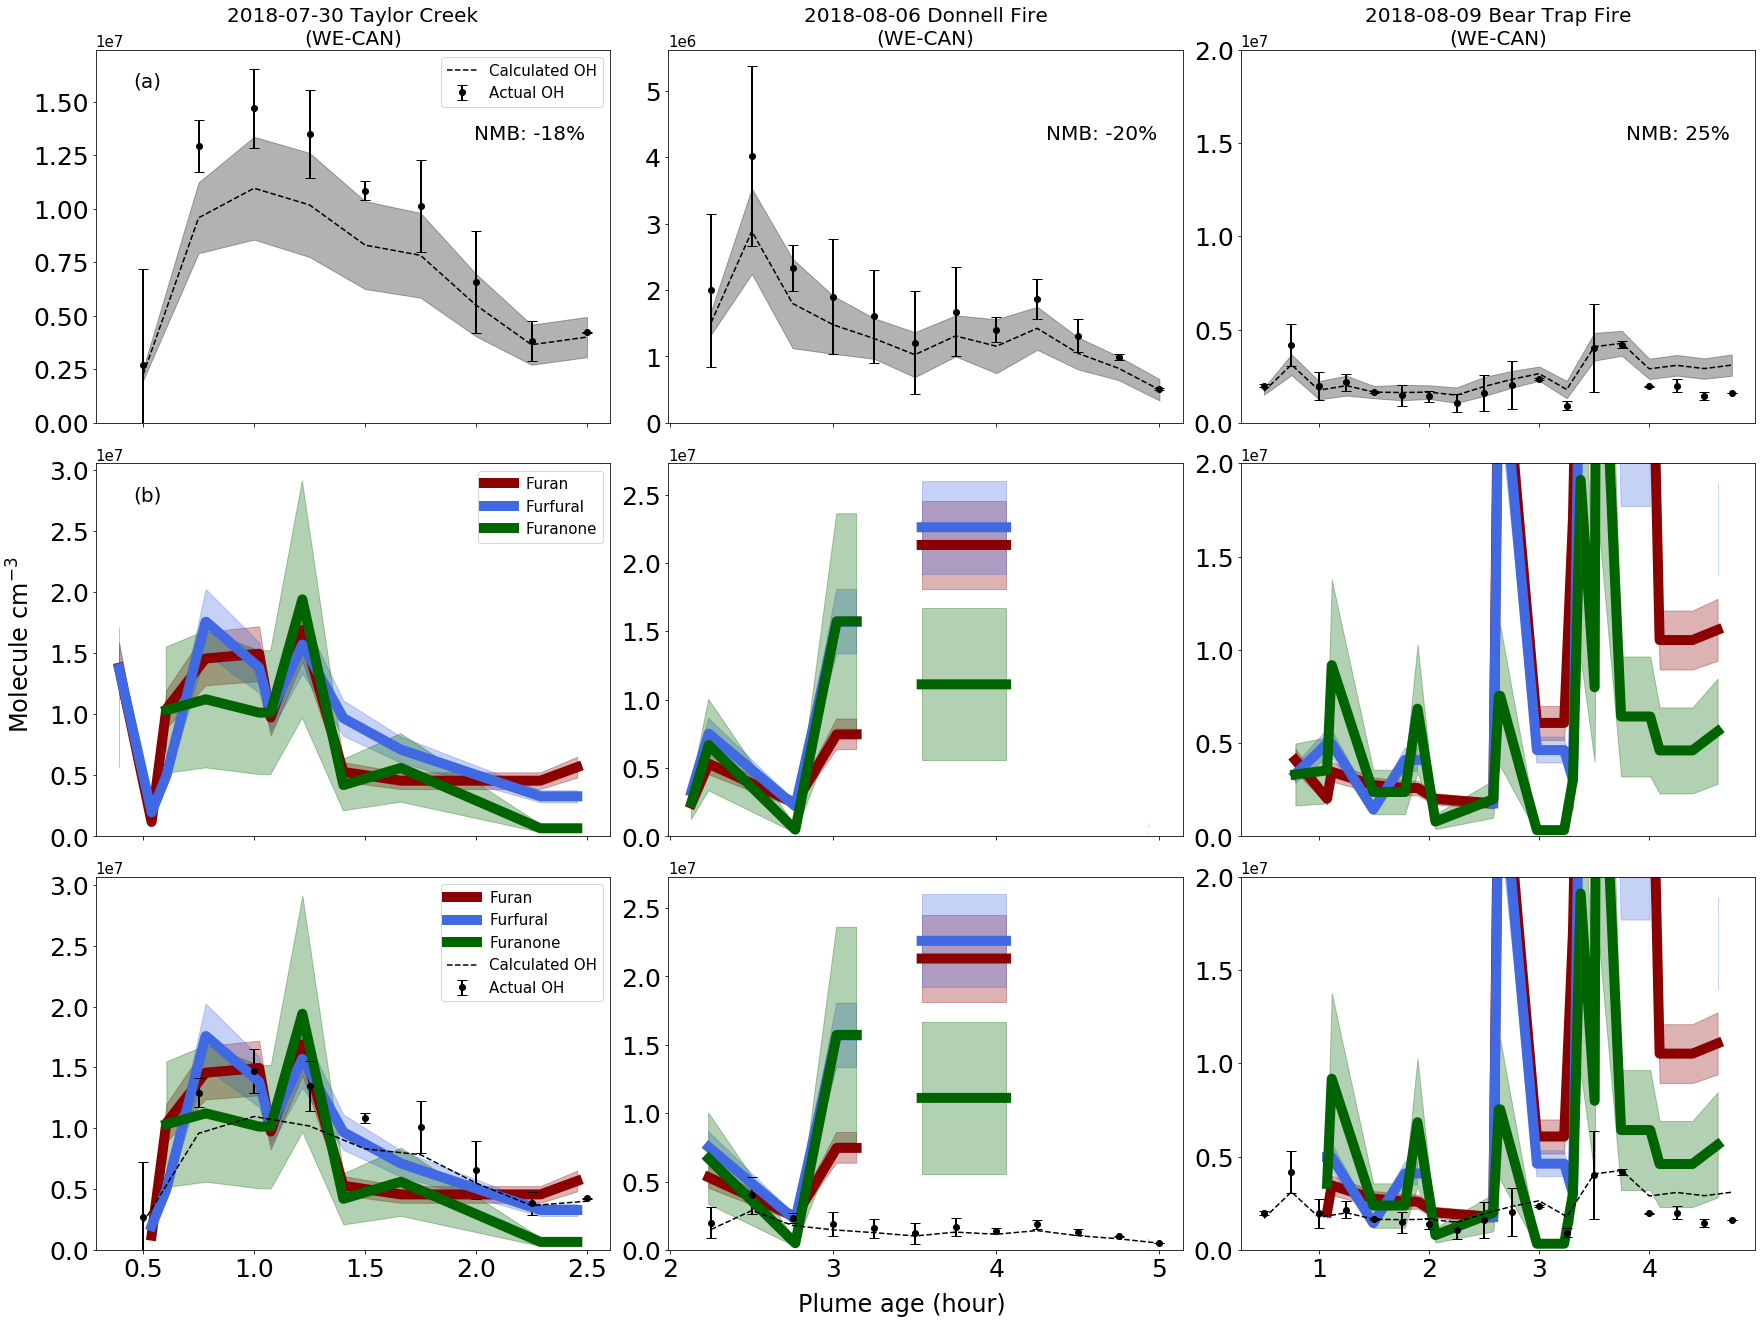

CV (within 2.5 hours): 33%
CV (after 2.5 hours): 55%


In [13]:
# -----------------
# Bin the data
# Put it above after
# ------------------
# set up the dataframe
df_OH_mod_mcm_bbvoc = all_data_mcm_bbvoc[['Flight_ID', 'Plume_Age', 'cal_OH_mean', 'cal_OH_median', 'cal_OH_std', 'cal_OH_iqr', 'output_OH']]
df_OH_obs = all_data_obs_combined[['Flight_ID', 'Plume_Age', 'cal_OH_mean', 'cal_OH_median', 'cal_OH_std', 'cal_OH_iqr', 'output_OH']]
df_OH_mod_mcm_bbvoc = df_OH_mod_mcm_bbvoc.set_index('Plume_Age')
df_OH_obs = df_OH_obs.set_index('Plume_Age')
# For model: create an empty DataFrame to store binned data
df_OH_mod_mcm_bbvoc_bin = pd.DataFrame()
# Iterate over unique 'Flight_ID' values and bin data for each
for flight_id in df_OH_mod_mcm_bbvoc['Flight_ID'].unique():
    # Filter data for the current 'Flight_ID'
    subset_df = df_OH_mod_mcm_bbvoc[df_OH_mod_mcm_bbvoc['Flight_ID'] == flight_id]
    # Use your bin_df function to bin the data for the current 'Flight_ID'
    binned_subset = bin_df(subset_df, 15/60)
    # Add a 'Flight_ID' column to the binned data
    binned_subset['Flight_ID'] = flight_id
    # Concatenate the binned data for the current 'Flight_ID' with the overall binned_data
    df_OH_mod_mcm_bbvoc_bin = pd.concat([df_OH_mod_mcm_bbvoc_bin, binned_subset])
# ===================================
# OH validation in two ways
# 1) [OH]cal vs actual OH from model
# 2) [OH]cal from different VOC pairs
# Supplement figure
# ===================================
# Common settings
Flight_IDs = ['RF03', 'RF07', 'RF09']
#Flight_IDs = ['RF03', 'RF07', 'RF09', 'P-3B', 'FN19',]
stat     = 'median'
stat_err = 'iqr'
# Define plot settings for each row
plot_settings = [
    {'Val_method': 'Cal vs Act'},
    {'Val_method': 'VOCs'},
    {'Val_method': 'Combined'},
]

# Initialize an empty list to store CV DataFrames
cv_dfs_list = []

fig, axes = plt.subplots(len(plot_settings), len(Flight_IDs), figsize=(8*len(Flight_IDs), 6*len(plot_settings)), sharex='col')
# Ensure axes is always a 2D array even if there's only one plot
axes = np.atleast_2d(axes)
for row, settings in enumerate(plot_settings):
    for col, Flight_ID in enumerate(Flight_IDs):
        ax = axes[row, col]
        if settings['Val_method'] == 'VOCs':
            flight_data = calOH_vocs_per_flight_obs[Flight_ID]
            # Replace the values in the second row with NaN for all columns
            #df.iloc[1] = np.nan
            time = flight_data['Avg_physical_age_min'] / 60  # Convert minutes to hours
            color_cycle = iter(colors)  # Create an iterator over the colors
            for comp in flight_data:
                if comp != 'Avg_physical_age_min': 
                    color = next(color_cycle, 'grey')  # Use grey if we run out of specified colors
                    ax.plot(time, flight_data[comp], label=comp,
                            color=color, linewidth=10)
                    ax.fill_between(time, flight_data[comp]*(1-name2uncertainty[comp]), flight_data[comp]*(1+name2uncertainty[comp]), color=color, alpha=0.3)
            # Calculate the coefficient of variance (CV) for the selected VOCs
            df_transposed  = flight_data.copy().set_index('Avg_physical_age_min').T
            cv_across_vocs = df_transposed.apply(lambda x: np.nanstd(x, ddof=1) / np.nanmean(x) * 100, axis=0)
            # Store the CV DataFrame
            cv_dfs_list.append(cv_across_vocs.to_frame(name=Flight_ID))
        elif settings['Val_method'] == 'Cal vs Act':
            df_OH_mod_mcm_bbvoc_bin_per_flight = df_OH_mod_mcm_bbvoc_bin[df_OH_mod_mcm_bbvoc_bin['Flight_ID'] == Flight_ID]  # Placeholder for actual data access
            # Line plot for output model data - Solid Line
            ax.errorbar(df_OH_mod_mcm_bbvoc_bin_per_flight.index, 
                        df_OH_mod_mcm_bbvoc_bin_per_flight[('output_OH', stat)], 
                        yerr=df_OH_mod_mcm_bbvoc_bin_per_flight[('output_OH', stat_err)], 
                        color='black', 
                        linewidth=2, linestyle='', capsize=5, marker='o', label='Actual OH')
            # Line plot for calculated model data - Dashed Line with shaded error
            x_values = df_OH_mod_mcm_bbvoc_bin_per_flight.index + 0 # + offset
            y_values = df_OH_mod_mcm_bbvoc_bin_per_flight[(f'cal_OH_{stat}', stat)]
            if stat == 'median': yerr = df_OH_mod_mcm_bbvoc_bin_per_flight[('cal_OH_iqr', stat)]
            if stat == 'mean': yerr = df_OH_mod_mcm_bbvoc_bin_per_flight[('cal_OH_std', stat)]
            ax.plot(x_values, y_values, color='black', label='Calculated OH', linestyle='--')
            ax.fill_between(x_values, y_values - yerr, y_values + yerr, color='black', alpha=0.3)
            # Calculate NMB
            nmb =np.mean((df_OH_mod_mcm_bbvoc_bin_per_flight[(f'cal_OH_{stat}', stat)] - df_OH_mod_mcm_bbvoc_bin_per_flight[('output_OH', stat)]) / df_OH_mod_mcm_bbvoc_bin_per_flight[('output_OH', stat)] * 100)
            # Annotate NMB on the plot
            ax.annotate(f'NMB: {nmb:.0f}%', xy=(0.95, 0.80), xycoords='axes fraction', ha='right', va='top', fontsize=20, color='black')
        elif settings['Val_method'] == 'Combined':
            # VOCs method
            flight_data = calOH_vocs_per_flight_obs[Flight_ID]
            flight_data.loc[1] = np.nan
            time = flight_data['Avg_physical_age_min'] / 60  # Convert minutes to hours
            color_cycle = iter(colors)  # Create an iterator over the colors
            for comp in flight_data:
                if comp != 'Avg_physical_age_min': 
                    color = next(color_cycle, 'grey')  # Use grey if we run out of specified colors
                    ax.plot(time, flight_data[comp], label=comp,
                            color=color, linewidth=10)
                    ax.fill_between(time, flight_data[comp]*(1-name2uncertainty[comp]), flight_data[comp]*(1+name2uncertainty[comp]), color=color, alpha=0.3)
            x_obs, y_obs = flight_data['Avg_physical_age_min']/60, flight_data.drop(columns=['Avg_physical_age_min']).median(axis=1)
            
            # Models
            df_OH_mod_mcm_bbvoc_bin_per_flight = df_OH_mod_mcm_bbvoc_bin[df_OH_mod_mcm_bbvoc_bin['Flight_ID'] == Flight_ID]  # Placeholder for actual data access
            # Line plot for output model data - Solid Line
            ax.errorbar(df_OH_mod_mcm_bbvoc_bin_per_flight.index, 
                        df_OH_mod_mcm_bbvoc_bin_per_flight[('output_OH', stat)], 
                        yerr=df_OH_mod_mcm_bbvoc_bin_per_flight[('output_OH', stat_err)], 
                        color='black', 
                        linewidth=2, linestyle='', capsize=5, marker='o', label='Actual OH')
            # Line plot for calculated model data - Dashed Line with shaded error
            x_values = df_OH_mod_mcm_bbvoc_bin_per_flight.index + 0 # + offset
            y_values = df_OH_mod_mcm_bbvoc_bin_per_flight[(f'cal_OH_{stat}', stat)]
            if stat == 'median': yerr = df_OH_mod_mcm_bbvoc_bin_per_flight[('cal_OH_iqr', stat)]
            if stat == 'mean': yerr = df_OH_mod_mcm_bbvoc_bin_per_flight[('cal_OH_std', stat)]
            ax.plot(x_values, y_values, color='black', label='Calculated OH', linestyle='--')
            x_mod,y_mod  = x_values, y_values

            #--------------------------------------
            # Create a polynomial regression model
            #--------------------------------------
            # Fit polynomial regression model on valid observational data where x < 2.5
            valid_obs_indices_less = (~np.isnan(x_obs) & ~np.isnan(y_obs) & (x_obs < 2.5))
            x_obs_valid_less, y_obs_valid_less = x_obs[valid_obs_indices_less], y_obs[valid_obs_indices_less]
            poly_model_less = make_pipeline(PolynomialFeatures(2), LinearRegression())
            poly_model_less.fit(x_obs_valid_less.values.reshape(-1, 1), y_obs_valid_less.values)

            valid_mod_indices_less = (x_mod < 2.5)
            x_mod_valid_less, y_mod_valid_less = x_mod[valid_mod_indices_less], y_mod[valid_mod_indices_less]
            y_predicted_less = poly_model_less.predict(x_mod_valid_less.values.reshape(-1, 1))
            
            nmb_mcm_bbvoc_less = 100 * (np.nanmedian(y_mod_valid_less) - np.nanmedian(y_predicted_less)) / np.nanmedian(y_predicted_less)
            print(f'NMB MCM_BB_VOC for {Flight_ID} (x < 2.5): {nmb_mcm_bbvoc_less:.2f}%')
            
            # Check if there are valid samples for x > 2.5
            valid_obs_indices_more = (~np.isnan(x_obs) & ~np.isnan(y_obs) & (x_obs > 2.5))
            if valid_obs_indices_more.any():
                x_obs_valid_more, y_obs_valid_more = x_obs[valid_obs_indices_more], y_obs[valid_obs_indices_more]
                poly_model_more = make_pipeline(PolynomialFeatures(2), LinearRegression())
                poly_model_more.fit(x_obs_valid_more.values.reshape(-1, 1), y_obs_valid_more.values)
            
                valid_mod_indices_more = (x_mod > 2.5)
                x_mod_valid_more, y_mod_valid_more = x_mod[valid_mod_indices_more], y_mod[valid_mod_indices_more]
                y_predicted_more = poly_model_more.predict(x_mod_valid_more.values.reshape(-1, 1))
            
                nmb_mcm_bbvoc_more = 100 * (np.nanmedian(y_mod_valid_more) - np.nanmedian(y_predicted_more)) / np.nanmedian(y_predicted_more)
                print(f'NMB MCM_BB_VOC for {Flight_ID} (x > 2.5): {nmb_mcm_bbvoc_more:.2f}%')
            else:
                print(f'No valid observational data for {Flight_ID} where x > 2.5')
                                
        # General setting for the figure
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax.tick_params(axis='both', which='major', labelsize=25)
        ax.yaxis.get_offset_text().set_fontsize(15)
        
        # Set the lower limit of y-axis to 0
        ax.set_ylim(bottom=0)
        if Flight_ID == 'RF09':ax.set_ylim(top=2E7)
            
        if row == 0: ax.set_title(id2fire_name.get(Flight_ID, Flight_ID), fontsize=20)
        if col == 0: ax.legend(fontsize=15)
            
        # Add specified texts as transparent boxes
        bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="white", lw=2, alpha=0.5)
        if row == 0 and col == 0:
            #ax.text(0.2, 0.9, 'Observed Cal OH', transform=ax.transAxes, fontsize=15, ha='center', bbox=bbox_props)
            ax.text(0.1, 0.9, '(a)', transform=ax.transAxes, fontsize=20, ha='center')
        if row == 1 and col == 0:
            #ax.text(0.2, 0.9, 'Cal vs Actual OH', transform=ax.transAxes, fontsize=15, ha='center', bbox=bbox_props)
            ax.text(0.1, 0.9, '(b)', transform=ax.transAxes, fontsize=20, ha='center')
# Adjust layout
plt.tight_layout()
# Set common x and y labels
fig.text(0.5, -0.01, 'Plume age (hour)', ha='center', va='center', fontsize=24)
fig.text(-0.01, 0.5, 'Molecule cm$^{-3}$', ha='center', va='center', rotation='vertical', fontsize=24)

# Save the figure
plt.savefig('/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/VOC_OH_exposure/output/OH_evaluation.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

# ------------
# Print output
# ------------
# Combine all CV DataFrames
combined_cv_df = pd.concat(cv_dfs_list, axis=1)
# Combine all CV DataFrames into one column per flight
# Ensure no repeated index
combined_cv_df = combined_cv_df.sort_index().reindex(pd.Index(sorted(set(combined_cv_df.index))))
# Combine into a single column DataFrame by stacking and dropping NaNs
combined_cv_single_column = combined_cv_df.stack().reset_index(level=1, drop=True).to_frame(name='CV')
within_2_5_hours = combined_cv_single_column[combined_cv_single_column.index <= 150]
after_2_5_hours = combined_cv_single_column[combined_cv_single_column.index > 150]
# Calculate and print the mean CV for each subset
print(f'CV (within 2.5 hours): {within_2_5_hours["CV"].mean():.0f}%')
print(f'CV (after 2.5 hours): {after_2_5_hours["CV"].mean():.0f}%')

In [14]:
# -----------------------------------------------------------------
# How many HONO will be consumed with the first hour of plume aging?
# -----------------------------------------------------------------
# Set up a 1x1 figure
fig, axes = plt.subplots(1, 4, figsize=(8*4, 6*1), sharex=True)
# Select variable
var_x, var_y = 'Plume_Age', 'NEMR_HONO'
plot_data_helper('Flight_ID', var_x, var_y,  axes[0], '', set_xlabel=True, set_ylabel=True, show_legend=True)
'''
var_x, var_y = 'Plume_Age', 'VOCR: CO'
plot_data_helper('Flight_ID', var_x, var_y,  axes[1], '', set_xlabel=True, set_ylabel=True, show_legend=True)
var_x, var_y = 'Plume_Age', 'NOx: CO'
plot_data_helper('Flight_ID', var_x, var_y,  axes[2], '', set_xlabel=True, set_ylabel=True, show_legend=True)
var_x, var_y = 'Plume_Age', 'OHRnox: OHRvoc'
plot_data_helper('Flight_ID', var_x, var_y,  axes[3], '', set_xlabel=True, set_ylabel=True, show_legend=True)
'''
# Close the figure to prevent it from being displayed
plt.close()

The consumed HONO in the first hour: 75.6±22.8%
The consumed HONO in the second hour: 84.3±13.1%

NEMR_HONO vs Plume_Age (NMB)
      $MCM_{BBVOC}$  $MCM_{GCVOC}$  GC
P-3B            -91            -89 -90
RF03            -13            -13 -11
RF07            -98            -98 -96
RF09            -99            -98 -96
FN19            -63            -58 -61


In [15]:
# Design a function to include the old cal OH as well.

Time Frame: initial 40 minutes hour
The mean/std value (1E6 molec/cm3): 39.5±61.7
The median/iqr value (1E6 molec/cm3): 17.3±14.6

Calculating for Flight ID: FN19 for the initial 40 minutes
Time Frame: initial 40 minutes hour
The mean/std value (1E6 molec/cm3): 4.2±nan
The median/iqr value (1E6 molec/cm3): 4.2±0.0

Calculating for Flight ID: P-3B for the initial 40 minutes
Time Frame: initial 40 minutes hour
The mean/std value (1E6 molec/cm3): 22.5±5.6
The median/iqr value (1E6 molec/cm3): 22.4±4.5

Calculating for Flight ID: RF03 for the initial 40 minutes
Time Frame: initial 40 minutes hour
The mean/std value (1E6 molec/cm3): 7.7±5.8
The median/iqr value (1E6 molec/cm3): 8.6±5.7

Calculating for Flight ID: RF09 for the initial 40 minutes
Time Frame: initial 40 minutes hour
The mean/std value (1E6 molec/cm3): nan±nan
The median/iqr value (1E6 molec/cm3): nan±nan

Skipping RF07 for the initial 40 minutes because the data is empty.
Time Frame: 1 hour
The mean/std value (1E6 molec/cm3): 

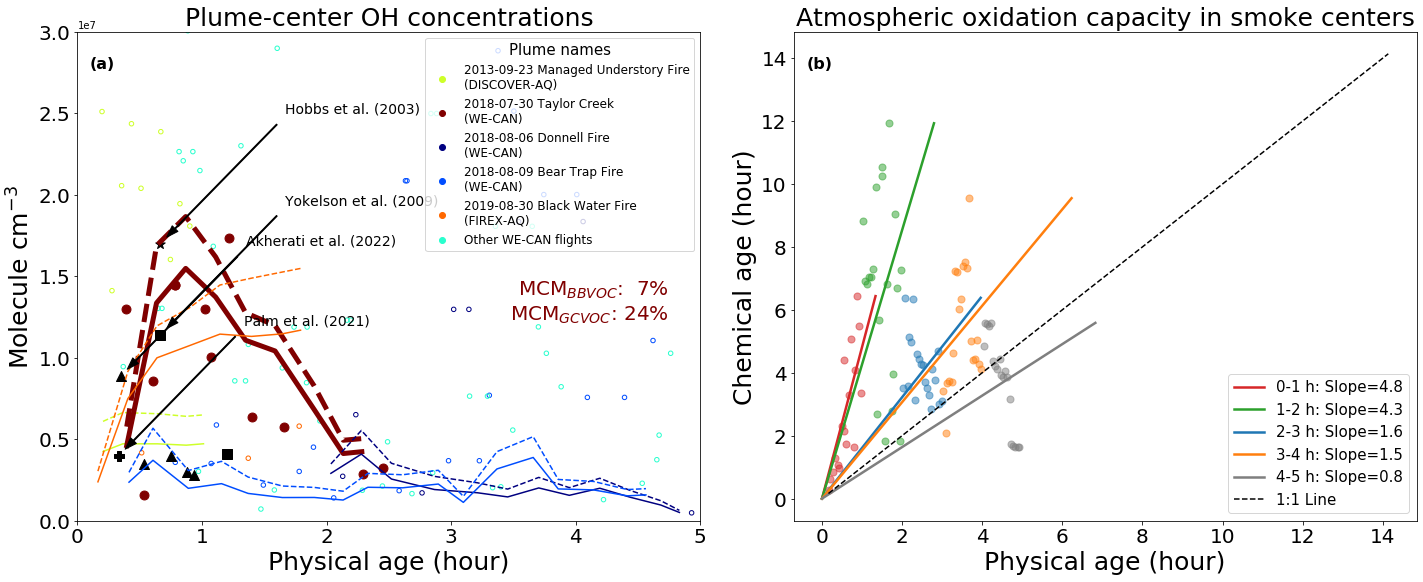

In [16]:
# Plotting
# Set up a 1x1 figure
fig, axes = plt.subplots(1, 2, figsize=(12*2, 9), sharey=False)
# ==================================================
# Calculated OH concentration vs direct model output
# Maintext figure
# Analysis in the maintext
# ==================================================
# Select variable
var_x_obs, var_y_obs = 'Plume_Age', 'cal_OH_mean'
var_x_mod, var_y_mod = 'Plume_Age', 'output_OH'
group_column = 'Flight_ID'
set_ylabel=True
show_legend=True
title = 'Plume-center OH concentrations'
# Legend
legend_title = 'Flight ID'
show_legend  = True
# The slope of NEMR O3 vs plume age
mean_lagrangian = []
nmb_values_mcm_bbvoc = {}
nmb_values_mcm_gcvoc = {}
nmb_values_gc = {}
nmb_values_voc_numbers = {}
nmb_values_mechanisms  = {}
color_flight = {}
# Set up colors
unique_groups = all_data_obs_combined['Flight_ID'].unique()
unique_groups = np.array(['P-3B', 'RF03', 'RF07', 'RF09', 'FN19', 'Other WE-CAN flights'])

if len(unique_groups) == 6:
    group_colors = np.array([
        [0.80645161, 1.0, 0.16129032, 1.0],
        [0.5, 0.0, 0.0, 1.0],
        [0.0, 0.0, 0.5, 1.0],
        [0.0, 0.3, 1.0, 1.0],
        [1.0, 0.40740741, 0.0, 1.0],
        [0.16129032, 1.0, 0.80645161, 1.0],
    ])


for idx, group in enumerate(unique_groups):
    '''
    # Skip P-3B for calculated chemical age
    if group == 'P-3B' and conditions:
        print('skip P-3B for its unresonable chemical age')
        continue
    '''
    group_data_obs  = all_data_obs_combined[all_data_obs_combined[group_column] == group]
    group_data_obs  = group_data_obs.dropna(subset=[var_x_obs, var_y_obs])
    x_obs, y_obs    = (group_data_obs[var_x_obs]).astype(float), (group_data_obs[var_y_obs]).astype(float)
    valid_indices = ~np.isnan(x_obs) & ~np.isnan(y_obs)

    # Plot observational data if available
    if valid_indices.any():
        # Determine if the circle should be solid or open based on the flight
        face_color = group_colors[idx]
        # Plot dots even they are not in Lagrangian flights
        if group_column == 'Flight_ID': 
            '''
            face_color = group_colors[idx] if group in Lagrangian_flights else "none" 
            axes.scatter(x_obs[valid_indices], y_obs[valid_indices], edgecolors=group_colors[idx], facecolors=face_color, label=id2fire_name.get(group,group))
            '''
            # Determine the face color based on the flight
            edge_color = group_colors[idx]  # Color from your color map
            if group == 'RF03':  # Specific condition for Taylor Creek Fire
                face_color  = edge_color  # Use the edge color to fill markers
                marker_size = 80  # Adjust this value as needed
                linewidth = 5
            else:
                face_color = "none"  # This makes scatter plot markers hollow
                marker_size = 20  # Adjust this value as needed
                linewidth = 1.5

            # Plot actual scatter data with hollow markers
            axes[0].scatter(x_obs[valid_indices], y_obs[valid_indices], edgecolors=edge_color, facecolors=face_color, label='_nolegend_', s=marker_size)
    
            # Plot dummy scatter just for creating the legend entry
            axes[0].scatter([], [], edgecolors=edge_color, facecolors=edge_color, label=id2fire_name.get(group, group))

        
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x_obs[valid_indices], y_obs[valid_indices])

    # Group model results with flight ID instead.
    if (group_column == 'Flight_ID') and (group in Lagrangian_flights):
        group_data_mcm_bbvoc  = all_data_mcm_bbvoc[all_data_mcm_bbvoc[group_column] == group]
        group_data_mcm_gcvoc  = all_data_mcm_gcvoc[all_data_mcm_gcvoc[group_column] == group]
        group_data_gc         = all_data_gc[all_data_gc[group_column] == group]
        # Binning the data based on time for every 15 minutes and averaging each bin
        # Assuming Plume_Age is in hours, 0.25 hours is equivalent to 15 minutes
        bin_size = 0.25  # 15 minutes in hours
        group_data_mcm_bbvoc['Time_Bin'] = (group_data_mcm_bbvoc['Plume_Age'] // bin_size) * bin_size
        group_data_mcm_gcvoc['Time_Bin'] = (group_data_mcm_gcvoc['Plume_Age'] // bin_size) * bin_size
        group_data_gc['Time_Bin']        = (group_data_gc['Plume_Age'] // bin_size) * bin_size
        group_data_mcm_bbvoc_binned      = group_data_mcm_bbvoc.groupby('Time_Bin').mean()
        group_data_mcm_gcvoc_binned      = group_data_mcm_gcvoc.groupby('Time_Bin').mean()
        group_data_gc_binned             = group_data_gc.groupby('Time_Bin').mean()

        x_mcm_bbvoc, y_mcm_bbvoc = (group_data_mcm_bbvoc_binned[var_x_mod]).astype(float), (group_data_mcm_bbvoc_binned[var_y_mod]).astype(float)
        x_mcm_gcvoc, y_mcm_gcvoc = (group_data_mcm_gcvoc_binned[var_x_mod]).astype(float), (group_data_mcm_gcvoc_binned[var_y_mod]).astype(float)
        x_gc, y_gc               = (group_data_gc_binned[var_x_mod]).astype(float), (group_data_gc_binned[var_y_mod]).astype(float)

        valid_indices_mod = ~np.isnan(x_mcm_bbvoc) & ~np.isnan(y_mcm_bbvoc) & \
                            ~np.isnan(x_mcm_gcvoc) & ~np.isnan(y_mcm_gcvoc) & \
                            ~np.isnan(x_gc) & ~np.isnan(y_gc)

        x_mcm_bbvoc, y_mcm_bbvoc = x_mcm_bbvoc[valid_indices_mod], y_mcm_bbvoc[valid_indices_mod]
        x_mcm_gcvoc, y_mcm_gcvoc = x_mcm_gcvoc[valid_indices_mod], y_mcm_gcvoc[valid_indices_mod]
        x_gc, y_gc               = x_gc[valid_indices_mod],y_gc [valid_indices_mod]

        # Add solid lines for model output
        if valid_indices_mod.any():
            axes[0].plot(x_mcm_bbvoc, y_mcm_bbvoc, color = group_colors[idx], linestyle='-', linewidth = linewidth)
            axes[0].plot(x_mcm_gcvoc, y_mcm_gcvoc, color = group_colors[idx], linestyle='--', linewidth = linewidth)
        else:
            axes[0].plot(x_mcm_bbvoc, y_mcm_bbvoc, color = group_colors[idx], linestyle='-', label=id2fire_name.get(group,group), linewidth = linewidth)
            axes[0].plot(x_mcm_gcvoc, y_mcm_gcvoc, color = group_colors[idx], linestyle='--', label=id2fire_name.get(group,group), linewidth = linewidth)
        # ------------------------
        # Calculate the model error
        # -------------------------
        # Only when observation exists
        if valid_indices.any():
            # Define the degree of the polynomial model       
            degree = 2 if group!='FN19' else 1
            # Create a polynomial regression model
            poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
            # Fit the polynomial regression model on observational data
            poly_model.fit(x_obs[valid_indices].values.reshape(-1, 1), y_obs[valid_indices].values)
            # Predict VOCR using the regression model at the MCM_BB_VOC time points
            x_model       = x_mcm_bbvoc
            y_predicted   = poly_model.predict(x_model.values.reshape(-1, 1))
        # Using mcmbbvoc as the observation
        else:
            y_predicted = y_mcm_bbvoc
        # Calculate Normalized Median Bias (NMB)
        nmb_mcm_bbvoc   = 100 * (np.nanmedian(y_mcm_bbvoc) - np.nanmedian(y_predicted)) / np.nanmedian(y_predicted)
        nmb_mcm_gcvoc   = 100 * (np.nanmedian(y_mcm_gcvoc) - np.nanmedian(y_predicted)) / np.nanmedian(y_predicted)
        nmb_gc          = 100 * (np.nanmedian(y_gc) - np.nanmedian(y_predicted)) / np.nanmedian(y_predicted)
        # Calculate differences among models
        nmb_voc_numbers = 100 * (np.nanmedian(y_mcm_gcvoc) - np.nanmedian(y_mcm_bbvoc)) / np.nanmedian(y_mcm_bbvoc)
        nmb_mechanisms  = 100 * (np.nanmedian(y_gc) - np.nanmedian(y_mcm_gcvoc)) / np.nanmedian(y_mcm_gcvoc)
        
        # After calculating NMB
        nmb_values_mcm_bbvoc[group]  = nmb_mcm_bbvoc
        nmb_values_mcm_gcvoc[group]  = nmb_mcm_gcvoc
        nmb_values_gc[group]         = nmb_gc
        nmb_values_voc_numbers[group]= nmb_voc_numbers
        nmb_values_mechanisms[group] = nmb_mechanisms
        color_flight[group]          = group_colors[idx]

    # Defalt setting for title, ticks, and labels
    axes[0].set_xlabel(text_labels.get(var_x_obs, var_x_obs), fontsize=25)
    axes[0].set_ylabel(text_labels.get(var_y_obs, var_y_obs), fontsize=25)
    axes[0].set_title(title, fontsize=25)
    axes[0].tick_params(axis='both', labelsize=20)
    axes[0].set_ylim(0, 3E7)  # Set y limits from min y to calculated upper limit
    # Set the x-axis limit
    axes[0].set_xlim([0, 5])  # None means no lower limit, 8 is the upper limit

    # Legend        
    if show_legend:
        if group_column == 'Flight_ID':
            desired_order = desired_order_flights
            reorder_legend(axes[0], desired_order, id2fire_name, legend_title='Plume names', fontsize=12, title_fontsize = 15, legend_loc='upper right')

# -------------------
# Annotation settings
# -------------------
# Calculate median and interquartile range (IQR)
nmb_values_mcm_bbvoc_array   = np.array(list(nmb_values_mcm_bbvoc.values()), dtype=np.float)
nmb_values_mcm_gcvoc_array   = np.array(list(nmb_values_mcm_gcvoc.values()), dtype=np.float)
nmb_values_gc_array          = np.array(list(nmb_values_gc.values()), dtype=np.float)
nmb_values_voc_numbers_array = np.array(list(nmb_values_voc_numbers.values()), dtype=np.float)
nmb_values_mechanisms_array  = np.array(list(nmb_values_mechanisms.values()), dtype=np.float)

median_mcm_bbvoc, q1_mcm_bbvoc, q3_mcm_bbvoc       = np.nanmedian(nmb_values_mcm_bbvoc_array), np.nanpercentile(nmb_values_mcm_bbvoc_array, 25), np.nanpercentile(nmb_values_mcm_bbvoc_array, 75)
median_mcm_gcvoc, q1_mcm_gcvoc, q3_mcm_gcvoc       = np.nanmedian(nmb_values_mcm_gcvoc_array), np.nanpercentile(nmb_values_mcm_gcvoc_array, 25), np.nanpercentile(nmb_values_mcm_gcvoc_array, 75)
median_gc, q1_gc, q3_gc                            = np.nanmedian(nmb_values_gc_array), np.nanpercentile(nmb_values_gc_array, 25), np.nanpercentile(nmb_values_gc_array, 75)
median_voc_numbers, q1_voc_numbers, q3_voc_numbers = np.nanmedian(nmb_values_voc_numbers_array), np.nanpercentile(nmb_values_voc_numbers_array, 25), np.nanpercentile(nmb_values_voc_numbers_array, 75)
median_mechanisms, q1_mechanisms, q3_mechanisms    = np.nanmedian(nmb_values_mechanisms_array), np.nanpercentile(nmb_values_mechanisms_array, 25), np.nanpercentile(nmb_values_mechanisms_array, 75)

iqr_mcm_bbvoc   = q3_mcm_bbvoc - q1_mcm_bbvoc
iqr_mcm_gcvoc   = q3_mcm_gcvoc - q1_mcm_gcvoc
iqr_gc          = q3_gc - q1_gc
iqr_voc_numbers = q3_voc_numbers - q1_voc_numbers
iqr_mechanisms  = q3_mechanisms - q1_mechanisms
# Calculate mean and standard deviation
mean_mcm_bbvoc, std_mcm_bbvoc     = np.nanmean(nmb_values_mcm_bbvoc_array), np.nanstd(nmb_values_mcm_bbvoc_array)
mean_mcm_gcvoc, std_mcm_gcvoc     = np.nanmean(nmb_values_mcm_gcvoc_array), np.nanstd(nmb_values_mcm_gcvoc_array)
mean_gc, std_gc                   = np.nanmean(nmb_values_gc_array), np.nanstd(nmb_values_gc_array)
mean_voc_numbers, std_voc_numbers = np.nanmean(nmb_values_voc_numbers_array), np.nanstd(nmb_values_voc_numbers_array)
mean_mechanisms, std_mechanisms   = np.nanmean(nmb_values_mechanisms_array), np.nanstd(nmb_values_mechanisms_array)

'''
# Annotate mean ± std in each subplot
# Determine if we want to show bias for each individual flights or the average of flights.
xy, ha, va, color =(0.95, 0.50), 'right', 'bottom', 'black'
axes.annotate(f"NMB:({median_mcm_bbvoc:.0f}±{iqr_mcm_bbvoc:.0f})%", 
             xy=xy,  # Position of the annotation
             xycoords='axes fraction',
             ha=ha, va=va,  # Alignment of the text
             fontsize=20,  # Font size of the text
             color=color)  # Color of the text
'''


# Desired order of keys
desired_order = ['P-3B', 'RF03', 'RF07', 'RF09', 'FN19']
# Desired order of keys
nmb_values_mcm_bbvoc_ordered   = OrderedDict((key, nmb_values_mcm_bbvoc[key]) for key in desired_order if key in nmb_values_mcm_bbvoc)
nmb_values_mcm_gcvoc_ordered   = OrderedDict((key, nmb_values_mcm_gcvoc[key]) for key in desired_order if key in nmb_values_mcm_gcvoc)
nmb_values_voc_numbers_ordered = OrderedDict((key, nmb_values_voc_numbers[key]) for key in desired_order if key in nmb_values_voc_numbers)
nmb_values_mechanisms_ordered  = OrderedDict((key, nmb_values_mechanisms[key]) for key in desired_order if key in nmb_values_mechanisms)
'''
# Annotations
axes.annotate(f'$MCM_{{BBVOC}}$',
            xy=(0.95, start_y+0.05),  # Position of the annotation
            xycoords='axes fraction',
            ha='right', va='bottom',  # Alignment of the text
            fontsize=20,  # Font size of the text
            color='black')  # Color of the text, + 1 to skip P-3B
'''
for idx, group in enumerate(nmb_values_mcm_bbvoc_ordered):
    # Extract the name and perform the split operation outside the f-string
    nmb_value_mcm_bbvoc   = nmb_values_mcm_bbvoc_ordered[group]
    nmb_value_mcm_gcvoc   = nmb_values_mcm_gcvoc_ordered[group]
    nmb_value_voc_numbers = nmb_values_voc_numbers_ordered[group]
    nmb_value_mechanisms  = nmb_values_mechanisms_ordered[group]
    color     = color_flight[group]
    # Check if the group requires a box
    if group in ['FN19', 'RF03']:
        bbox_props = dict(boxstyle="round,pad=0.1", fc="none", lw=2, ec=color, alpha=0.7)
    else:
        bbox_props = None
    '''
    axes.annotate(f'{nmb_value_mcm_bbvoc:.0f}%, {nmb_value_mcm_gcvoc:.0f}%',
                xy=(0.95, start_y-idx*0.05),  # Position of the annotation
                xycoords='axes fraction',
                ha='right', va='bottom',  # Alignment of the text
                fontsize=20,  # Font size of the text
                color=color,   # Color of the text, + 1 to skip P-3B
                bbox=bbox_props)  # Apply box properties if specified
    '''
    '''
    axes.annotate(f'{nmb_value_mcm_bbvoc:.0f}%',
                xy=(0.95, start_y-idx*0.05),  # Position of the annotation
                xycoords='axes fraction',
                ha='right', va='bottom',  # Alignment of the text
                fontsize=20,  # Font size of the text
                color=color)
    '''
# Assuming you want to align floating-point numbers with up to 1 decimal place
max_width = 2  # total digits for integer part
decimal_places = 0  # digits after decimal
start_y = 0.45
    
axes[0].annotate(f"MCM$_{{BBVOC}}$: {nmb_values_mcm_bbvoc_ordered['RF03']:>{max_width}.{decimal_places}f}%",
              xy=(0.95, start_y),  # Position of the annotation
              xycoords='axes fraction',
              ha='right', va='bottom',  # Alignment of the text
              fontsize=20,  # Font size of the text
              color=color_flight['RF03'])

axes[0].annotate(f"MCM$_{{GCVOC}}$: {nmb_values_mcm_gcvoc_ordered['RF03']:>{max_width}.{decimal_places}f}%",
              xy=(0.95, start_y-0.05),  # Position of the annotation
              xycoords='axes fraction',
              ha='right', va='bottom',  # Alignment of the text
              fontsize=20,  # Font size of the text
              color=color_flight['RF03'])

# --------------------
# Reference datapoints
# --------------------
x_points = [40/60, 40/60, 1.2, 20/60, 21/60, 45/60, 53/60, 56/60, 32/60]
y_points = [1.7E7, 1.14E7, 4.1E6, 4E6, 8.9E6, 4E6, 3E6, 2.8E6, 3.5E6]
labels = ['Hobbs et al. (2003)', 'Yokelson et al. (2009)', 'Yokelson et al. (2009)', 'Palm et al. (2021)', 'Akherati et al. (2022)', 'Akherati et al. (2022)', 'Akherati et al. (2022)', 'Akherati et al. (2022)', 'Akherati et al. (2022)']
markers = ['*', 's', 's', 'P', '^', '^', '^', '^', '^']
# Track labels that have been annotated
annotated_labels = set()
# Plot each point using corresponding marker and size
for xp, yp, label, marker in zip(x_points, y_points, labels, markers):
    axes[0].scatter(xp, yp, marker=marker, color='black', s=100, label='_nolegend_')  # Use corresponding marker
    # Annotate the first occurrence of each label with text and a longer arrow
    if label not in annotated_labels:
        axes[0].annotate(label, 
                    #xy=(xp, yp), xytext=(xp + 2, yp+8E6), 
                    xy=(xp, yp), xytext=(xp + 1, yp+8E6), 
                    textcoords='data', fontsize=14, 
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                    ha='left')
        annotated_labels.add(label)  # Mark label as annotated

# --------------------
# Print out analysis
# Maintext analysis
# --------------------
# Function to calculate statistics for each hour time frame
def calculate_statistics(filtered_data_obs, var_x_obs, var_y_obs, hour):
    # Calculate the slope
    slope_obs, intercept_obs, r_value_obs, p_value_obs, std_err_obs = linregress(filtered_data_obs[var_x_obs].astype(float), filtered_data_obs[var_y_obs].astype(float))
    # Calculate the mean values and std err within the timeframe
    mean_value, std_dev = filtered_data_obs[var_y_obs].mean(), filtered_data_obs[var_y_obs].std()
    median_value, iqr_val = filtered_data_obs[var_y_obs].median(), iqr(filtered_data_obs[var_y_obs])
    # Print the mean and standard deviation
    print(f'Time Frame: {hour} hour')
    print(f'The mean/std value (1E6 molec/cm3): {mean_value/1E6:.1f}±{std_dev/1E6:.1f}')
    print(f'The median/iqr value (1E6 molec/cm3): {median_value/1E6:.1f}±{iqr_val/1E6:.1f}')
    print()


# The observed OH concentration over the initial 40 minutes
initial_minutes = 40 / 60  # Convert 40 minutes into hours for comparison with Plume_Age in hours
# Filter data for the initial 40 minutes
filtered_data_obs = all_data_obs_combined[(all_data_obs_combined[var_x_obs] <= initial_minutes)]
filtered_data_obs = filtered_data_obs.dropna(subset=[var_y_obs])
# Check if the DataFrame is not empty before proceeding
if not filtered_data_obs.empty:
    # Calculate statistics for the initial 40 minutes
    calculate_statistics(filtered_data_obs, var_x_obs, var_y_obs, "initial 40 minutes")
else:
    print("No data available for the initial 40 minutes.")
# Calculate it for each flight
for flight_id in df_OH_mod_mcm_bbvoc['Flight_ID'].unique():
    all_data_obs_combined_each = all_data_obs_combined[all_data_obs_combined['Flight_ID'] == flight_id]
    filtered_data_obs_each = all_data_obs_combined_each[all_data_obs_combined_each[var_x_obs] <= initial_minutes]
    # Check if the DataFrame is empty
    if not filtered_data_obs_each.empty:
        print(f"Calculating for Flight ID: {flight_id} for the initial 40 minutes")
        calculate_statistics(filtered_data_obs_each, var_x_obs, var_y_obs, "initial 40 minutes")
    else:
        print(f"Skipping {flight_id} for the initial 40 minutes because the data is empty.")

# The observed OH concentration over time
for hour in range(1, 6):
    # Filter data for the current time frame
    filtered_data_obs = all_data_obs_combined[(all_data_obs_combined[var_x_obs] > (hour - 1)) & (all_data_obs_combined[var_x_obs] < hour)]
    filtered_data_obs = filtered_data_obs.dropna(subset=[var_y_obs])
    # Calculate statistics for the current time frame
    calculate_statistics(filtered_data_obs, var_x_obs, var_y_obs, hour)

    # Calculate it for each flight
    for flight_id in df_OH_mod_mcm_bbvoc['Flight_ID'].unique():
        all_data_obs_combined_each = all_data_obs_combined[all_data_obs_combined['Flight_ID'] == flight_id]
        filtered_data_obs_each     = all_data_obs_combined_each[(all_data_obs_combined_each[var_x_obs] > (hour - 1)) & (all_data_obs_combined_each[var_x_obs] < hour)]
        # Check if the DataFrame is empty
        if not filtered_data_obs_each.empty:
            print(flight_id)
            calculate_statistics(filtered_data_obs_each, var_x_obs, var_y_obs, hour)
        else:
            print(f"Skipping {flight_id} at hour {hour} because the data is empty.")

# The model differences among model simulations
# Print the mean +/- std
print('Model differences among three model simulations')
print(f'Mean ± Std (VOC init) : {nmb_values_voc_numbers_array.mean():.0f} ± {nmb_values_voc_numbers_array.std():.0f}')
print(f'Mean ± Std (mechanism): {nmb_values_mechanisms_array.mean():.0f} ± {nmb_values_mechanisms_array.std():.0f}')


# ----------------------------
# Chemical age vs Physical age
# ----------------------------
# Define age segments and corresponding colors
# Define age segments and corresponding colors
age_segments = [(0, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3), (3, np.inf)]
age_segments = [(0,  1), (1, 2), (2, 3), (3, 4), (4, 5), (5, np.inf)]
colors       = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:grey']

# Set up figure and axes
var_x = 'Plume_Age'
var_y = 'output_chem_age'
clean_data = all_data_mcm_bbvoc.dropna(subset=[var_x, var_y])

# Find the overall range for plotting the 1:1 line
min_val = min(clean_data[var_x].min(), clean_data[var_y].min())
max_val = max(clean_data[var_x].max(), clean_data[var_y].max())

# Loop through each age segment
for (start, end), color in zip(age_segments, colors):
    segment = clean_data[(clean_data[var_x] >= start) & (clean_data[var_x] < end)]
    bin_size = 0.05  # 15 minutes in hours, adjust if needed
    segment['Time_Bin'] = (segment[var_x] // bin_size) * bin_size
    segment_binned = segment.groupby('Time_Bin').mean()

    axes[1].scatter(segment_binned[var_x], segment_binned[var_y], color=color, alpha=0.5, s=50)

    if not segment.empty:
        X = segment_binned[var_x].values.reshape(-1, 1)
        y = segment_binned[var_y].values
        model = LinearRegression(fit_intercept=False)
        model.fit(X, y)
        slope = model.coef_[0]

        label = f'>{start} h: Slope={slope:.1f}' if np.isinf(end) else f'{start}-{end} h: Slope={slope:.1f}'
        y_vals = np.linspace(0, segment_binned[var_y].max(), 100)
        x_vals = y_vals / slope
        axes[1].plot(x_vals, y_vals, color=color, label=label, linewidth=2.5)

# Add the 1:1 line
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 Line')
axes[1].tick_params(axis='both', which='major', labelsize=20)
axes[1].set_xlabel('Physical age (hour)', fontsize=25)
axes[1].set_ylabel('Chemical age (hour)', fontsize=25)
axes[1].legend(fontsize=15)
axes[1].set_title('Atmospheric oxidation capacity in smoke centers', fontsize=25)

# Annotation for subplot (a)
axes[0].text(0.02, 0.95, '(a)', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
# Annotation for subplot (b)
axes[1].text(0.02, 0.95, '(b)', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
# Adjust layout
plt.subplots_adjust(wspace=0.15)
plt.show()

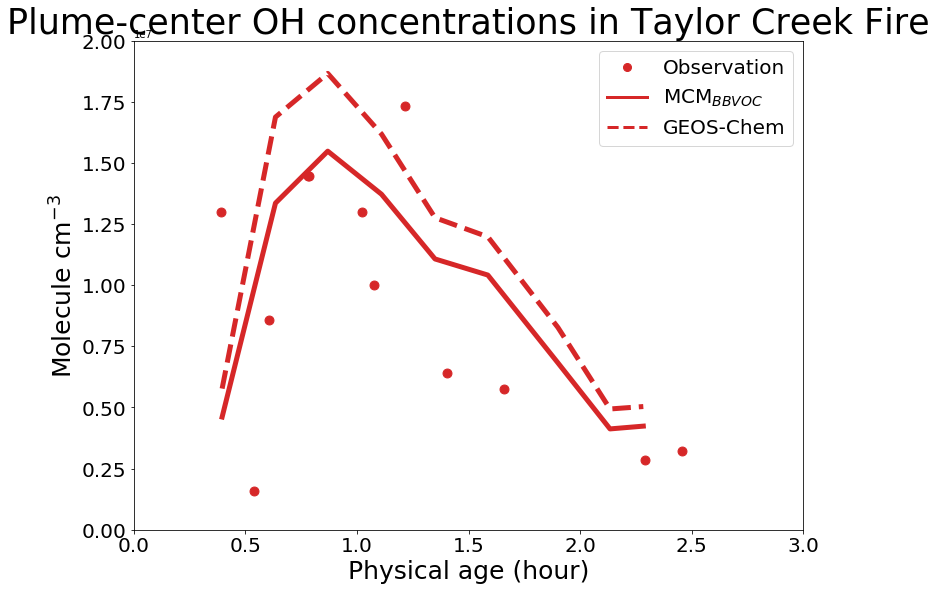

In [17]:
#### This is only used for IGC11 presentation
# Plotting
fig, axes = plt.subplots(1, 1, figsize=(12, 9))
axes = [axes]  # Make axes a list for consistency with the code

var_x_obs, var_y_obs = 'Plume_Age', 'cal_OH_mean'
var_x_mod, var_y_mod = 'Plume_Age', 'output_OH'
group_column = 'Flight_ID'
title = 'Plume-center OH concentrations in Taylor Creek Fire'
unique_groups = np.array(['RF03'])

for idx, group in enumerate(unique_groups):
    group_data_obs = all_data_obs_combined[all_data_obs_combined[group_column] == group]
    group_data_obs = group_data_obs.dropna(subset=[var_x_obs, var_y_obs])
    x_obs, y_obs = group_data_obs[var_x_obs].astype(float), group_data_obs[var_y_obs].astype(float)
    valid_indices = ~np.isnan(x_obs) & ~np.isnan(y_obs)

    if valid_indices.any():
        marker_size = 80
        linewidth = 5
        axes[0].scatter(x_obs[valid_indices], y_obs[valid_indices], edgecolors='tab:red', facecolors='tab:red', label='_nolegend_', s=marker_size)

    if (group_column == 'Flight_ID') and (group in Lagrangian_flights):
        group_data_mcm_bbvoc = all_data_mcm_bbvoc[all_data_mcm_bbvoc[group_column] == group]
        group_data_mcm_gcvoc = all_data_mcm_gcvoc[all_data_mcm_gcvoc[group_column] == group]
        group_data_gc = all_data_gc[all_data_gc[group_column] == group]

        bin_size = 0.25
        group_data_mcm_bbvoc['Time_Bin'] = (group_data_mcm_bbvoc['Plume_Age'] // bin_size) * bin_size
        group_data_mcm_gcvoc['Time_Bin'] = (group_data_mcm_gcvoc['Plume_Age'] // bin_size) * bin_size
        group_data_gc['Time_Bin'] = (group_data_gc['Plume_Age'] // bin_size) * bin_size
        group_data_mcm_bbvoc_binned = group_data_mcm_bbvoc.groupby('Time_Bin').mean()
        group_data_mcm_gcvoc_binned = group_data_mcm_gcvoc.groupby('Time_Bin').mean()
        group_data_gc_binned = group_data_gc.groupby('Time_Bin').mean()

        x_mcm_bbvoc, y_mcm_bbvoc = group_data_mcm_bbvoc_binned[var_x_mod].astype(float), group_data_mcm_bbvoc_binned[var_y_mod].astype(float)
        x_mcm_gcvoc, y_mcm_gcvoc = group_data_mcm_gcvoc_binned[var_x_mod].astype(float), group_data_mcm_gcvoc_binned[var_y_mod].astype(float)
        x_gc, y_gc = group_data_gc_binned[var_x_mod].astype(float), group_data_gc_binned[var_y_mod].astype(float)

        valid_indices_mod = ~np.isnan(x_mcm_bbvoc) & ~np.isnan(y_mcm_bbvoc) & ~np.isnan(x_mcm_gcvoc) & ~np.isnan(y_mcm_gcvoc) & ~np.isnan(x_gc) & ~np.isnan(y_gc)
        x_mcm_bbvoc, y_mcm_bbvoc = x_mcm_bbvoc[valid_indices_mod], y_mcm_bbvoc[valid_indices_mod]
        x_mcm_gcvoc, y_mcm_gcvoc = x_mcm_gcvoc[valid_indices_mod], y_mcm_gcvoc[valid_indices_mod]
        x_gc, y_gc = x_gc[valid_indices_mod], y_gc[valid_indices_mod]

        if valid_indices_mod.any():
            axes[0].plot(x_mcm_bbvoc, y_mcm_bbvoc, color='tab:red', linestyle='-', linewidth=linewidth)
            axes[0].plot(x_mcm_gcvoc, y_mcm_gcvoc, color='tab:red', linestyle='--', linewidth=linewidth)
        else:
            axes[0].plot(x_mcm_bbvoc, y_mcm_bbvoc, color='tab:red', linestyle='-', label=id2fire_name.get(group, group), linewidth=linewidth)
            axes[0].plot(x_mcm_gcvoc, y_mcm_gcvoc, color='tab:red', linestyle='--', label=id2fire_name.get(group, group), linewidth=linewidth)

    axes[0].set_xlabel(text_labels.get(var_x_obs, var_x_obs), fontsize=25)
    axes[0].set_ylabel(text_labels.get(var_y_obs, var_y_obs), fontsize=25)
    axes[0].set_title(title, fontsize=35)
    axes[0].tick_params(axis='both', labelsize=20)
    axes[0].set_ylim(0, 2E7)
    axes[0].set_xlim([0, 3])

# Adjust layout and show plot
plt.subplots_adjust(wspace=0.15)

# Custom legend setup
import matplotlib.lines as mlines
observation_legend = mlines.Line2D([], [], color='tab:red', marker='o', linestyle='None', markersize=8, label='Observation')
model1_legend = mlines.Line2D([], [], color='tab:red', linestyle='-', linewidth=3, label='MCM$_{{BBVOC}}$')
model2_legend = mlines.Line2D([], [], color='tab:red', linestyle='--', linewidth=3, label='GEOS-Chem')

axes[0].legend(handles=[observation_legend, model1_legend, model2_legend], fontsize=20)

plt.show()


VOCR: CO vs Plume_Age (NMB)
      $MCM_{BBVOC}$  $MCM_{GCVOC}$  GC
P-3B             -4            -31 -36
RF03             -1            -23 -29
RF07            -10            -31 -37
RF09            -20            -43 -49
FN19             -9            -39 -42
VOCR from key VOCs: 74±21


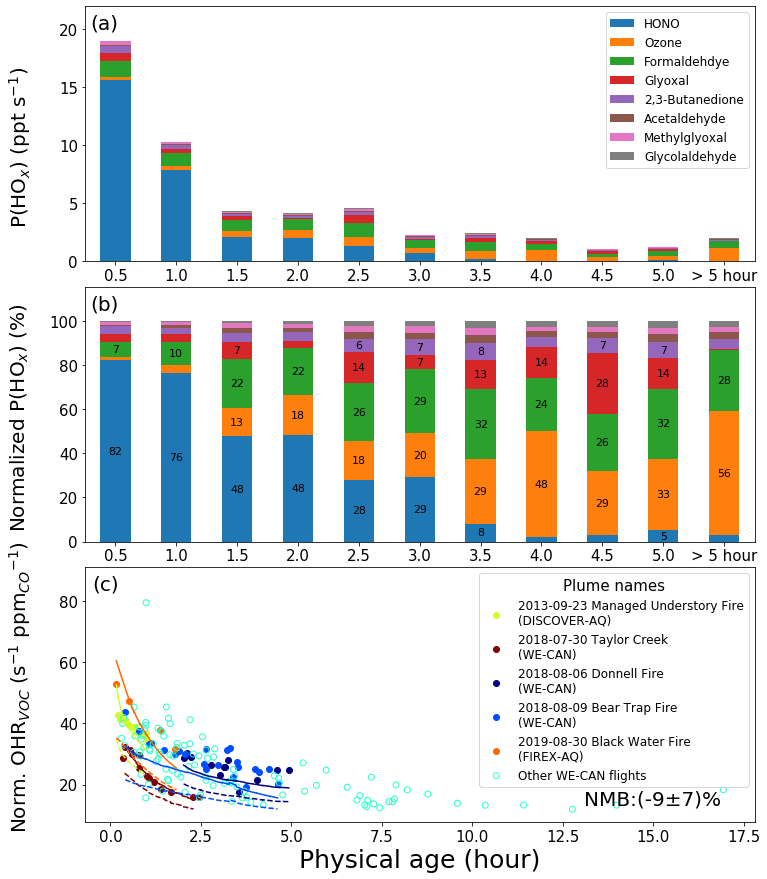

In [18]:
# ------------------------------
# Production and loss rate of OH
# Supplement figure
# ------------------------------
# Change the time into hour
combined_df_obs.index = (combined_df_obs.index).astype(float)

# Sort the DataFrame columns based on the mean values
sorted_columns  = (combined_df_obs.mean(axis=0)).sort_values(ascending=False).index
combined_df_obs = combined_df_obs[sorted_columns]

# Apply the function and group by its result
processed_df_obs = group_above_threshold(combined_df_obs, threshold=5, group_by_column='time_bin')
# Normalize the data
processed_df_obs_norm = processed_df_obs.copy()
processed_df_obs_norm.iloc[:, :] = processed_df_obs.iloc[:, :].div(processed_df_obs.iloc[:, :].sum(axis=1), axis=0)*100
# Define figsize for each subplot
figsize_per_subplot = (12, 5)

# Create three subplots, with the first two sharing the x-axis
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(figsize_per_subplot[0], figsize_per_subplot[1] * 3))

# Unpack all axes
ax1, ax2, ax3 = axes

# First subplot: Stacked bar plot
processed_df_obs.plot(kind='bar', stacked=True, ax=ax1)
ax1.legend(loc='upper right', fontsize=12)

# Second subplot: Normalized stacked bar plot
processed_df_obs_norm.plot(kind='bar', stacked=True, ax=ax2)
ax2.legend().remove()

# Add numbers to the stacked bars in the second subplot
for bars in ax2.containers:
    for bar in bars:
        height = bar.get_height()
        if height > 5:
            ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2,
                     f'{height:.0f}', ha='center', va='center', fontsize=11, color='black')

# Third subplot
var_x, var_y = 'Plume_Age', 'VOCR: CO'
plot_data_helper('Flight_ID', var_x, var_y, ax3, '', set_ylabel=False, show_legend=True)

# Calculate the contribution of acrolein, 1,3-butadiene, and furanoids to missing OHR
all_data_mcm_bbvoc['VOCR_part: CO'] = (all_data_mcm_bbvoc['Furan: CO'] * k_OH_dic['Furan'] + all_data_mcm_bbvoc['Methylfuran: CO'] * k_OH_dic['Methylfuran'] + \
                                            all_data_mcm_bbvoc['2,5-Dimethylfuran: CO'] * k_OH_dic['Dimethylfuran'] + all_data_mcm_bbvoc['Furfural: CO'] * k_OH_dic['Furfural'] + \
                                            all_data_mcm_bbvoc['Methylfurfural: CO'] * k_OH_dic['Methylfurfural'] + all_data_mcm_bbvoc['Furanone: CO'] * k_OH_dic['Furanone'] + \
                                            all_data_mcm_bbvoc['1,3-Butadiene: CO'] * k_OH_dic['Butadiene'] + all_data_mcm_bbvoc['Acrolein: CO'] * k_OH_dic['Acrolein'] )*2.5E10

missing_vocr = all_data_mcm_bbvoc['VOCR_part: CO']/(all_data_mcm_bbvoc['VOCR: CO']-all_data_mcm_gcvoc['VOCR: CO'])*100
print(f'VOCR from key VOCs: {missing_vocr.mean():.0f}±{missing_vocr.std():.0f}')

# -----------------
# Plotting setting
# -----------------
# Adjust spacing
plt.subplots_adjust(wspace=.1, hspace=.1)

# Define a percentage by which to extend the y-axis above the max value
extend_percent = 0.1  # for 10% extension

for i, ax in enumerate([ax1, ax2, ax3], start=1):
    # Get the current y-axis limits
    ymin, ymax = ax.get_ylim()
    # Calculate the range (max - min)
    yrange = ymax - ymin
    # Extend the max value by the defined percentage
    ax.set_ylim(ymin, ymax + yrange * 0.1)

    # Set tick parameters and labels for all subplots
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='x', rotation=0)

    # Annotate each subplot with (a), (b), (c)
    ax.text(0.05, 0.97, f'({chr(96+i)})', transform=ax.transAxes, fontsize=20, va='top', ha='right')

# Set global labels for the entire figure
fig.text(0.05, 0.75, 'P(HO$_x$) (ppt s$^{-1}$)', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(0.05, 0.5, 'Normalized P(HO$_x$) (%)', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(0.05, 0.25, 'Norm. OHR$_{VOC}$ (s$^{-1}$ ppm$_{CO}$$^{-1}$)', ha='center', va='center', rotation='vertical', fontsize=20)
#fig.text(0.52, 0.9, 'HO$_x$ production and loss', ha='center', va='center', fontsize=30)

plt.show()

In [19]:
# -----------------------------------------------------------------
# How many HONO will be consumed with the first hour of plume aging?
# -----------------------------------------------------------------
# Set up a 1x1 figure
fig, axes = plt.subplots(1, 4, figsize=(8*4, 6*1), sharex=True)
# Select variable
var_x, var_y = 'Plume_Age', 'NEMR_HONO'
plot_data_helper('Flight_ID', var_x, var_y,  axes[0], '', set_xlabel=True, set_ylabel=True, show_legend=True)
'''
var_x, var_y = 'Plume_Age', 'VOCR: CO'
plot_data_helper('Flight_ID', var_x, var_y,  axes[1], '', set_xlabel=True, set_ylabel=True, show_legend=True)
var_x, var_y = 'Plume_Age', 'NOx: CO'
plot_data_helper('Flight_ID', var_x, var_y,  axes[2], '', set_xlabel=True, set_ylabel=True, show_legend=True)
var_x, var_y = 'Plume_Age', 'OHRnox: OHRvoc'
plot_data_helper('Flight_ID', var_x, var_y,  axes[3], '', set_xlabel=True, set_ylabel=True, show_legend=True)
'''
# Close the figure to prevent it from being displayed
plt.close()

The consumed HONO in the first hour: 75.6±22.8%
The consumed HONO in the second hour: 84.3±13.1%

NEMR_HONO vs Plume_Age (NMB)
      $MCM_{BBVOC}$  $MCM_{GCVOC}$  GC
P-3B            -91            -89 -90
RF03            -13            -13 -11
RF07            -98            -98 -96
RF09            -99            -98 -96
FN19            -63            -58 -61


In [20]:
# ------------------------------------------------------
# OVOC photolysis to total HOx production (>1hour aging)
# Analysis in the P(HOx) section
# ------------------------------------------------------
processed_df_obs_norm_largerthan1h = processed_df_obs_norm.drop([0.5, 1.0])
df = processed_df_obs_norm_largerthan1h.describe()

# Printing the mean ± std for each compound
for compound, stats in df.items():
    print(f"{compound}: ({stats['mean']:.0f}±{stats['std']:.0f})%")
    print()
processed_df_obs_norm_largerthan1h

HONO: (19±19)%

Ozone: (29±15)%

Formaldehdye: (27±4)%

Glyoxal: (11±8)%

2,3-Butanedione: (6±1)%

Acetaldehyde: (3±1)%

Methylglyoxal: (3±0)%

Glycolaldehyde: (2±1)%



HONO      Ozone  Formaldehdye    Glyoxal  2,3-Butanedione  \
1.5       47.632883  13.059161     22.169526   7.493784         4.334005   
2.0       48.357923  17.966189     21.589769   2.920462         4.020264   
2.5       27.981644  17.509014     26.417523  13.875667         6.204235   
3.0       29.118788  20.114456     28.792070   6.520269         7.269532   
3.5        8.137304  29.067774     31.851910  13.360613         7.718233   
4.0        2.041413  48.210891     24.008741  13.808737         4.682540   
4.5        3.018604  28.827615     25.933094  27.536710         7.094331   
5.0        5.028902  32.579348     31.588415  13.981439         7.303139   
> 5 hour   2.904239  56.135717     27.904777   0.226336         4.670325   

          Acetaldehyde  Methylglyoxal  Glycolaldehyde  
1.5           1.917635       2.320214        1.072792  
2.0           1.911625       1.948704        1.285065  
2.5           2.838100       2.936880        2.236937  
3.0           2.854239       2.923210        2.407436  
3.5           3.666653       3.093217        3.104296  
4.0           2.804635       1.886995        2.556048  
4.5           2.495782       2.547456        2.546407  
5.0           3.529911       2.747226        3.241621  
> 5 hour      3.060527       2.134393        2.963686

### The analysis of VOC
Select HCHO, ALD2, MA,
Furanoids, acrolein, and 1,3-butadiene

E-folding lifetime (FN19): 1.7 hours (Furanoids excl. (dil))
E-folding lifetime (FN19): 0.6 hours (Furanoids excl. (dil))
E-folding lifetime (P-3B): 0.8 hours (Furanoids excl. (dil))
E-folding lifetime (P-3B): 1.5 hours (Furanoids excl. (dil))
Skipping Other WE-CAN flights for Furanoids excl. (dil) because no data is available after filtering.
Skipping Other WE-CAN flights for Furanoids excl. (dil) because no data is available after filtering.
E-folding lifetime (RF03): 1.3 hours (Furanoids excl. (dil))
E-folding lifetime (RF03): 0.8 hours (Furanoids excl. (dil))
E-folding lifetime (RF09): 5.0 hours (Furanoids excl. (dil))
E-folding lifetime (RF09): 4.7 hours (Furanoids excl. (dil))
E-folding lifetime (RF07): 6.6 hours (Furanoids excl. (dil))
E-folding lifetime (RF07): 4.6 hours (Furanoids excl. (dil))

Furanoids excl. (dil) vs Plume_Age (NMB)
      $MCM_{BBVOC}$  $MCM_{GCVOC}$   GC
P-3B              6            -99  -99
RF03            -31           -100 -100
RF07            -13     

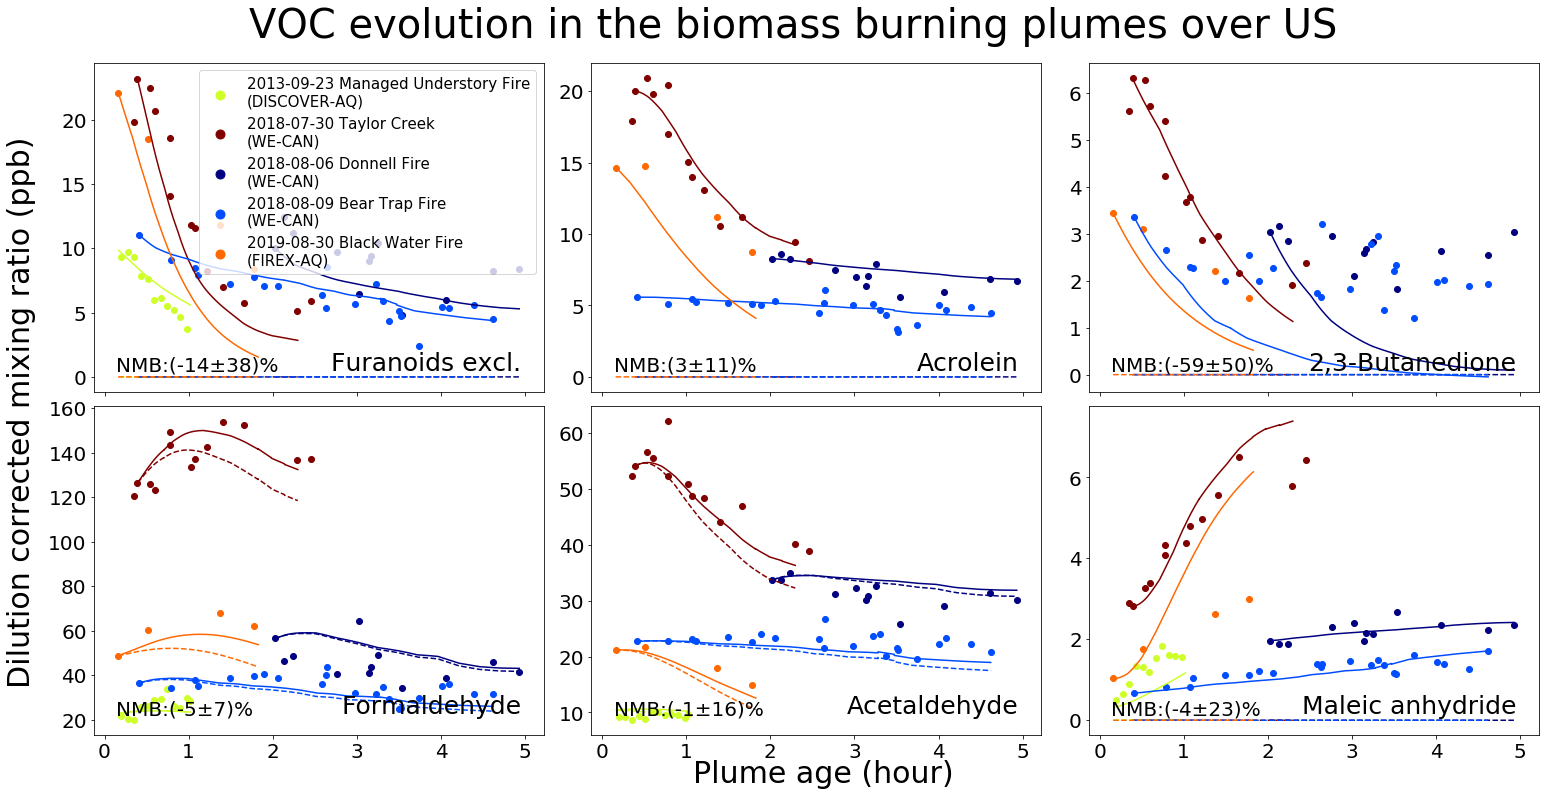

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(7*3, 5*2), sharex=True)
# Select variable
var_x, var_y = 'Plume_Age', 'Furanoids excl. (dil)'
plot_data_helper('Flight_ID', var_x, var_y,  axes[0][0], '', set_xlabel=False, set_ylabel=False, show_legend=False)
var_x, var_y = 'Plume_Age', 'Acrolein (dil)'
plot_data_helper('Flight_ID', var_x, var_y,  axes[0][1], '', set_xlabel=False, set_ylabel=False, show_legend=False)
#var_x, var_y = 'Plume_Age', '1,3-Butadiene (dil)'
#plot_data_helper('Flight_ID', var_x, var_y,  axes[0][2], '', set_xlabel=False, set_ylabel=False, show_legend=False)
var_x, var_y = 'Plume_Age', 'Butanedione (dil)'
plot_data_helper('Flight_ID', var_x, var_y,  axes[0][2], '', set_xlabel=False, set_ylabel=False, show_legend=False)

var_x, var_y = 'Plume_Age', 'Formaldehyde (dil)'
plot_data_helper('Flight_ID', var_x, var_y,  axes[1][0], '', set_xlabel=False, set_ylabel=False, show_legend=False)
var_x, var_y = 'Plume_Age', 'Acetaldehyde (dil)'
plot_data_helper('Flight_ID', var_x, var_y,  axes[1][1], '', set_xlabel=False, set_ylabel=False, show_legend=False)
var_x, var_y = 'Plume_Age', 'Maleic anhydride (dil)'
plot_data_helper('Flight_ID', var_x, var_y,  axes[1][2], '', set_xlabel=False, set_ylabel=False, show_legend=False)

# Annotate compound names in each subplot
compounds = ['Furanoids excl.', 'Acrolein', '1,3-Butadiene', 'Formaldehyde', 'Acetaldehyde', 'Maleic anhydride']
compounds = ['Furanoids excl.', 'Acrolein', '2,3-Butanedione', 'Formaldehyde', 'Acetaldehyde', 'Maleic anhydride']

for i, ax in enumerate(axes.flatten()):
    ax.text(0.95, 0.05, compounds[i], transform=ax.transAxes, ha='right', va='bottom', fontsize=25)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.tick_params(axis='y', which='major', labelsize=20)
    #ax.set_xlim(0, 5)  # Set x-axis limit to 5

# Add title
fig.text(0.5, 1.02, "VOC evolution in the biomass burning plumes over US", ha='center', fontsize=40)

# Add x-label and y-label
fig.text(0.52, -0.015, "Plume age (hour)", ha='center', fontsize=30)
fig.text(-0.02, 0.5, "Dilution corrected mixing ratio (ppb)", va='center', rotation='vertical', fontsize=30)

# Manually show legend for the first subplot
desired_order = desired_order_flights
reorder_legend(axes[0][0], desired_order, id2fire_name, legend_title='', fontsize=15, title_fontsize=20, legend_loc='upper right', markerscale=1.5)

# Tighten layout
plt.tight_layout(w_pad=1.5)
plt.show()

In [22]:
# Initialize lists to collect the initial concentrations of each compound
initial_dmf = []
initial_sesq = []

# Collect initial concentration for each flight
for flight_id in all_data_mcm_bbvoc['Flight_ID'].unique():
    all_data_mcm_bbvoc_each = all_data_mcm_bbvoc[all_data_mcm_bbvoc['Flight_ID'] == flight_id]
    # Collect initial concentration of Dimethylfuran if available
    initial_dmf.append(all_data_mcm_bbvoc_each['2,5-Dimethylfuran'].iloc[0])
    # Collect initial concentration of Sesquiterpenes if available
    initial_sesq.append(all_data_mcm_bbvoc_each['Sesquiterpenes'].iloc[0]*1000)

print("This is analysis for specific initial VOC concentration.")
# Calculate mean and standard deviation of initial concentrations across all flights
if initial_dmf:
    dmf_mean = np.mean(initial_dmf)
    dmf_std = np.std(initial_dmf)
    print(f"Dimethylfuran: Mean of initial concentrations (ppb) = {dmf_mean:.2f}±{dmf_std:.2f}")
else:
    print("No Dimethylfuran data available.")
if initial_sesq:
    sesq_mean = np.mean(initial_sesq)
    sesq_std = np.std(initial_sesq)
    print(f"Sesquiterpenes: Mean of initial concentrations (ppt) = {sesq_mean:.2f}±{sesq_std:.2f}")
else:
    print("No Sesquiterpenes data available.")

This is analysis for specific initial VOC concentration.
Dimethylfuran: Mean of initial concentrations (ppb) = 1.01±0.51
Sesquiterpenes: Mean of initial concentrations (ppt) = 50.79±50.72


In [23]:
# =============================================
# TBD: Add the analysis for 2,3-butanedione!!
# =============================================


BIACET vs Plume_Age (NMB)
Data contains NaN or Infinite values, handling...
      $MCM_{BBVOC}$  $MCM_{GCVOC}$   GC
P-3B              0              0    0
RF03              2            -99  -99
RF07            -73           -100 -100
RF09            -77           -100 -100
FN19            -51           -100 -100


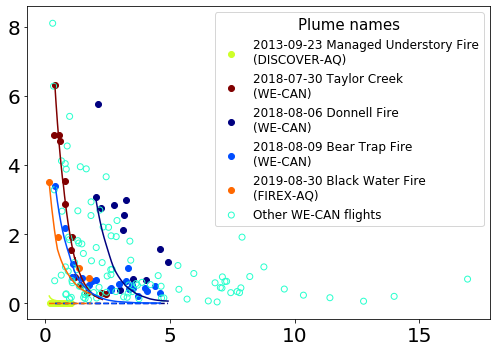

In [24]:
# Set up a 1x1 figure
fig, axes = plt.subplots(1, 1, figsize=(7*1, 5*1), sharex=True)
# Select variable
var_x, var_y = 'Plume_Age', 'Butanedione (dil)'
var_x, var_y = 'Plume_Age', 'BIACET'

#var_x, var_y = 'Plume_Age', 'Methylglyoxal (dil)'
#var_x, var_y = 'Plume_Age', 'MACR + MVK (dil)'
plot_data_helper('Flight_ID', var_x, var_y,  axes, '', set_xlabel=False, set_ylabel=False, show_legend=True)

# Tighten layout
plt.tight_layout(w_pad=1.5)
plt.show()

In [25]:
def calculate_nmb_for_models(all_data_obs_combined, all_data_mcm_bbvoc, all_data_mcm_gcvoc, all_data_gc, Lagrangian_flights, var_x, var_y_list):
    """
    Calculates and organizes the Normalized Median Bias (NMB) for each VOC across different models using polynomial regression.
    
    Parameters:
    - all_data_obs_combined, all_data_mcm_bbvoc, all_data_mcm_gcvoc, all_data_gc: DataFrames for observational and model data.
    - Lagrangian_flights: List of flights considered for analysis.
    - var_x: Independent variable.
    - var_y_list: List of VOCs to analyze.
    
    Returns:
    DataFrame with VOCs as rows, models as columns, and formatted NMB±std as values.
    """
    var_y_list_dic = [var_y.replace(' (dil)', '') for var_y in var_y_list]
    nmb_summary = pd.DataFrame(index=var_y_list_dic, columns=['MCM_BB_VOC', 'MCM_GC_VOC', 'GC'])

    for var_y in var_y_list:
        nmb_values = {model: [] for model in ['MCM_BB_VOC', 'MCM_GC_VOC', 'GC']}

        for group in Lagrangian_flights:
            # Define the degree of the polynomial
            degree = 2 if group!='FN19' else 1
            group_data_obs = all_data_obs_combined[(all_data_obs_combined['Flight_ID'] == group) & (~all_data_obs_combined[var_x].isna()) & (~all_data_obs_combined[var_y].isna())]

            if group_data_obs.empty:
                continue

            x_obs, y_obs = group_data_obs[var_x].values, group_data_obs[var_y].values

            # Create a polynomial regression model pipeline
            poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
            poly_model.fit(x_obs.reshape(-1, 1), y_obs)

            for model_data, model_name in zip([all_data_mcm_bbvoc, all_data_mcm_gcvoc, all_data_gc], ['MCM_BB_VOC', 'MCM_GC_VOC', 'GC']):
                group_data_model = model_data[model_data['Flight_ID'] == group]
                if group_data_model.empty:
                    continue

                x_model, y_model = group_data_model[var_x].values, group_data_model[var_y].values
                y_predicted = poly_model.predict(x_model.reshape(-1, 1))
                nmb = 100 * (np.nanmedian(y_model) - np.nanmedian(y_predicted)) / np.nanmedian(y_predicted)
                nmb_values[model_name].append(nmb)

        for model_name, nmb_list in nmb_values.items():
            # Replace inf/-inf with 0 in nmb_list
            nmb_list = [0 if np.isinf(nmb) else nmb for nmb in nmb_list]

            if nmb_list:
                #mean_nmb = np.nanmean(nmb_list)
                #std_nmb = np.nanstd(nmb_list)
                #nmb_summary.loc[var_y.replace(' (dil)', ''), model_name] = f"({mean_nmb:.0f}±{std_nmb:.0f})%"
                med_nmb = np.nanmedian(nmb_list)
                iqr_nmb = np.nanpercentile(nmb_list, 75) - np.nanpercentile(nmb_list, 25)
                nmb_summary.loc[var_y.replace(' (dil)', ''), model_name] = f"({med_nmb:.0f}±{iqr_nmb:.0f})%"
            else:
                nmb_summary.loc[var_y.replace(' (dil)', ''), model_name] = np.nan

    return nmb_summary

In [26]:
# ---------------------
# Print out the data
# ---------------------
var_x = 'Plume_Age'
'''
var_y_list = [
    'Formaldehyde (dil)',
    'Acetaldehyde (dil)',
    'Maleic anhydride (dil)',
    'Furanoids excl. (dil)',
    '2,5-Dimethylfuran (dil)',
    'Methylfuran (dil)',
    'Acrolein (dil)',
    '1,3-Butadiene (dil)',
    'Isoprene (dil)',
    'Monoterpenes (dil)',
    'Xylenes (dil)',
    '2-Butenal (dil)',
    'Cresol (dil)',
    'Guaiacol (dil)',
    'Lumped C>=3 aldehydes (dil)',
    'Glyoxal (dil)',
    'Formic acid (dil)',
    'Acetic acid (dil)',
    'MACR + MVK (dil)',
    'MEK (dil)',
    'Glycoaldehyde (dil)',
    'Methylglyoxal (dil)',
    'Hydroxy acetone (dil)',
    'Phenol (dil)',
    'Benzaldehyde (dil)',
    'Furanone (dil)',
    'Acrolein (dil)',
    'Maleic anhydride (dil)',
    'Butanedione (dil)',
]
'''

var_y_list = [
    'Furanoids excl. (dil)',
    '2,5-Dimethylfuran (dil)',
    '1,3-Butadiene (dil)',
    'Isoprene (dil)',
    'Monoterpenes (dil)',
    'Xylenes (dil)',
    '2-Butenal (dil)',
    'Cresol (dil)',
    'Guaiacol (dil)',
    'Syringol (dil)', 
    'Sesquiterpenes (dil)',
    'Phenol (dil)',

    'Formaldehyde (dil)',
    'Acetaldehyde (dil)',
    'Maleic anhydride (dil)',
    'Methylfuran (dil)',
    'Lumped C>=3 aldehydes (dil)',
    'Glyoxal (dil)',
    'Formic acid (dil)',
    'Acetic acid (dil)',
    'MACR + MVK (dil)',
    'MEK (dil)',
    'Glycoaldehyde (dil)',
    'Methylglyoxal (dil)',
    'Hydroxy acetone (dil)',
    'Phenol (dil)',
    'Benzaldehyde (dil)',
    'Acrolein (dil)',
    'Butanedione (dil)',
]


# !!! Make the order right, primary first and then secondary.
df = calculate_nmb_for_models(all_data_obs_combined, all_data_mcm_bbvoc, all_data_mcm_gcvoc, all_data_gc, Lagrangian_flights, var_x, var_y_list)

# Function to replace "-100±0" with np.nan
def replace_with_nan(value):
    if value == '(-100±0)%':
        return np.nan
    else:
        return value

# Applying the function to each cell in the DataFrame
df = df.applymap(replace_with_nan)


# Create a dictionary for instrument uncertainties
uncertainty_mapping = {
    "Formaldehyde"   : "±40%",
    "Acetaldehyde"   : "±15%",
    "Furanoids excl.": "±(15–50)%",
    "Methylfuran"    : "±(15–50)%",
    "Xylenes"        : "±(15–50)%",
    "Acetic acid"    : "±15%",
    "MACR + MVK"     : "±15%",
    "MEK"            : "±15%",

    
}

# Add 'instrument uncertainty' column with conditional values
df.insert(0, 'Measurement uncertainty', df.index.map(lambda x: uncertainty_mapping.get(x, "±50%")))

# Convert NaN values to the string "NaN"
df = df.fillna('NaN')

# Reset the index to turn it into a column
df.reset_index(inplace=True)
df.rename(columns={'index': 'Compound'}, inplace=True)


# Save out the table
df.to_csv('/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/VOC_OH_exposure/output/NMB_VOC_dil.csv', index=True)  # Set index=False if you don't want to save row indices

# Save out the table to Word document
from docx import Document

doc = Document()
table = doc.add_table(rows=1, cols=len(df.columns))  # Start with a header row

# Fill in the header row
hdr_cells = table.rows[0].cells
for i, column_name in enumerate(df.columns):
    hdr_cells[i].text = str(column_name)

# Append rows to the table and fill in the data
for index, row in df.iterrows():
    row_cells = table.add_row().cells  # Add a new row and then access its cells
    for col_index, value in enumerate(row):
        # Replace np.nan with an empty string, ensure all values are converted to string
        row_cells[col_index].text = '' if pd.isna(value) else str(value)

# Save the document
doc.save('/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/VOC_OH_exposure/output/NMB_VOC_dil.docx')

In [27]:
# Print out the ozone enhancement
df_temp = all_data_obs_lagrangian[['O3 (dil)', 'Flight_ID']]
for flight_id in df_temp['Flight_ID'].unique():
    df_temp_each = df_temp[df_temp['Flight_ID'] == flight_id]
    mean = df_temp_each['O3 (dil)'].mean()
    std  = df_temp_each['O3 (dil)'].std()
    print(f"{flight_id}: {mean:.0f}±{std:.0f}")

FN19: 151±88
P-3B: 38±20
RF03: 247±185
RF09: 76±30
RF07: 144±93


In [28]:
df_temp = all_data_obs_combined[['O3 (dil)', 'Flight_ID']]
for flight_id in df_temp['Flight_ID'].unique():
    df_temp_each = df_temp[df_temp['Flight_ID'] == flight_id]
    mean = df_temp_each['O3 (dil)'].mean()
    std  = df_temp_each['O3 (dil)'].std()
    max  =  df_temp_each['O3 (dil)'].max()
    print(f"{flight_id}: {mean:.0f}±{std:.0f}, {max:.0f}")

FN19: 151±88, 223
P-3B: 38±20, 61
Other WE-CAN flights: 40±56, 418
RF03: 247±185, 536
RF09: 76±30, 149
RF07: 144±93, 391


### Ozone analysis

This is NEMR O3 rate (ppb/h)
{'FN19': 6.067690733258321, 'P-3B': 5.566587067092681, 'RF10': 1.4977556530528287, 'RF06': 0.4271673257101811, 'RF03': 4.660639611482791, 'RF09': 1.351066908989589, 'RF04': 0.5678478243979095, 'RF01': 0.7871851718466015, 'RF02': 0.5347802783883342, 'RF07': 1.3027802901730112, 'RF13': 1.1385153769956713, 'RF05': 0.42000601753057465}
The range of NEMR O3 for Lagarangian flights: 3.4, 7.3%
The stat of NEMR O3 for Lagarangian flights: 4.8±1.4%
The stat of NEMR O3 for all flights: 3.3±2.3%

NEMR_O3 vs Plume_Age (NMB)
      $MCM_{BBVOC}$  $MCM_{GCVOC}$  GC
P-3B            -19            -21 -28
RF03            -10            -20 -20
RF07             -6             -4  -6
RF09            -19            -16 -18
FN19             -2            -27 -32
skip non-Lagrangian flights
This is NEMR O3 rate (ppb/h)
{'FN19': 0.7867222856903712, 'P-3B': 1.7694862370707873, 'RF10': 0.7495168222564227, 'RF06': 0.14404266275732114, 'RF03': 0.6674281032842643, 'RF09': 0.6472656737

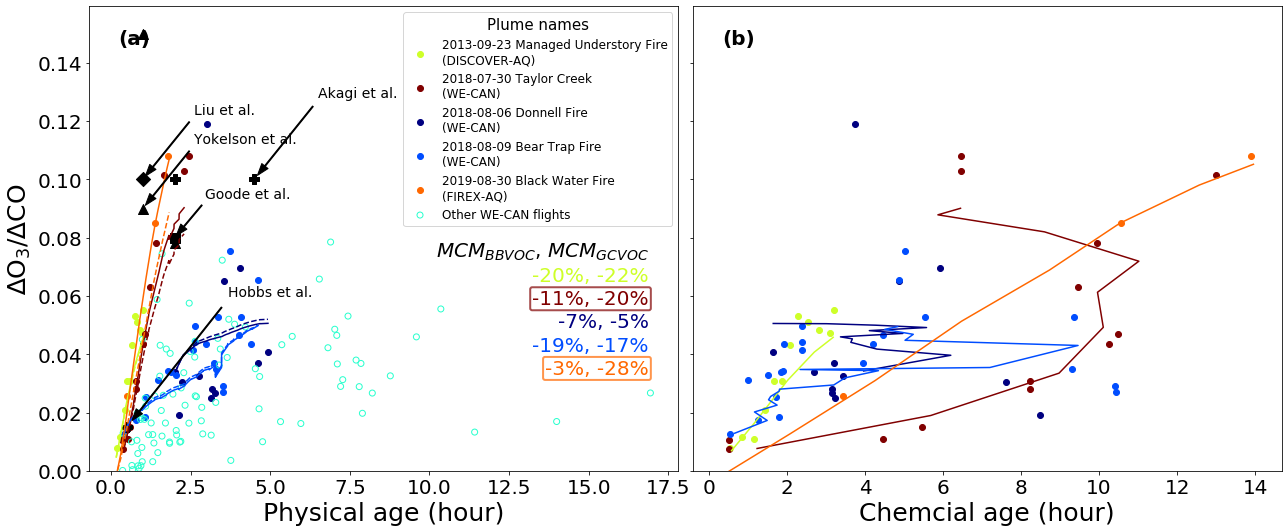

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(9*2, 7.5*1), sharey='row')
# Select variable
var_x, var_y = 'Plume_Age', 'NEMR_O3'
plot_data_helper('Flight_ID', var_x, var_y,  axes[0], '', set_ylabel=True, show_legend=True)
var_x, var_y = 'output_chem_age', 'NEMR_O3'
plot_data_helper('Flight_ID', var_x, var_y,  axes[1], '', set_ylabel=False, show_legend=False)

# Adding text labels to each subplot
labels = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate(axes.flat):
    # Set up y limitation
    ax.set_ylim(0)
    # Add a, b, c, d    
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()

In [30]:
# Supplement figure
def plot_voc_comparisons(df_mod1, df_mod2, mod1_name, mod2_name, var_comp, ax, title, set_ylabel, show_legend, set_xlabel=True, annotate_one_to_one=False, flights=['P-3B', 'RF03', 'RF07', 'RF09', 'FN19']):
    # Extract unique flight IDs
    unique_groups = flights
    # colors
    if len(unique_groups) !=2: 
        group_colors = sns.color_palette("bright", len(unique_groups))  # Other options: "deep", "muted", "pastel", etc.
    else: 
        group_colors = np.array([
            [0.5, 0.0, 0.0, 1.0],
            [1.0, 0.40740741, 0.0, 1.0],
        ])

    # Filter both datasets to include only the selected flights
    df_mod1 = df_mod1[df_mod1['Flight_ID'].isin(unique_groups)]
    df_mod2 = df_mod2[df_mod2['Flight_ID'].isin(unique_groups)]
    
    # The loop is only used for the scatter plot
    for idx, flight_id in enumerate(unique_groups):
        # Filter data for each flight
        df_mod1_each = df_mod1[df_mod1['Flight_ID'] == flight_id]
        df_mod2_each = df_mod2[df_mod2['Flight_ID'] == flight_id]

        # Bin the data by time for every 15 minutes and average each bin
        bin_size = 10 / 60  # 2 minutes converted to hours
        df_mod1_each['Time_Bin'] = (df_mod1_each['Plume_Age'] // bin_size) * bin_size
        df_mod2_each['Time_Bin'] = (df_mod2_each['Plume_Age'] // bin_size) * bin_size
        df_mod1_binned           = df_mod1_each.groupby('Time_Bin').mean()
        df_mod2_binned           = df_mod2_each.groupby('Time_Bin').mean()
        if var_comp == 'XO2':
            #data_mod1_each = 0.4*df_mod1_binned['HO2'] + 0.6*df_mod1_binned['RO2']
            #data_mod2_each = 0.4*df_mod2_binned['HO2'] + 0.6*df_mod2_binned['RO2']
            data_mod1_each = df_mod1_binned['HO2'] + df_mod1_binned['RO2']
            data_mod2_each = df_mod2_binned['HO2'] + df_mod2_binned['RO2']
        elif var_comp == 'L(Ox)':
            data_mod1_each = -df_mod1_binned[var_comp] 
            data_mod2_each = -df_mod2_binned[var_comp] 
        else:
            data_mod1_each = df_mod1_binned[var_comp] 
            data_mod2_each = df_mod2_binned[var_comp] 
        # Scatter plot
        face_color = group_colors[idx]
        fire_name = id2fire_name.get(flight_id,flight_id).split('\n')[0]
        ax.scatter(data_mod2_each, data_mod1_each, edgecolors=group_colors[idx], facecolors=face_color, label=fire_name)
        
        # Annotate the slope value for each flight
        #slope_each, _, _, _, _ = linregress(data_mod2_each, data_mod1_each)
        slope_each = np.linalg.lstsq(data_mod2_each[:, np.newaxis], data_mod1_each, rcond=None)[0][0]
        ax.annotate(f'Slope={slope_each:.2f}', 
                    xy=(0.05, 0.85 - 0.1 * idx), 
                    xycoords='axes fraction', 
                    fontsize=20, 
                    color=group_colors[idx],
                    ha='left', va='top')
        
    # Out of the loop, we would use all data we have
    if var_comp == 'XO2':
        #data_mod1 = 0.4*df_mod1['HO2'] + 0.6*df_mod1['RO2']
        #data_mod2 = 0.4*df_mod2['HO2'] + 0.6*df_mod2['RO2']
        data_mod1 = df_mod1['HO2'] + df_mod1['RO2']
        data_mod2 = df_mod2['HO2'] + df_mod2['RO2']
    elif var_comp == 'L(Ox)':
        data_mod1 = -df_mod1[var_comp] 
        data_mod2 = -df_mod2[var_comp] 
    else:
        data_mod1 = df_mod1[var_comp] 
        data_mod2 = df_mod2[var_comp] 
    # Perform linear regression
    
    #slope, intercept, r_value, p_value, std_err = linregress(data_mod2, data_mod1)
    slope = np.linalg.lstsq(data_mod2[:, np.newaxis], data_mod1, rcond=None)[0][0]
    
    # Annotation
    ax.annotate(f'Slope (all fires)={slope:.2f}', 
                xy=(0.05, 0.95), 
                xycoords='axes fraction', 
                fontsize=20, 
                color='black',
                ha='left', va='top')
    
    # Defining consistent x range for 1:1 and regression line
    min_values = np.array([np.min(data_mod1), np.min(data_mod2)])
    max_values = np.array([np.max(data_mod1), np.max(data_mod2)])
    min_val = np.min(min_values)
    max_val = np.max(max_values)
    x_vals = np.linspace(min_val, max_val, 100)
    y_vals = slope * x_vals
    
    # Plot the 1:1 line
    ax.plot(x_vals, x_vals, 'k--')
    if annotate_one_to_one:
        ax.annotate('1:1 Slope', xy=(0.7 * max_val, 0.8 * max_val+0.05*max_val), fontsize=20, color='black')

    # Plotting the regression line
    ax.plot(x_vals, y_vals, 'r-', color='black')

    # Legend, labels, title, ticks
    if show_legend:
        #reorder_legend(ax, unique_groups, id2fire_name, legend_title='Plume names', fontsize=12, title_fontsize = 15, legend_loc='lower right')
        ax.legend(fontsize=12, loc='lower right')

    
    # Defalt setting for title, ticks, and labels
    ax.set_title(title, fontsize=25)
    ax.tick_params(axis='both', labelsize=20)
    if set_ylabel: ax.set_ylabel(mod1_name, fontsize=25)
    if set_xlabel: ax.set_xlabel(mod2_name, fontsize=25)

    # Set axis limits to start from 0
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

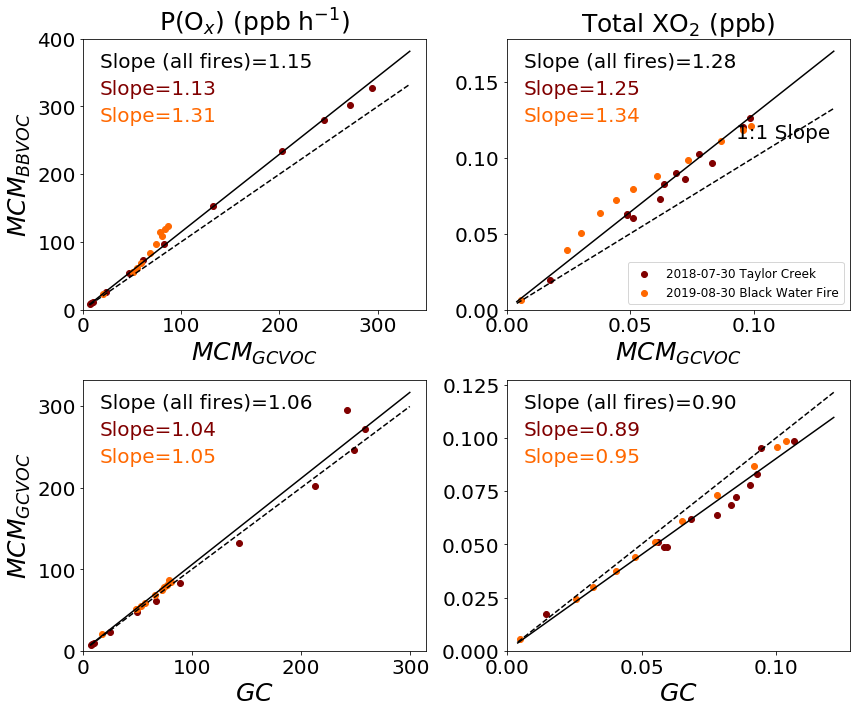

In [31]:
# ==============================================================
# Model comparisons in ozone production and ROx concentartion.
# Supplement figure
# ==============================================================
nrows, ncols = 2, 2 
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))  # Adjust the figure size to fit the 2x3 layout
flights = ['RF03', 'FN19']

plot_voc_comparisons(all_data_mcm_bbvoc, all_data_mcm_gcvoc, '$MCM_{BBVOC}$', '$MCM_{GCVOC}$', 
                     'P(Ox)', axes[0, 0], 
                     'P(O$_{x}$) (ppb h$^{-1}$)', set_ylabel=True, show_legend=False, set_xlabel=True, flights= flights)
plot_voc_comparisons(all_data_mcm_gcvoc, all_data_gc, '$MCM_{GCVOC}$', '$GC$', 
                     'P(Ox)', axes[1, 0], 
                     '', set_ylabel=True, show_legend=False, set_xlabel=True, flights=flights)

plot_voc_comparisons(all_data_mcm_bbvoc, all_data_mcm_gcvoc, '$MCM_{BBVOC}$', '$MCM_{GCVOC}$', 
                     'XO2', axes[0, 1], 
                     'Total XO$_{2}$ (ppb)', set_ylabel=False, show_legend=True, set_xlabel=True, annotate_one_to_one=True, flights= flights)
plot_voc_comparisons(all_data_mcm_gcvoc, all_data_gc, '$MCM_{GCVOC}$', '$GC$', 
                     'XO2', axes[1, 1], 
                     '', set_ylabel=False, show_legend=False, set_xlabel=True, flights= flights)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

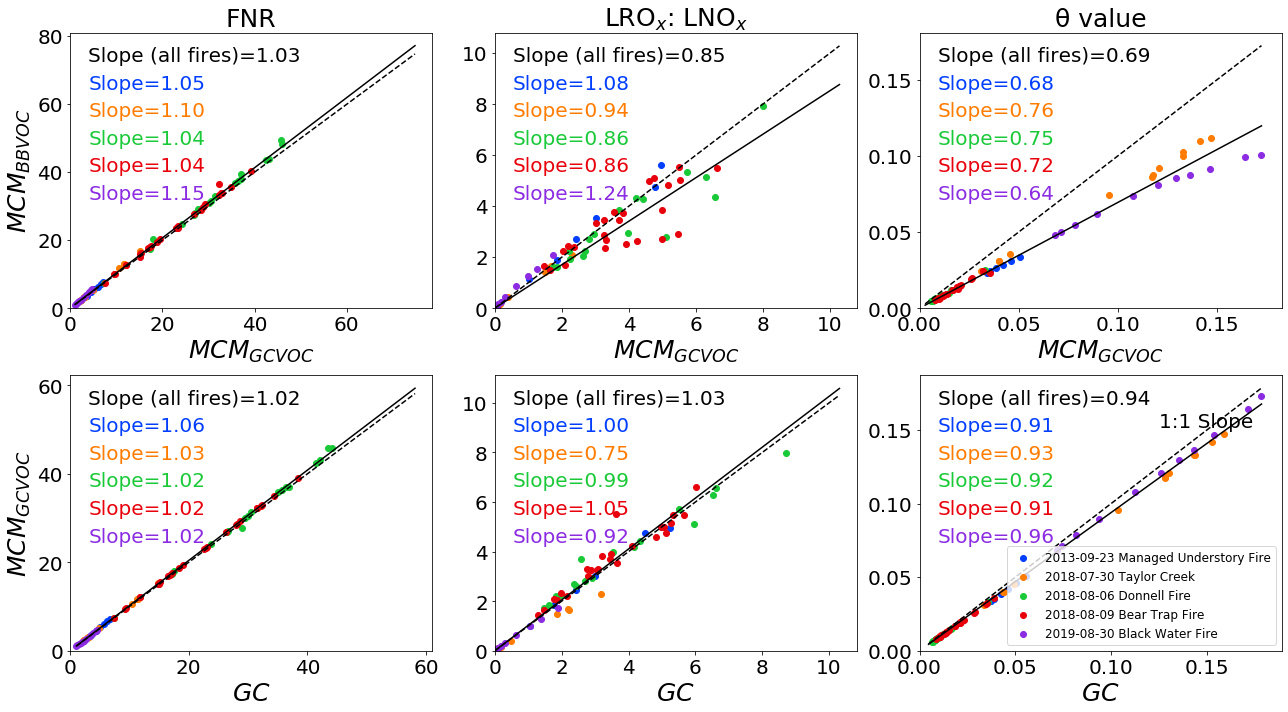

In [32]:
compounds = ['CH2O: NO2', 'LROx: LNOx', 'OHRnox: OHRvoc']
nrows, ncols = len(compounds), 2
fig, axes = plt.subplots(ncols, nrows, figsize=(6*nrows, 5*ncols))  # Adjust the figure size to fit the 2x3 layout
for idx, compound in enumerate(compounds):
    if idx == len(compounds)-1: 
        if_legend = True
        if_annotate_one_to_one = True
    else:
        if_legend = False
        if_annotate_one_to_one = False
    
    if_ylabel = True if idx == 0 else False
        
    plot_voc_comparisons(all_data_mcm_bbvoc, all_data_mcm_gcvoc, '$MCM_{BBVOC}$', '$MCM_{GCVOC}$', 
                         compound, axes[0, idx], 
                         text_labels[compound], set_ylabel=if_ylabel, show_legend=False, set_xlabel=True)
    plot_voc_comparisons(all_data_mcm_gcvoc, all_data_gc, '$MCM_{GCVOC}$', '$GC$', 
                         compound, axes[1, idx], 
                         '', set_ylabel=if_ylabel, show_legend=if_legend, set_xlabel=True, annotate_one_to_one=if_annotate_one_to_one)
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


CH2O: NO2 vs Plume_Age (NMB)
      $MCM_{BBVOC}$  $MCM_{GCVOC}$  GC
P-3B            -14            -17 -21
RF03            -41            -44 -45
RF07             41             37  34
RF09             14             11  10
FN19            -29            -34 -35

CH2O: NO2 vs NO (NMB)
Empty DataFrame
Columns: [$MCM_{BBVOC}$, $MCM_{GCVOC}$, GC]
Index: []

OHRnox: OHRvoc vs Plume_Age (NMB)
      $MCM_{BBVOC}$  $MCM_{GCVOC}$  GC
P-3B             12             64  80
RF03             32             78  94
RF07            -22              1  11
RF09              6             53  70
FN19              9             63  71

LROx: LNOx vs Plume_Age (NMB)
      $MCM_{BBVOC}$  $MCM_{GCVOC}$  GC
P-3B              0            -12 -12
RF03              0            -22  -1
RF07              0             16  -1
RF09              0             26  15
FN19              0            -32 -32


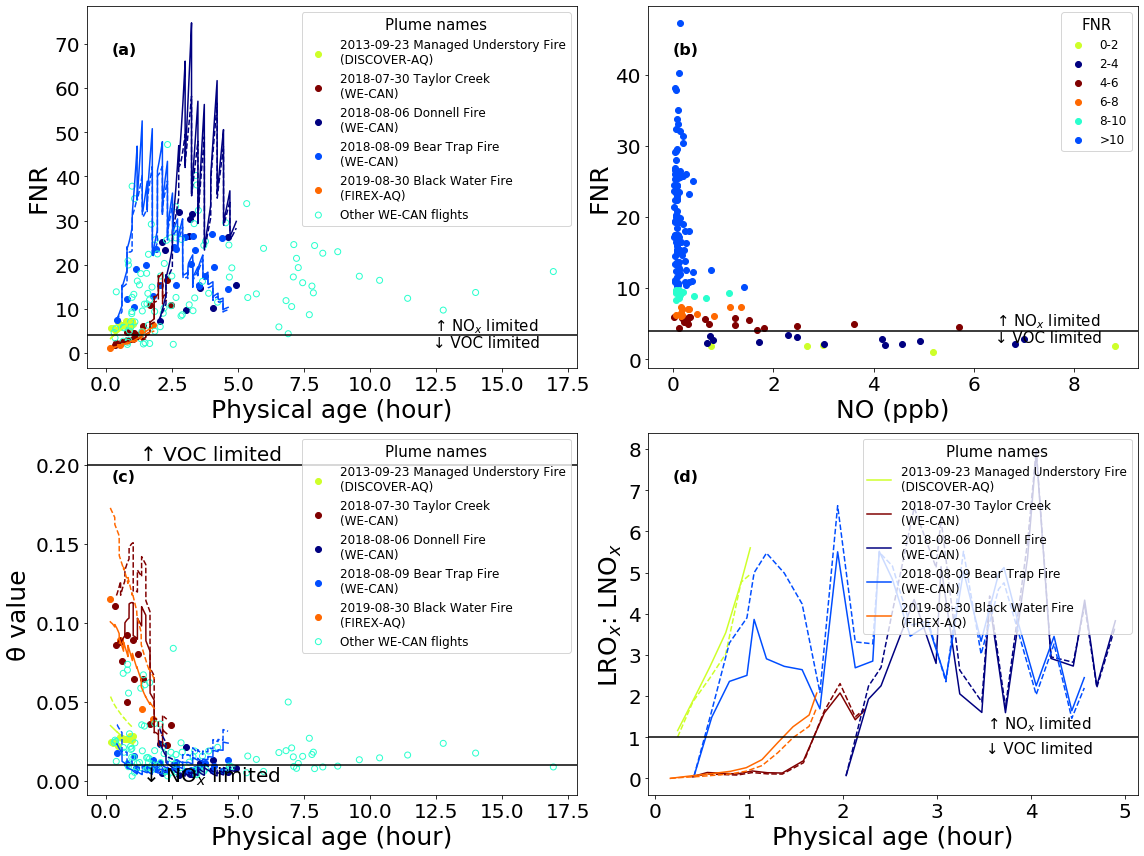

In [64]:
# Set up a 1x2 figure
fig, axes = plt.subplots(2, 2, figsize=(8*2, 6*2))#, sharey='row')

# First plot
var_x, var_y = 'Plume_Age', 'CH2O: NO2'
plot_data_helper('Flight_ID', var_x, var_y,  axes[0, 0], '', set_ylabel=True, show_legend=True)

# Second plot
var_x, var_y = 'NO', 'CH2O: NO2'
plot_data_helper('CH2O_NO2_group', var_x, var_y, axes[0, 1], '', set_ylabel=True, show_legend=True)

# Third plot
#var_x, var_y = 'Plume_Age', 'H2O2: HNO3'
#plot_data_helper('Flight_ID', var_x, var_y,  axes[1,1], '', set_ylabel=True, show_legend=True)
var_x, var_y = 'Plume_Age', 'OHRnox: OHRvoc'
plot_data_helper('Flight_ID', var_x, var_y,  axes[1,0], '', set_ylabel=True, show_legend=True)

# Fourth plot
var_x, var_y = 'Plume_Age', 'LROx: LNOx'
plot_data_helper('Flight_ID', var_x, var_y,  axes[1,1], '', set_ylabel=True, show_legend=True)

# Adding text labels to each subplot
labels = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate(axes.flat):
    # Add a, b, c, d    
    ax.text(0.05, 0.9, labels[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

# Add annotation
# The first and second
for ax, var_x in zip([axes[0,0], axes[0,1]], ['Plume_Age', 'NO']):
    # Get the current limits of the x-axis    
    #ax.axhline(y=1, color='black', linestyle='-')  
    #ax.axhline(y=4, color='black', linestyle='--')  
    ax.axhline(y=4, color='black', linestyle='-')  
    # Add text above and below the line
    text_position_above = 4.1  # Slightly above the line
    text_position_below = 0.8  # Slightly below the line
    ax.text(x=all_data_obs_combined[var_x].max()*0.85, y=text_position_above,ha='center', va='bottom', s='↑ NO$_{x}$ limited', fontsize=15)
    #ax.text(x=all_data_obs_combined[var_x].max()*0.85, y=text_position_below,ha='center', va='top', s='↓ VOC limited', fontsize=15)
    ax.text(x=all_data_obs_combined[var_x].max()*0.85, y=text_position_above,ha='center', va='top', s='↓ VOC limited', fontsize=15)


#axes[1, 1].axhline(y=0.5, color='black', linestyle='-', label='y = 0.5')
#axes[1, 1].text(x=all_data_mcm_bbvoc[var_x].max()*0.55, y=0.52, ha='center', va='bottom', s='↑ NO$_{x}$ limited', fontsize=15)
#axes[1, 1].text(x=all_data_mcm_bbvoc[var_x].max()*0.55, y=0.48, ha='center', va='top', s='↓ VOC limited', fontsize=15)


# Get the current limits of the x-axis    
axes[1, 0].axhline(y=0.01, color='black', linestyle='-')  
axes[1, 0].axhline(y=0.2, color='black', linestyle='-')  
axes[1, 0].text(x=all_data_obs_combined[var_x].max()*0.45, y=0.2,ha='center', va='bottom', s='↑ VOC limited', fontsize=20)
axes[1, 0].text(x=all_data_obs_combined[var_x].max()*0.45, y=0.01,ha='center', va='top', s='↓ NO$_{x}$ limited', fontsize=20)
axes[1, 0].set_ylim(top=0.22)

axes[1, 1].axhline(y=1, color='black', linestyle='-', label='y = 1')
axes[1, 1].text(x=all_data_mcm_bbvoc[var_x].max()*0.55, y=1.1, ha='center', va='bottom', s='↑ NO$_{x}$ limited', fontsize=15)
axes[1, 1].text(x=all_data_mcm_bbvoc[var_x].max()*0.55, y=0.9, ha='center', va='top', s='↓ VOC limited', fontsize=15)
plt.tight_layout()
# Save the figure with DPI 500
fig.savefig('/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/VOC_OH_exposure/output/Ozone_Sensitivity.png', dpi=500)

plt.show()

NameError: name 'Test' is not defined

In [ ]:
#!!!! Go to O3_NOx_CH2O_VOCR_v6 for ozone in each flight

### Organic nitrates

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9*2, 7.5*1), sharey='row')
# Select variable
var_x, var_y = 'Plume_Age', 'NEMR_PAN'
plot_data_helper('Flight_ID', var_x, var_y,  axes[0], '', set_ylabel=True, show_legend=True)
var_x, var_y = 'output_chem_age', 'NEMR_PAN'
plot_data_helper('Flight_ID', var_x, var_y,  axes[1], '', set_ylabel=False, show_legend=False)

# Adding text labels to each subplot
labels = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate(axes.flat):
    # Set up y limitation
    ax.set_ylim(0)
    # Add a, b, c, d    
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()

In [ ]:
# Load the data to inspect the column names and determine how to split it into two DataFrames
file_path  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/VOC_OH_exposure/WECAN_flts_full_1sec_R1_all_vars_w_PILS_w_OrgN_w_15sec_bkgd_wo_PANs.csv'
df_julieta = pd.read_csv(file_path, sep=',')
df_julieta = df_julieta.rename(columns={' org_gen': 'org_gen'})

In [ ]:
# ----------------------
# Process nitrate data
# ----------------------
wecan_data_init      = {}
wecan_data_comp_keyN = {}
wecan_data_orgN      = {}


#keyN_vars       = ['NEMR_NOx', 'NEMR_pNO3', 'NEMR_PAN', 'NEMR_PPN', 'NEMR_HNO3', 'NEMR_HONO', 'NEMR_orgN']
#keyN_vars       = ['NEMR_NOx', 'NEMR_HONO', 'NEMR_PAN', 'NEMR_PPN', 'NEMR_orgN', 'NEMR_HNO3_pNO3']
keyN_vars       = ['NEMR_NOx', 'NEMR_HONO', 'NEMR_PAN', 'NEMR_PPN', 'NEMR_orgN', 'NEMR_HNO3', 'NEMR_pNO3']
#keyN_vars       = ['NEMR_NOx', 'NEMR_HONO', 'NEMR_PAN', 'NEMR_HNO3', 'NEMR_PPN', 'NEMR_orgN', 'NEMR_pNO3']

orgN_vars       = [
    'NEMR_C2_OrgN', 'NEMR_C3_OrgN', 'NEMR_C4_OrgN', 'NEMR_C5_OrgN', 'NEMR_C6_OrgN', 'NEMR_C7_OrgN',
    'NEMR_C8_OrgN', 'NEMR_C9_OrgN', 'NEMR_C10_OrgN', 'NEMR_C11_OrgN', 'NEMR_C12_OrgN', 'NEMR_C13_OrgN',
    'NEMR_C14_OrgN', 'NEMR_C15_OrgN', 'NEMR_C16_OrgN', 'NEMR_C17_OrgN'
]   
required_vars   = [
    'Age_physical_avg_min', 'CO', 'NO', 'NO2', 'NO3_AMS', 'PAN', 'PPN', 'HNO3_UWCIMS', 'HONO_UWCIMS', 'org_gen',
    'C2_OrgN', 'C3_OrgN', 'C4_OrgN', 'C5_OrgN', 'C6_OrgN', 'C7_OrgN',
    'C8_OrgN', 'C9_OrgN', 'C10_OrgN', 'C11_OrgN', 'C12_OrgN', 'C13_OrgN',
    'C14_OrgN', 'C15_OrgN', 'C16_OrgN', 'C17_OrgN'
]

for flight_id in df_julieta['FLIGHT'].unique():
    if flight_id not in ['RF03', 'RF07', 'RF09']: continue
    df_each                       = df_julieta[df_julieta['FLIGHT'] == flight_id]
    df_each_in_plume              = df_each[df_each['in_plume'] > 0]
    df_each_out_plume             = df_each[df_each['in_plume'].isna()]
    # Get the 95th percentile value of the CO column
    top_percent_threshold         = df_each_in_plume['CO'].quantile(0.75)
    bottom_percent_threshold      = df_each_out_plume['CO'].quantile(0.05)
    # Filter the DataFrame to get only the rows where CO is above or equal to this threshold
    df_each_plume_center          = df_each_in_plume[df_each_in_plume['CO']   >= top_percent_threshold]
    df_each_bkg                   = df_each_out_plume[df_each_out_plume['CO'] < bottom_percent_threshold].mean()
    # Retrieve the data we want to focus
    df_each_plume_center_reduced  = df_each_plume_center[required_vars].groupby('Age_physical_avg_min').mean().reset_index()
    df_each_plume_center_reduced['Age_physical_avg_min'] = df_each_plume_center_reduced['Age_physical_avg_min']/60
    df_each_plume_center_reduced.set_index('Age_physical_avg_min', inplace=True)
    df_each_bkg_reduced           = df_each_bkg[required_vars]
    
    # Unit conversion
    df_each_plume_center_reduced['NO']          = df_each_plume_center_reduced['NO'] / 1000
    df_each_plume_center_reduced['NO2']         = df_each_plume_center_reduced['NO2'] / 1000
    df_each_plume_center_reduced['PAN']         = df_each_plume_center_reduced['PAN'] / 1000
    df_each_plume_center_reduced['PPN']         = df_each_plume_center_reduced['PPN'] / 1000
    df_each_plume_center_reduced['HNO3_UWCIMS'] = df_each_plume_center_reduced['HNO3_UWCIMS'] / 1000
    df_each_plume_center_reduced['HONO_UWCIMS'] = df_each_plume_center_reduced['HONO_UWCIMS'] / 1000
    df_each_plume_center_reduced['org_gen']     = df_each_plume_center_reduced['org_gen'] / 1000
    df_each_plume_center_reduced['C2_OrgN']  = df_each_plume_center_reduced['C2_OrgN'] / 1000
    df_each_plume_center_reduced['C3_OrgN']  = df_each_plume_center_reduced['C3_OrgN'] / 1000
    df_each_plume_center_reduced['C4_OrgN']  = df_each_plume_center_reduced['C4_OrgN'] / 1000
    df_each_plume_center_reduced['C5_OrgN']  = df_each_plume_center_reduced['C5_OrgN'] / 1000
    df_each_plume_center_reduced['C6_OrgN']  = df_each_plume_center_reduced['C6_OrgN'] / 1000
    df_each_plume_center_reduced['C7_OrgN']  = df_each_plume_center_reduced['C7_OrgN'] / 1000
    df_each_plume_center_reduced['C8_OrgN']  = df_each_plume_center_reduced['C8_OrgN'] / 1000
    df_each_plume_center_reduced['C9_OrgN']  = df_each_plume_center_reduced['C9_OrgN'] / 1000
    df_each_plume_center_reduced['C10_OrgN'] = df_each_plume_center_reduced['C10_OrgN'] / 1000
    df_each_plume_center_reduced['C11_OrgN'] = df_each_plume_center_reduced['C11_OrgN'] / 1000
    df_each_plume_center_reduced['C12_OrgN'] = df_each_plume_center_reduced['C12_OrgN'] / 1000
    df_each_plume_center_reduced['C13_OrgN'] = df_each_plume_center_reduced['C13_OrgN'] / 1000
    df_each_plume_center_reduced['C14_OrgN'] = df_each_plume_center_reduced['C14_OrgN'] / 1000
    df_each_plume_center_reduced['C15_OrgN'] = df_each_plume_center_reduced['C15_OrgN'] / 1000
    df_each_plume_center_reduced['C16_OrgN'] = df_each_plume_center_reduced['C16_OrgN'] / 1000
    df_each_plume_center_reduced['C17_OrgN'] = df_each_plume_center_reduced['C17_OrgN'] / 1000
    
    df_each_bkg_reduced['NO']                  = df_each_bkg_reduced['NO'] / 1000
    df_each_bkg_reduced['NO2']                 = df_each_bkg_reduced['NO2'] / 1000
    df_each_bkg_reduced['PAN']                 = df_each_bkg_reduced['PAN'] / 1000
    df_each_bkg_reduced['PPN']                 = df_each_bkg_reduced['PPN'] / 1000
    df_each_bkg_reduced['HNO3_UWCIMS']         = df_each_bkg_reduced['HNO3_UWCIMS'] / 1000
    df_each_bkg_reduced['HONO_UWCIMS']         = df_each_bkg_reduced['HONO_UWCIMS'] / 1000
    df_each_bkg_reduced['org_gen']             = df_each_bkg_reduced['org_gen'] / 1000
    df_each_bkg_reduced['C2_OrgN']             = df_each_bkg_reduced['C2_OrgN'] / 1000
    df_each_bkg_reduced['C3_OrgN']             = df_each_bkg_reduced['C3_OrgN'] / 1000
    df_each_bkg_reduced['C4_OrgN']             = df_each_bkg_reduced['C4_OrgN'] / 1000
    df_each_bkg_reduced['C5_OrgN']             = df_each_bkg_reduced['C5_OrgN'] / 1000
    df_each_bkg_reduced['C6_OrgN']             = df_each_bkg_reduced['C6_OrgN'] / 1000
    df_each_bkg_reduced['C7_OrgN']             = df_each_bkg_reduced['C7_OrgN'] / 1000
    df_each_bkg_reduced['C8_OrgN']             = df_each_bkg_reduced['C8_OrgN'] / 1000
    df_each_bkg_reduced['C9_OrgN']             = df_each_bkg_reduced['C9_OrgN'] / 1000
    df_each_bkg_reduced['C10_OrgN']            = df_each_bkg_reduced['C10_OrgN'] / 1000
    df_each_bkg_reduced['C11_OrgN']            = df_each_bkg_reduced['C11_OrgN'] / 1000
    df_each_bkg_reduced['C12_OrgN']            = df_each_bkg_reduced['C12_OrgN'] / 1000
    df_each_bkg_reduced['C13_OrgN']            = df_each_bkg_reduced['C13_OrgN'] / 1000
    df_each_bkg_reduced['C14_OrgN']            = df_each_bkg_reduced['C14_OrgN'] / 1000
    df_each_bkg_reduced['C15_OrgN']            = df_each_bkg_reduced['C15_OrgN'] / 1000
    df_each_bkg_reduced['C16_OrgN']            = df_each_bkg_reduced['C16_OrgN'] / 1000
    df_each_bkg_reduced['C17_OrgN']            = df_each_bkg_reduced['C17_OrgN'] / 1000
    
    # Convert ug/m^3 to ppb
    MW_NO3 = 62.0049  # NO3- in g/mol
    df_each_plume_center_reduced['NO3_AMS']     = (df_each_plume_center_reduced['NO3_AMS'] / MW_NO3) * 24.45
    df_each_bkg_reduced['NO3_AMS']              = (df_each_bkg_reduced['NO3_AMS'] / MW_NO3) * 24.45
    # Calculate NEMR
    delta_CO    = df_each_plume_center_reduced['CO'] - df_each_bkg_reduced['CO']
    for species in [var for var in required_vars if var not in ['Age_physical_avg_min', 'CO']]:
        delta_spec = df_each_plume_center_reduced[species] - df_each_bkg_reduced[species]
        df_each_plume_center_reduced[f'NEMR_{species}'] = (df_each_plume_center_reduced[species] - df_each_bkg_reduced[species]) / delta_CO
    # Group the data for every hour 
    # Create bin edges for every X minutes
    interval_X                   = 1
    bin_edges_obs                = np.arange(0, df_each_plume_center_reduced.index.max() + interval_X, interval_X)
    aggregation, aggregation_err = 'mean', 'std'
    # Use the `cut` function to bin the data  
    df_each_plume_center_reduced['time_bin'] = pd.cut(df_each_plume_center_reduced.index, bins=bin_edges_obs, labels=bin_edges_obs[:-1] + interval_X, right=False)

    # Store initial values for each flight
    wecan_data_init[flight_id] = {
        'Init_NEMR_pNO3': df_each_plume_center_reduced['NEMR_NO3_AMS'].iloc[0],
        'Init_NEMR_orgN': df_each_plume_center_reduced['NEMR_org_gen'].iloc[0],
    }

    # Store values for each flight
    # replace column names
    col_maps  = {'NEMR_NO3_AMS'    : 'NEMR_pNO3', 
                 'NEMR_HNO3_UWCIMS': 'NEMR_HNO3', 
                 'NEMR_HONO_UWCIMS': 'NEMR_HONO', 
                 'NEMR_org_gen'    : 'NEMR_orgN', 
                }
    df_each_plume_center_reduced                   = df_each_plume_center_reduced.rename(columns=col_maps)
    df_each_plume_center_reduced['NEMR_NOx']       = df_each_plume_center_reduced['NEMR_NO'] + df_each_plume_center_reduced['NEMR_NO2']
    df_each_plume_center_reduced['NEMR_HNO3_pNO3'] = df_each_plume_center_reduced['NEMR_HNO3'] + df_each_plume_center_reduced['NEMR_pNO3']
    wecan_data_comp_keyN[flight_id]                = df_each_plume_center_reduced[keyN_vars + ['time_bin']]
    wecan_data_orgN[flight_id]                     = df_each_plume_center_reduced[orgN_vars + ['time_bin']]

In [ ]:
# Select flight
Select_flight = 'RF03'
# Group the data for every hour
# Create bin edges for every X minutes
interval_X = 1
bin_edges_mod = np.arange(0, all_data_mcm_bbvoc['Plume_Age'].max() + interval_X, interval_X)
aggregation, aggregation_err = 'mean', 'std'
# Use the `cut` function to bin the data  
all_data_mcm_bbvoc['time_bin']       = pd.cut(all_data_mcm_bbvoc['Plume_Age'], bins=bin_edges_mod, labels=bin_edges_mod[:-1] + interval_X, right=False)
# Process the data
all_data_mcm_bbvoc['NEMR_orgN']      = all_data_mcm_bbvoc['NEMR_PNs_excl'] + all_data_mcm_bbvoc['NEMR_ANs']
all_data_mcm_bbvoc['NEMR_NOx']       = all_data_mcm_bbvoc['NEMR_NO'] + all_data_mcm_bbvoc['NEMR_NO2']
#all_data_mcm_bbvoc['NEMR_HNO3_pNO3'] = all_data_mcm_bbvoc['NEMR_HNO3']
all_data_mcm_bbvoc.index             = all_data_mcm_bbvoc['Plume_Age']

# Aggregate mean concentrations by plume age bin
varialbes_noy_mcm_bbvoc = [var for var in keyN_vars if var != 'NEMR_pNO3']
varialbes_noy_obs       = keyN_vars

# Select specifci flight and make a copy to ensure the original data is not modified
all_data_mcm_bbvoc_select              = all_data_mcm_bbvoc[all_data_mcm_bbvoc['Flight_ID']==Select_flight].copy()[varialbes_noy_mcm_bbvoc + ['time_bin']]
all_data_mcm_bbvoc_select['NEMR_orgN'] = all_data_mcm_bbvoc_select['NEMR_orgN'] + wecan_data_init[Select_flight]['Init_NEMR_orgN']

# Initialize an empty list to store DataFrame for each flight
flight_ids = ['RF03', 'RF07', 'RF09']
dfs_all_data_mcm_bbvoc_wecan = []
# Loop through each flight ID
for flight_id in flight_ids:
    # Select the data for the current flight
    all_data_mcm_bbvoc_select_dummy = all_data_mcm_bbvoc[all_data_mcm_bbvoc['Flight_ID'] == flight_id].copy()
    # Adjust the 'NEMR_orgN' based on the initial values
    all_data_mcm_bbvoc_select_dummy['NEMR_orgN'] = all_data_mcm_bbvoc_select_dummy['NEMR_orgN'] + wecan_data_init[flight_id]['Init_NEMR_orgN']
    # Append the modified DataFrame to the list
    dfs_all_data_mcm_bbvoc_wecan.append(all_data_mcm_bbvoc_select_dummy[varialbes_noy_mcm_bbvoc + ['time_bin']])
all_data_mcm_bbvoc_wecan = pd.concat(dfs_all_data_mcm_bbvoc_wecan)
all_data_mcm_bbvoc_wecan.reset_index(drop=True, inplace=True)
# ---------------------------------------------------------------------------
# Choose Specific flight or the whole data and calculate mean concentrations
# ---------------------------------------------------------------------------
processed_mcm_bbvoc = all_data_mcm_bbvoc_select.groupby('time_bin')[varialbes_noy_mcm_bbvoc].mean().copy()
processed_obs       = wecan_data_comp_keyN[Select_flight].groupby('time_bin')[varialbes_noy_obs].mean().copy()
#processed_mcm_bbvoc = all_data_mcm_bbvoc_wecan.groupby('time_bin')[varialbes_noy_mcm_bbvoc].mean().copy()

# Drop rows where all values are NaN
processed_mcm_bbvoc = processed_mcm_bbvoc.dropna(how='all')

# Calculate missing NOy
Init_NOy = processed_mcm_bbvoc.iloc[0, :].sum() + wecan_data_init[Select_flight]['Init_NEMR_pNO3']
processed_mcm_bbvoc['NEMR_missing'] = np.nan
processed_mcm_bbvoc['NEMR_missing'] = processed_mcm_bbvoc.apply(lambda row: Init_NOy - row.iloc[:-1].sum(), axis=1)
processed_mcm_bbvoc.index = processed_mcm_bbvoc.index.astype(float)

# Add two dummy rows with NaN values to extend the x-axis
max_index = processed_mcm_bbvoc.index.max()
processed_mcm_bbvoc.loc[max_index + 0.5] = np.nan
processed_mcm_bbvoc.loc[max_index + 1.0] = np.nan

processed_obs.index = processed_obs.index.astype('object')
processed_obs.loc[max_index + 0.5]       = np.nan
processed_obs.loc[max_index + 1.0]       = np.nan

# Normalize the data
processed_mcm_bbvoc_norm            = processed_mcm_bbvoc.copy()
processed_obs_norm                  = processed_obs.copy()
processed_mcm_bbvoc_norm.iloc[:, :] = processed_mcm_bbvoc.iloc[:, :].div(processed_mcm_bbvoc.iloc[:, :].sum(axis=1), axis=0)*100
processed_obs_norm.iloc[:, :]       = processed_obs.iloc[:, :].div(processed_obs.iloc[:, :].sum(axis=1), axis=0)*100

# Pie carts processing
def custom_autopct(pct):
    return ('%.0f%%' % pct) if pct > 4.5 else ''
overall_means_mcm_bbvoc              = processed_mcm_bbvoc_norm.mean()
overall_means_obs                    = processed_obs_norm.mean()

# Custom legend names
legend_names= {
    'NEMR_PAN': 'PAN',
    'NEMR_PPN': 'PPN',
    'NEMR_orgN': 'OrgN$_{excl.}$',
    'NEMR_HNO3': 'HNO$_{3}$',
    'NEMR_HNO3_pNO3': 'HNO$_{3}$+pNO$_{3}$',
    'NEMR_NOx': 'NO$_{x}$ (NO + NO$_{2}$)',
    'NEMR_HONO': 'HONO',
    'NEMR_missing': 'Unmodelled NO$_{y}$',
    'NEMR_pNO3': 'pNO3'
}
color_map = {
    'PAN': 'tab:red',
    'PPN': 'salmon',
    'OrgN$_{excl.}$': 'tab:orange',
    'HNO$_{3}$': 'tab:green',
    'HNO$_{3}$+pNO$_{3}$': 'tab:green',
    'NO$_{x}$ (NO + NO$_{2}$)': 'tab:purple',
    'HONO': 'tab:blue',
    'Unmodelled NO$_{y}$': 'darkgrey',  # Set unmodeled NOy to grey
    'pNO3': 'tab:pink'  # Set unmodeled NOy to grey

}
# Ensure that colors are assigned according to the order in processed DataFrame
plot_colors_mcm_bbvoc          = [color_map[legend_names[col]] for col in processed_mcm_bbvoc.columns]
plot_colors_obs                = [color_map[legend_names[col]] for col in processed_obs.columns]

overall_means_mcm_bbvoc_colors = [color_map[legend_names[key]] for key in overall_means_mcm_bbvoc.index]
overall_means_obs_colors       = [color_map[legend_names[key]] for key in overall_means_obs.index if key in overall_means_obs]

# Define figsize for each subplot
figsize_per_subplot = (12, 5)

# Create three subplots, with the first two sharing the x-axis
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(figsize_per_subplot[0], figsize_per_subplot[1] * 2))
# Flatten the axes array
ax1, ax2 = axes.flatten()
# Second subplot: Normalized stacked bar plot
processed_obs_norm.rename(columns=legend_names).plot(kind='bar', stacked=True, color=plot_colors_obs, ax=ax1)
ax1.legend(loc='upper right', fontsize=12)
# Add numbers to the stacked bars in the second subplot
for bars in ax1.containers:
    for bar in bars:
        height = bar.get_height()
        if height > 5:
            ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2,
                     f'{height:.0f}', ha='center', va='center', fontsize=12, color='black')
# Second subplot: Normalized stacked bar plot
processed_mcm_bbvoc_norm.rename(columns=legend_names).plot(kind='bar', stacked=True, color=plot_colors_mcm_bbvoc, ax=ax2)
ax2.legend(loc='upper right', fontsize=12)
# Add numbers to the stacked bars in the second subplot
for bars in ax2.containers:
    for bar in bars:
        height = bar.get_height()
        if height > 5:
            ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2,
                     f'{height:.0f}', ha='center', va='center', fontsize=12, color='black')
            
ax1.text(0.97, 0.05, f'Observation', transform=ax1.transAxes, fontsize=20, va='bottom', ha='right')
ax2.text(0.97, 0.05, 'MCM$_{BBVOC}$', transform=ax2.transAxes, fontsize=20, va='bottom', ha='right')

# Hide the last two x-tick labels
xticks = processed_obs_norm.index.to_list()
xticklabels = [str(tick) for tick in xticks]
xticklabels[-2:] = ['', '']
# Apply the custom x-ticks
ax1.set_xticks(range(len(xticks)))
ax1.set_xticklabels(xticklabels)
ax2.set_xticks(range(len(xticks)))
ax2.set_xticklabels(xticklabels)

# -----------------
# Plotting setting
# -----------------
# Adjust spacing
plt.subplots_adjust(wspace=.1, hspace=.1)
for i, ax in enumerate([ax1, ax2], start=1):
    # Get the current y-axis limits
    ymin, ymax = ax.get_ylim()
    # Calculate the range (max - min)
    yrange = ymax - ymin
    # Extend the max value by the defined percentage
    ax.set_ylim(0, ymax + yrange * 0.1)

    # Set tick parameters and labels for all subplots
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='x', rotation=0)

    # Annotate each subplot with (a), (b), (c)
    ax.text(0.05, 0.97, f'({chr(96+i)})', transform=ax.transAxes, fontsize=20, va='top', ha='right')
    ax.set_xlabel('')  # Hide x-axis labels for the first subplot

# Set global labels for the  figure
fig.text(0.05, 0.7, 'Normalized ∆NO$_y$/∆CO', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(0.05, 0.35, 'Normalized ∆NO$_y$/∆CO', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(0.5, 0.08, 'Physical age (hour)', ha='center', va='center',  fontsize=20)

# Create a pie chart on the same axis as the first bar plot
ax_pie1 = fig.add_axes([0.9, 0.48, 0.4, 0.4])   # left, bottom, width, height
ax_pie2 = fig.add_axes([0.9, 0.10, 0.4, 0.4])   # left, bottom, width, height # 
wedges1, texts1, autotexts1 = ax_pie1.pie(overall_means_obs, autopct=custom_autopct, startangle=90, colors=overall_means_obs_colors, textprops={'fontsize': 20})
wedges2, texts2, autotexts2 = ax_pie2.pie(overall_means_mcm_bbvoc, autopct=custom_autopct, startangle=90, colors=overall_means_mcm_bbvoc_colors, textprops={'fontsize': 20})

ax_pie1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax_pie2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Annotate the pie chart as (c)
ax_pie1.text(0.15, 0.98, f'(c)', transform=ax_pie1.transAxes, fontsize=20, va='top', ha='right') 
ax_pie2.text(0.15, 0.98, f'(d)', transform=ax_pie2.transAxes, fontsize=20, va='top', ha='right')

plt.show()

In [ ]:
# =====================
# NOy for RF07 and RF09
# =====================

flights = ['RF07', 'RF09']
processed_data = {}

for flight in flights:
    # Select specific flight and make a copy to ensure the original data is not modified
    all_data_mcm_bbvoc_each = all_data_mcm_bbvoc[all_data_mcm_bbvoc['Flight_ID'] == flight].copy()[varialbes_noy_mcm_bbvoc + ['time_bin']]
    all_data_mcm_bbvoc_each['NEMR_orgN'] += wecan_data_init[flight]['Init_NEMR_orgN']

    # Calculate mean concentrations
    processed_mcm_bbvoc_each = all_data_mcm_bbvoc_each.groupby('time_bin')[varialbes_noy_mcm_bbvoc].mean().copy()
    processed_obs_each       = wecan_data_comp_keyN[flight].groupby('time_bin')[varialbes_noy_obs].mean().copy()

    # Drop rows where all values are NaN
    processed_mcm_bbvoc_each = processed_mcm_bbvoc_each.dropna(how='all')

    # Calculate missing NOy
    Init_NOy                                 = processed_mcm_bbvoc_each.iloc[0, :].sum() + wecan_data_init[flight]['Init_NEMR_pNO3']
    processed_mcm_bbvoc_each['NEMR_missing'] = processed_mcm_bbvoc_each.apply(lambda row: Init_NOy - row.iloc[:-1].sum(), axis=1)

    # Convert index to float
    processed_mcm_bbvoc_each.index = processed_mcm_bbvoc_each.index.astype(float)
    processed_obs_each.index       = processed_obs_each.index.astype('object')

    # Add two dummy rows with NaN values to extend the x-axis
    max_index = processed_mcm_bbvoc_each.index.max()
    processed_mcm_bbvoc_each.loc[max_index + 0.5] = np.nan
    processed_mcm_bbvoc_each.loc[max_index + 1.0] = np.nan
    processed_obs_each.loc[max_index + 0.5] = np.nan
    processed_obs_each.loc[max_index + 1.0] = np.nan

    # Normalize the data
    processed_mcm_bbvoc_norm            = processed_mcm_bbvoc_each.copy()
    processed_obs_norm                  = processed_obs_each.copy()
    processed_mcm_bbvoc_norm.iloc[:, :] = processed_mcm_bbvoc_each.iloc[:, :].div(processed_mcm_bbvoc_each.iloc[:, :].sum(axis=1), axis=0)*100
    processed_obs_norm.iloc[:, :]       = processed_obs_each.iloc[:, :].div(processed_obs_each.iloc[:, :].sum(axis=1), axis=0)*100

    # Calcualte mean
    overall_means_mcm_bbvoc              = processed_mcm_bbvoc_norm.mean()
    overall_means_obs                    = processed_obs_norm.mean()
    
    # Store the processed data
    processed_data[flight] = {
        'Observation': overall_means_obs,
        'Model': overall_means_mcm_bbvoc,
    }
# Create subplots with observation and model for the same flight in different rows
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
# Plotting pie charts
for i, (flight, flight_data) in enumerate(processed_data.items()):
    # Ensure the observation subplot is in the first column of each row
    obs_composition = flight_data['Observation']
    model_composition = flight_data['Model']
    # Plot observation and model data
    axes[i].pie(list(obs_composition.values), autopct=custom_autopct, startangle=90, colors=overall_means_obs_colors, textprops={'fontsize': 20})
    axes[i + 2].pie(list(model_composition.values), autopct=custom_autopct, startangle=90, colors=overall_means_mcm_bbvoc_colors, textprops={'fontsize': 20})
    # Add legend for each subplot
    if i == 0:
        axes[i].legend([legend_names[col] for col in obs_composition.index], bbox_to_anchor=(0.1, 0.9), loc='upper right', fontsize=12)
        axes[i+2].legend([legend_names[col] for col in model_composition.index], bbox_to_anchor=(0.1, 0.9), loc='upper right', fontsize=12)

axes[0].text(0.05, 0.38, f'Observation', transform=axes[0].transAxes, fontsize=20, va='bottom', ha='right')
axes[2].text(0.05, 0.38, 'MCM$_{BBVOC}$', transform=axes[2].transAxes, fontsize=20, va='bottom', ha='right')

axes[0].text(0.5, 1, 'Donnel Fire', transform=axes[0].transAxes, fontsize=25, va='top', ha='center')
axes[1].text(0.5, 1, 'Bear Trap Fire', transform=axes[1].transAxes, fontsize=25, va='top', ha='center')

plt.tight_layout()
plt.subplots_adjust(hspace=-0.15, wspace=-0.45)
plt.show()

In [ ]:
# Function to process and plot the data for a single flight
def process_and_plot(flight_data, ax, if_legend=False):
    # Drop the time_bin column and calculate the mean
    data_series = flight_data.drop(['time_bin'], axis=1).mean()
    # Sum values from C9 to C17
    lumped_C9_C17 = data_series[['NEMR_C9_OrgN', 'NEMR_C10_OrgN', 'NEMR_C11_OrgN', 'NEMR_C12_OrgN', 'NEMR_C13_OrgN', 'NEMR_C14_OrgN', 'NEMR_C15_OrgN', 'NEMR_C16_OrgN', 'NEMR_C17_OrgN']].sum()
    # Create a new Series excluding C9 to C17 individual components and adding the lumped sum
    new_data = data_series.drop(['NEMR_C9_OrgN', 'NEMR_C10_OrgN', 'NEMR_C11_OrgN', 'NEMR_C12_OrgN', 'NEMR_C13_OrgN', 'NEMR_C14_OrgN', 'NEMR_C15_OrgN', 'NEMR_C16_OrgN', 'NEMR_C17_OrgN'])
    new_data['NEMR_C9-C17_OrgN'] = lumped_C9_C17
    # Normalize the data
    data_normalized = new_data / new_data.sum()

    # Name map
    name_map = {
        'NEMR_C2_OrgN': 'C2',
        'NEMR_C3_OrgN': 'C3',
        'NEMR_C4_OrgN': 'C4',
        'NEMR_C5_OrgN': 'C5',
        'NEMR_C6_OrgN': 'C6',
        'NEMR_C7_OrgN': 'C7',
        'NEMR_C8_OrgN': 'C8',
        'NEMR_C9-C17_OrgN': 'C9-C17',
    }
    data_normalized.index = data_normalized.index.map(name_map)

    # Plot colors
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey']
    # Pie charts processing
    def custom_autopct(pct):
        return ('%.0f%%' % pct) if pct > 5 else ''

    # Create the pie chart
    wedges, texts, autotexts = ax.pie(data_normalized, autopct=custom_autopct, startangle=90, colors=colors, textprops={'fontsize': 20})

    # Improve display of autopct labels
    for autotext in autotexts:
        autotext.set_color('white')  # Set the color of percentages to white
    ax.set_ylabel('')  # Remove the y-label
    # Legend formatting with increased size
    if if_legend:
        ax.legend(wedges, data_normalized.index, title="", loc="center right", 
                  bbox_to_anchor=(-0.4, 0, 0.5, 1), fontsize=20) # (x, y, width, height)
# Create subplots for three flights
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
process_and_plot(wecan_data_orgN['RF03'], axs[0], if_legend=True)
process_and_plot(wecan_data_orgN['RF07'], axs[1])
process_and_plot(wecan_data_orgN['RF09'], axs[2])
axs[0].text(0.5, 0.98, 'Taylor Creek Fire', transform=axs[0].transAxes, fontsize=25, va='top', ha='center') 
axs[1].text(0.5, 0.98, 'Donnel Fire', transform=axs[1].transAxes, fontsize=25, va='top', ha='center') 
axs[2].text(0.5, 0.98, 'Bear Trap Fire', transform=axs[2].transAxes, fontsize=25, va='top', ha='center') 
fig.text(0.5, 1, 'Observed partitioning of organic nitrogen species (OrgN$_{(excl.)}$)', va='bottom', ha='center', fontsize=30)

plt.tight_layout()
plt.subplots_adjust(wspace=-0.25)
plt.show()

In [ ]:
# Convert the dictionary to a pandas Series
data_series = wecan_data_orgN['RF03'].drop(['time_bin'], axis=1).mean()
# Sum values from C9 to C17
lumped_C9_C17 = data_series[['NEMR_C9_OrgN', 'NEMR_C10_OrgN', 'NEMR_C11_OrgN', 'NEMR_C12_OrgN', 'NEMR_C13_OrgN', 'NEMR_C14_OrgN', 'NEMR_C15_OrgN', 'NEMR_C16_OrgN', 'NEMR_C17_OrgN']].sum()
# Create a new Series excluding C9 to C17 individual components and adding the lumped sum
new_data = data_series.drop(['NEMR_C9_OrgN', 'NEMR_C10_OrgN', 'NEMR_C11_OrgN', 'NEMR_C12_OrgN', 'NEMR_C13_OrgN', 'NEMR_C14_OrgN', 'NEMR_C15_OrgN', 'NEMR_C16_OrgN', 'NEMR_C17_OrgN'])
new_data['NEMR_C9-C17_OrgN'] = lumped_C9_C17
# Normalize the data
data_normalized = new_data / new_data.sum()
# name map
name_map = {
    'NEMR_C2_OrgN': 'C2 OrgN$_{excl.}$',
    'NEMR_C3_OrgN': 'C3 OrgN$_{excl.}$',
    'NEMR_C4_OrgN': 'C4 OrgN$_{excl.}$',
    'NEMR_C5_OrgN': 'C5 OrgN$_{excl.}$',
    'NEMR_C6_OrgN': 'C6 OrgN$_{excl.}$',
    'NEMR_C7_OrgN': 'C7 OrgN$_{excl.}$',
    'NEMR_C8_OrgN': 'C8 OrgN$_{excl.}$',
    'NEMR_C9-C17_OrgN': 'C9-C17 OrgN$_{excl.}$',
}
data_normalized.index = data_normalized.index.map(name_map)



# Plot colors
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey']
# Pie carts processing
def custom_autopct(pct):
    return ('%.0f%%' % pct) if pct > 5 else ''

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 7))  # Define the size of the figure
wedges, texts, autotexts = ax.pie(data_normalized,  autopct=custom_autopct, startangle=90, colors=colors, textprops={'fontsize': 20})

# Improve display of autopct labels
for autotext in autotexts:
    autotext.set_color('white')  # Set the color of percentages to white
ax.set_ylabel('')  # Remove the y-label

# Legend formatting with increased size
ax.legend(wedges, data_normalized.index, title="", loc="center left", 
          bbox_to_anchor=(1, 0, 0.5, 1), fontsize=15)

ax.text(0.55, 0.99, 'Observed OrgN$_{excl.}$ partition in Taylor Creek', transform=ax.transAxes, fontsize=20, va='top', ha='center') 

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

flight = 'RF03'
# Data for the observation
obs_data = wecan_data_orgN[flight].drop(['time_bin'], axis=1).sum(axis=1)*100

# Data for the model
model_data = all_data_mcm_bbvoc[all_data_mcm_bbvoc['Flight_ID'] == flight].copy()
model_data['NEMR_orgN'] += wecan_data_init[flight]['Init_NEMR_orgN']
model_data = model_data['NEMR_orgN']*100

# Calculate NMB
nmb = 100 * (model_data.mean() - obs_data.mean()) / obs_data.mean()

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting both series
obs_data.plot(ax=ax, label='Observation', color='blue')
model_data.plot(ax=ax, label='MCM$_{BBVOC}$', color='red')

# Adding labels and title
ax.legend(fontsize=15)
# Increase the tick label sizes
ax.tick_params(axis='both', labelsize=14)  # Increase font size of ticks on both x and y axes

# Hide x and y labels
ax.set_xlabel('')
ax.set_ylabel('')

# Annotate NMB
ax.annotate(f'NMB: {nmb:.0f}%', xy=(0.95, 0.05), xycoords='axes fraction', fontsize=15,
            horizontalalignment='right', verticalalignment='bottom')

# Set global labels for the  figure
fig.text(0.05, 0.5, '∆OrgN$_(excl.)$/∆CO (%)', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(0.5, 0.05, 'Physical age (hour)', ha='center', va='center',  fontsize=20)

ax.text(0.5, 1, 'OrgN$_{excl.}$ NEMR in Taylor Creek', transform=ax.transAxes, fontsize=25, va='bottom', ha='center') 


# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define flights
flights = ['RF03', 'RF07', 'RF09']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Colors for each flight
colors = ['blue', 'green', 'red']
flight_colors = dict(zip(flights, colors))

# Loop through each flight
for flight, color in flight_colors.items():
    # Data for the observation
    obs_data = wecan_data_orgN[flight].drop(['time_bin'], axis=1).sum(axis=1)

    # Data for the model
    model_data = all_data_mcm_bbvoc[all_data_mcm_bbvoc['Flight_ID'] == flight].copy()
    model_data['NEMR_orgN'] += wecan_data_init[flight]['Init_NEMR_orgN']
    model_data = model_data['NEMR_orgN']

    # Plotting both series
    obs_line = obs_data.plot(ax=ax, label=f'Observational Data {flight}', color=color, style='--')
    mod_line = model_data.plot(ax=ax, label=f'Model Data {flight}', color=color)

    # Calculate NMB
    nmb = 100 * (model_data.mean() - obs_data.mean()) / obs_data.mean()
    nmb_text = f'NMB for {flight}: {nmb:.2f}%'

    # Annotate NMB on the plot
    # Adjust these positions as necessary based on your plot layout
    ax.text(0.5, 0.95 - 0.05 * list(flight_colors.keys()).index(flight), nmb_text,
            transform=ax.transAxes, color=color, fontsize=12, horizontalalignment='center')

# Adding labels and title
ax.set_xlabel('Time Bin')  # Adjust if your time bin has specific labels or units
ax.set_ylabel('Total Organic N')
ax.set_title('Comparison of Observational and Model Data Across Flights')
ax.legend()

# Show plot
plt.show()


### Furanoids paper

In [ ]:
# Set up a 1x1 figure
fig, axes = plt.subplots(1, 1, figsize=(12, 9), sharey=True)
# Select variable
var_x, var_y = 'Plume_Age', 'Furanoids excl. (dil)'
plot_data_helper('Flight_ID', var_x, var_y,  axes, '', set_ylabel=True, show_legend=True)
axes.set_ylim(0)

##### 